<h1>XGBoost</h1>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Save-model" data-toc-modified-id="Save-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save model</a></span></li></ul></div>

# Introduction



In [15]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


In [16]:
# specify a seed for repeating the exact dataset splits
np.random.seed(seed=28213)

# Dataset

## Loading data

In [18]:
df_train = pd.read_parquet('../data/processed/df_train_reduced.parquet')
df_test= pd.read_parquet('../data/processed/df_test_reduced.parquet')
df_test_missing_10 = pd.read_parquet('../data/processed/df_test_reduced_missing_10.parquet')
df_test_missing_20 = pd.read_parquet('../data/processed/df_test_reduced_missing_20.parquet')
df_test_missing_30 = pd.read_parquet('../data/processed/df_test_reduced_missing_30.parquet')
df_test_missing_40 = pd.read_parquet('../data/processed/df_test_reduced_missing_40.parquet')

In [19]:
df_test_missing_10.head(10)

,10335183_chrXV_303214_G_T,10341838_chrXV_309869_T_C,10341923_chrXV_309954_G_A,10342190_chrXV_310221_T_C,10342543_chrXV_310574_A_G,10344120_chrXV_312151_C_T,10346156_chrXV_314187_C_G,10349298_chrXV_317329_C_T,3141305_chrV_249350_C_T,10383039_chrXV_351070_C_T,...,10640336_chrXV_608367_C_T,1428699_chrIV_68677_T_C,1428933_chrIV_68911_A_C,6970183_chrXI_391971_C_T,6970060_chrXI_391848_C_T,6969970_chrXI_391758_T_A,3698349_chrVI_229520_A_G,6969924_chrXI_391712_C_T,5535875_chrIX_143302_C_T,7948843_chrXII_703815_C_T
0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,NaN,2.0,1.0,1.0,1.0
1,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
2,2.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,1.0,2.0,...,2.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,2.0,1.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,...,NaN,2.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,2.0
4,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,1.0,1.0,2.0,2.0,2.0,2.0,NaN,1.0,1.0
5,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,2.0,2.0,NaN,1.0,2.0,2.0,2.0
6,NaN,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,...,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0
7,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,...,2.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,2.0,1.0


In [20]:
df_train.head(10)

,10335183_chrXV_303214_G_T,10341838_chrXV_309869_T_C,10341923_chrXV_309954_G_A,10342190_chrXV_310221_T_C,10342543_chrXV_310574_A_G,10344120_chrXV_312151_C_T,10346156_chrXV_314187_C_G,10349298_chrXV_317329_C_T,3141305_chrV_249350_C_T,10383039_chrXV_351070_C_T,...,10640336_chrXV_608367_C_T,1428699_chrIV_68677_T_C,1428933_chrIV_68911_A_C,6970183_chrXI_391971_C_T,6970060_chrXI_391848_C_T,6969970_chrXI_391758_T_A,3698349_chrVI_229520_A_G,6969924_chrXI_391712_C_T,5535875_chrIX_143302_C_T,7948843_chrXII_703815_C_T
0,1,1,1,1,1,1,1,1,2,2,...,2,2,2,1,1,1,2,1,1,1
1,2,2,2,2,2,2,2,2,1,1,...,1,2,2,1,1,1,1,1,1,2
2,2,2,2,2,2,2,2,1,2,1,...,1,1,1,2,2,2,1,2,2,1
3,1,1,1,1,1,1,1,1,1,2,...,2,1,1,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2,1,2,...,1,2,2,1,1,1,2,1,2,1
5,2,2,2,2,2,2,2,2,2,2,...,2,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,1,2,1,2
7,2,2,2,2,2,2,2,2,1,1,...,1,2,2,2,2,2,2,2,1,1
8,1,1,1,1,1,1,1,1,2,1,...,1,1,1,1,1,1,1,1,2,1
9,1,1,1,1,1,1,1,1,2,2,...,2,2,2,1,1,1,2,1,1,2


In [ ]:
# Contar los valores de 0 y 1 en todo el DataFrame
total_counts = df_train.apply(pd.Series.value_counts).sum(axis=1)
print("Conteo total de clases en todo el DataFrame:")
print(total_counts)

In [9]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Definir una función para entrenar el modelo y predecir valores faltantes por columna
def train_and_predict_for_column(column, df_train, df_test_missing_10):
    print(f"Procesando columna: {column}")
    
    # Separar características (X) y etiquetas (y) para la columna actual
    X_train = df_train.drop(columns=[column])
    y_train = df_train[column]
    
    # Ajustar las clases para que sean 0 y 1 en lugar de 1 y 2
    y_train_adjusted = y_train - 1

    # Entrenar el modelo XGBoost solo si no hay valores faltantes en la columna actual
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,      
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,  # Utilizar todos los núcleos disponibles
        tree_method='gpu_hist'
    )
    
    xgb_model.fit(X_train, y_train_adjusted)
    
    # Filas con valores faltantes en la columna actual en el conjunto de test
    test_missing_mask = df_test_missing_10[column].isna()
    
    # Predecir las probabilidades en las filas con valores faltantes
    if test_missing_mask.sum() > 0:  # Solo si hay valores faltantes
        X_test_missing = df_test_missing_10.loc[test_missing_mask].drop(columns=[column])
        y_pred_proba = xgb_model.predict_proba(X_test_missing)
        
        # Recuperar las clases originales sumando 1
        return np.argmax(y_pred_proba, axis=1) + 1
    else:
        return None  # No hay valores faltantes en esta columna

# Listado de columnas que queremos procesar (1000 en tu caso)
columns_to_process = df_train.columns

# Crear una copia del conjunto de test para guardar las imputaciones
df_test_imputed = df_test_missing_10.copy()

# Usar joblib para paralelizar el procesamiento en múltiples columnas
n_jobs = -1  # Utiliza todos los núcleos disponibles para mejorar la eficiencia
predictions = Parallel(n_jobs=n_jobs)(delayed(train_and_predict_for_column)(column, df_train, df_test_missing_10) for column in columns_to_process)

# Asignar las predicciones de vuelta al DataFrame
for i, column in enumerate(columns_to_process):
    if predictions[i] is not None:  # Solo si hubo predicciones
        missing_rows = df_test_missing_10[column].isna()  # Filas con valores faltantes
        df_test_imputed.loc[missing_rows, column] = predictions[i]

print("Imputación completada y almacenada en 'df_test_imputed'.")

Procesando columna: 33328_chrI_33328_C_A
Procesando columna: 33502_chrI_33502_A_G
Procesando columna: 33548_chrI_33548_A_C
Procesando columna: 33348_chrI_33348_G_C
Procesando columna: 33200_chrI_33200_C_T
Procesando columna: 33403_chrI_33403_C_T
Procesando columna: 33293_chrI_33293_A_T
Procesando columna: 33147_chrI_33147_G_T
Procesando columna: 33152_chrI_33152_T_C
Procesando columna: 33070_chrI_33070_A_T


KeyboardInterrupt: 

### Entrenamiento

In [15]:
from xgboost import XGBClassifier
from joblib import Parallel, delayed
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Función para entrenar el modelo para una columna
def train_model_for_column(df_train, column):
    start_time = time.time()
    print(f"Entrenando modelo para la columna: {column}")
    
    X_train = df_train.drop(columns=[column])
    y_train = df_train[column]
    y_train_adjusted = y_train - 1

    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,      
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=4,
        tree_method='hist'
    )
    
    try:
        # Validación cruzada para medir el rendimiento
        scores = cross_val_score(xgb_model, X_train, y_train_adjusted, cv=3, scoring='accuracy')
        print(f"Precisión promedio para la columna {column}: {scores.mean():.4f}")
        
        # Entrenar el modelo
        xgb_model.fit(X_train, y_train_adjusted)
        print(f"Modelo para {column} entrenado con éxito.")
    except Exception as e:
        print(f"Error al entrenar la columna {column}: {str(e)}")
    
    end_time = time.time()
    print(f"Columna {column} entrenada en {end_time - start_time:.2f} segundos.")
    
    return column, xgb_model # Devuelve la columna y el modelo

# Función para entrenar modelos para múltiples columnas en paralelo
def train_models_in_parallel(df_train, columns_to_process, n_jobs=-1):
    # Usar joblib para entrenar múltiples modelos en paralelo
    models = Parallel(n_jobs=n_jobs)(
        delayed(train_model_for_column)(df_train, column) for column in columns_to_process
    )
    
    # Convertir la salida en un diccionario de modelos por columna
    return {column: model for column, model in models}

# RANDOM FOREST

In [24]:
from sklearn.ensemble import RandomForestClassifier
import time
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier

def train_model_for_column(df_train, column):
    start_time = time.time()
    print(f"Entrenando modelo para la columna: {column}")
    
    # Separar características (X) y etiquetas (y) para la columna actual
    X_train = df_train.drop(columns=[column])
    y_train = df_train[column]
    
    # Ajustar las clases para que sean 0 y 1 en lugar de 1 y 2 (si es necesario)
    y_train_adjusted = y_train - 1

    # Entrenar el modelo RandomForest
    rf_model = RandomForestClassifier(
        n_estimators=50,      # Número de árboles en el bosque
        max_depth=5,           # Profundidad máxima del árbol
        random_state=42,
        n_jobs=-1,             # Usar todos los núcleos disponibles
        oob_score=True,        # Utilizar muestras fuera de la bolsa para evaluación
        verbose=1
    )
    
    try:
        # Ajustar el modelo con el conjunto de entrenamiento
        rf_model.fit(X_train, y_train_adjusted)
        print(f"Modelo para {column} entrenado con éxito.")
    except Exception as e:
        print(f"Error al entrenar la columna {column}: {str(e)}")
    
    end_time = time.time()
    print(f"Columna {column} entrenada en {end_time - start_time:.2f} segundos.")
    
    return column, rf_model  # Devuelve la columna y el modelo


# Función para entrenar modelos para múltiples columnas en paralelo
def train_models_in_parallel(df_train, columns_to_process, n_jobs=-1):
    # Usar joblib para entrenar múltiples modelos en paralelo
    models = Parallel(n_jobs=n_jobs)(
        delayed(train_model_for_column)(df_train, column) for column in columns_to_process
    )
    
    # Convertir la salida en un diccionario de modelos por columna
    return {column: model for column, model in models}

In [25]:
df_train.columns

Index(['10335183_chrXV_303214_G_T', '10341838_chrXV_309869_T_C',
       '10341923_chrXV_309954_G_A', '10342190_chrXV_310221_T_C',
       '10342543_chrXV_310574_A_G', '10344120_chrXV_312151_C_T',
       '10346156_chrXV_314187_C_G', '10349298_chrXV_317329_C_T',
       '3141305_chrV_249350_C_T', '10383039_chrXV_351070_C_T',
       ...
       '10640336_chrXV_608367_C_T', '1428699_chrIV_68677_T_C',
       '1428933_chrIV_68911_A_C', '6970183_chrXI_391971_C_T',
       '6970060_chrXI_391848_C_T', '6969970_chrXI_391758_T_A',
       '3698349_chrVI_229520_A_G', '6969924_chrXI_391712_C_T',
       '5535875_chrIX_143302_C_T', '7948843_chrXII_703815_C_T'],
      dtype='object', length=1000)

In [26]:

# Entrenar los modelos en paralelo
trained_models = train_models_in_parallel(df_train, df_train.columns, n_jobs=-1)

Entrenando modelo para la columna: 10341838_chrXV_309869_T_C
Entrenando modelo para la columna: 10335183_chrXV_303214_G_T
Entrenando modelo para la columna: 10342190_chrXV_310221_T_CEntrenando modelo para la columna: 10341923_chrXV_309954_G_A

Entrenando modelo para la columna: 10342543_chrXV_310574_A_G
Entrenando modelo para la columna: 10344120_chrXV_312151_C_T
Entrenando modelo para la columna: 10346156_chrXV_314187_C_G
Entrenando modelo para la columna: 10349298_chrXV_317329_C_T
Entrenando modelo para la columna: 3141305_chrV_249350_C_T
Entrenando modelo para la columna: 10383039_chrXV_351070_C_T


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Modelo para 10341838_chrXV_309869_T_C entrenado con éxito.
Columna 10341838_chrXV_309869_T_C entrenada en 0.61 segundos.
Modelo para 10342190_chrXV_310221_T_C entrenado con éxito.
Columna 10342190_chrXV_310221_T_C entrenada en 0.63 segundos.
Modelo para 10335183_chrXV_303214_G_T entrenado con éxito.
Columna 10335183_chrXV_303214_G_T entrenada en 0.64 segundos.
Entrenando modelo para la columna: 3141078_chrV_249123_G_A
Modelo para 10342543_chrXV_310574_A_G entrenado con éxito.
Columna 10342543_chrXV_310574_A_G entrenada en 0.63 segundos.
Entrenando modelo para la columna: 3140777_chrV_248822_A_G
Modelo para 10341923_chrXV_309954_G_A entrenado con éxito.
Columna 10341923_chrXV_309954_G_A entrenada en 0.65 segundos.
Entrenando modelo para la columna: 3140646_chrV_248691_T_G
Entrenando modelo para la columna: 3140241_chrV_248286_A_G
Modelo para 10349298_chrXV_317329_C_T entrenado con éxito.
Columna 10349298_chrXV_317329_C_T entrenada en 0.64 segundos.
Modelo para 10344120_chrXV_312151_C_T 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Modelo para 10375453_chrXV_343484_G_T entrenado con éxito.
Columna 10375453_chrXV_343484_G_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 10381396_chrXV_349427_T_A
Modelo para 10380151_chrXV_348182_A_G entrenado con éxito.
Columna 10380151_chrXV_348182_A_G entrenada en 0.44 segundos.
Modelo para 3140646_chrV_248691_T_G entrenado con éxito.
Columna 3140646_chrV_248691_T_G entrenada en 0.50 segundos.
Modelo para 10379762_chrXV_347793_A_G entrenado con éxito.
Columna 10379762_chrXV_347793_A_G entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10381509_chrXV_349540_A_G
Entrenando modelo para la columna: 10382098_chrXV_350129_C_T
Modelo para 3141078_chrV_249123_G_A entrenado con éxito.
Columna 3141078_chrV_249123_G_A entrenada en 0.53 segundos.
Entrenando modelo para la columna: 3140953_chrV_248998_T_C
Modelo para 10375890_chrXV_343921_A_G entrenado con éxito.
Columna 10375890_chrXV_343921_A_G entrenada en 0.49 segundos.
Modelo para 3140241_chrV_248286_A_G entr

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | el

Modelo para 10381396_chrXV_349427_T_A entrenado con éxito.
Columna 10381396_chrXV_349427_T_A entrenada en 0.31 segundos.
Entrenando modelo para la columna: 2805481_chrIV_1445459_T_A
Modelo para 10381509_chrXV_349540_A_G entrenado con éxito.
Columna 10381509_chrXV_349540_A_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 2804359_chrIV_1444337_G_A


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 10382098_chrXV_350129_C_T entrenado con éxito.
Columna 10382098_chrXV_350129_C_T entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10444520_chrXV_412551_C_G
Modelo para 10417168_chrXV_385199_T_C entrenado con éxito.
Columna 10417168_chrXV_385199_T_C entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10445638_chrXV_413669_G_A
Modelo para 2815736_chrIV_1455714_G_A entrenado con éxito.
Columna 2815736_chrIV_1455714_G_A entrenada en 0.49 segundos.
Modelo para 10440637_chrXV_408668_C_A entrenado con éxito.
Columna 10440637_chrXV_408668_C_A entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10445742_chrXV_413773_G_A
Modelo para 10440843_chrXV_408874_A_G entrenado con éxito.
Columna 10440843_chrXV_408874_A_G entrenada en 0.48 segundos.
Modelo para 10417004_chrXV_385035_C_T entrenado con éxito.
Columna 10417004_chrXV_385035_C_T entrenada en 0.51 segundos.
Entrenando modelo para la columna: 10447268_chrXV_415299_T_C
Modelo para 3140953_chrV_24899

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finis

Entrenando modelo para la columna: 2803156_chrIV_1443134_T_C
Modelo para 10451490_chrXV_419521_G_A entrenado con éxito.
Columna 10451490_chrXV_419521_G_A entrenada en 0.34 segundos.
Entrenando modelo para la columna: 2801504_chrIV_1441482_G_A
Modelo para 10444520_chrXV_412551_C_G entrenado con éxito.
Columna 10444520_chrXV_412551_C_G entrenada en 0.50 segundos.
Entrenando modelo para la columna: 2801053_chrIV_1441031_T_C
Modelo para 10445638_chrXV_413669_G_A entrenado con éxito.
Columna 10445638_chrXV_413669_G_A entrenada en 0.51 segundos.
Modelo para 2803156_chrIV_1443134_T_C entrenado con éxito.
Columna 2803156_chrIV_1443134_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10454433_chrXV_422464_A_C
Modelo para 10448094_chrXV_416125_G_C entrenado con éxito.
Columna 10448094_chrXV_416125_G_C entrenada en 0.48 segundos.
Modelo para 10447628_chrXV_415659_G_A entrenado con éxito.
Columna 10447628_chrXV_415659_G_A entrenada en 0.48 segundos.
Entrenando modelo para la colu

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs

Modelo para 2801504_chrIV_1441482_G_A entrenado con éxito.
Columna 2801504_chrIV_1441482_G_A entrenada en 0.27 segundos.
Entrenando modelo para la columna: 2631027_chrIV_1271005_C_T
Modelo para 10454634_chrXV_422665_T_C entrenado con éxito.
Columna 10454634_chrXV_422665_T_C entrenada en 0.28 segundos.
Entrenando modelo para la columna: 10451897_chrXV_419928_G_A
Modelo para 2801053_chrIV_1441031_T_C entrenado con éxito.
Columna 2801053_chrIV_1441031_T_C entrenada en 0.44 segundos.
Entrenando modelo para la columna: 10440146_chrXV_408177_T_C


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 10456674_chrXV_424705_G_C entrenado con éxito.
Columna 10456674_chrXV_424705_G_C entrenada en 0.44 segundos.
Entrenando modelo para la columna: 10435137_chrXV_403168_A_G
Modelo para 10454433_chrXV_422464_A_C entrenado con éxito.
Columna 10454433_chrXV_422464_A_C entrenada en 0.51 segundos.
Modelo para 2745734_chrIV_1385712_G_C entrenado con éxito.
Columna 2745734_chrIV_1385712_G_C entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10435072_chrXV_403103_T_G
Entrenando modelo para la columna: 10417295_chrXV_385326_A_T
Modelo para 2631780_chrIV_1271758_G_A entrenado con éxito.
Columna 2631780_chrIV_1271758_G_A entrenada en 0.48 segundos.
Modelo para 10454874_chrXV_422905_A_G entrenado con éxito.
Columna 10454874_chrXV_422905_A_G entrenada en 0.53 segundos.
Entrenando modelo para la columna: 10417539_chrXV_385570_A_T
Modelo para 2631027_chrIV_1271005_C_T entrenado con éxito.
Columna 2631027_chrIV_1271005_C_T entrenada en 0.36 segundos.
Entrenando modelo para la colu

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | el

Modelo para 10440146_chrXV_408177_T_C entrenado con éxito.
Columna 10440146_chrXV_408177_T_C entrenada en 0.40 segundos.
Entrenando modelo para la columna: 2813322_chrIV_1453300_G_A
Modelo para 10417775_chrXV_385806_G_A entrenado con éxito.
Columna 10417775_chrXV_385806_G_A entrenada en 0.28 segundos.
Entrenando modelo para la columna: 2813234_chrIV_1453212_T_G
Modelo para 10435137_chrXV_403168_A_G entrenado con éxito.
Columna 10435137_chrXV_403168_A_G entrenada en 0.43 segundos.
Modelo para 10435072_chrXV_403103_T_G entrenado con éxito.
Columna 10435072_chrXV_403103_T_G entrenada en 0.41 segundos.
Modelo para 10418174_chrXV_386205_T_C entrenado con éxito.
Columna 10418174_chrXV_386205_T_C entrenada en 0.31 segundos.
Entrenando modelo para la columna: 2812664_chrIV_1452642_G_C
Modelo para 10417295_chrXV_385326_A_T entrenado con éxito.
Columna 10417295_chrXV_385326_A_T entrenada en 0.41 segundos.
Entrenando modelo para la columna: 2812611_chrIV_1452589_G_A
Entrenando modelo para la colu

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-

Modelo para 10418088_chrXV_386119_C_G entrenado con éxito.
Columna 10418088_chrXV_386119_C_G entrenada en 0.41 segundos.
Entrenando modelo para la columna: 2809428_chrIV_1449406_G_A
Modelo para 10417834_chrXV_385865_A_G entrenado con éxito.
Columna 10417834_chrXV_385865_A_G entrenada en 0.44 segundos.
Entrenando modelo para la columna: 2807984_chrIV_1447962_A_G
Modelo para 2813234_chrIV_1453212_T_G entrenado con éxito.
Columna 2813234_chrIV_1453212_T_G entrenada en 0.30 segundos.
Entrenando modelo para la columna: 10427207_chrXV_395238_T_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | el

Modelo para 2810742_chrIV_1450720_G_A entrenado con éxito.
Columna 2810742_chrIV_1450720_G_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10427237_chrXV_395268_C_T
Modelo para 2813322_chrIV_1453300_G_A entrenado con éxito.
Columna 2813322_chrIV_1453300_G_A entrenada en 0.52 segundos.
Modelo para 2812561_chrIV_1452539_T_G entrenado con éxito.
Columna 2812561_chrIV_1452539_T_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10427248_chrXV_395279_A_G
Entrenando modelo para la columna: 10427290_chrXV_395321_T_C
Modelo para 2810113_chrIV_1450091_G_A entrenado con éxito.
Columna 2810113_chrIV_1450091_G_A entrenada en 0.38 segundos.
Modelo para 2807984_chrIV_1447962_A_G entrenado con éxito.
Columna 2807984_chrIV_1447962_A_G entrenada en 0.34 segundos.
Entrenando modelo para la columna: 2807830_chrIV_1447808_C_A
Modelo para 2809428_chrIV_1449406_G_A entrenado con éxito.
Columna 2809428_chrIV_1449406_G_A entrenada en 0.36 segundos.
Entrenando modelo para la colu

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurr

Modelo para 10427290_chrXV_395321_T_C entrenado con éxito.
Columna 10427290_chrXV_395321_T_C entrenada en 0.41 segundos.
Entrenando modelo para la columna: 10332342_chrXV_300373_C_T
Modelo para 2807830_chrIV_1447808_C_A entrenado con éxito.
Columna 2807830_chrIV_1447808_C_A entrenada en 0.39 segundos.
Modelo para 2807496_chrIV_1447474_C_G entrenado con éxito.
Columna 2807496_chrIV_1447474_C_G entrenada en 0.37 segundos.
Modelo para 2807799_chrIV_1447777_G_A entrenado con éxito.
Columna 2807799_chrIV_1447777_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 10330841_chrXV_298872_C_T
Entrenando modelo para la columna: 10190208_chrXV_158239_A_G
Entrenando modelo para la columna: 10190422_chrXV_158453_T_C
Modelo para 10427248_chrXV_395279_A_G entrenado con éxito.
Columna 10427248_chrXV_395279_A_G entrenada en 0.50 segundos.
Entrenando modelo para la columna: 10190619_chrXV_158650_A_G
Modelo para 10430436_chrXV_398467_A_G entrenado con éxito.
Columna 10430436_chrXV_398467_A

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0

Modelo para 2549674_chrIV_1189652_T_C entrenado con éxito.
Columna 2549674_chrIV_1189652_T_C entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10190874_chrXV_158905_G_T
Modelo para 2807304_chrIV_1447282_C_T entrenado con éxito.
Columna 2807304_chrIV_1447282_C_T entrenada en 0.55 segundos.
Modelo para 10434478_chrXV_402509_A_G entrenado con éxito.
Columna 10434478_chrXV_402509_A_G entrenada en 0.51 segundos.
Modelo para 10332342_chrXV_300373_C_T entrenado con éxito.
Columna 10332342_chrXV_300373_C_T entrenada en 0.36 segundos.
Entrenando modelo para la columna: 10191061_chrXV_159092_G_A
Entrenando modelo para la columna: 3624510_chrVI_155681_G_T
Entrenando modelo para la columna: 3600146_chrVI_131317_T_A
Modelo para 10330841_chrXV_298872_C_T entrenado con éxito.
Columna 10330841_chrXV_298872_C_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3600029_chrVI_131200_C_T
Modelo para 10190208_chrXV_158239_A_G entrenado con éxito.
Columna 10190208_chrXV_158239_A_G 

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done

Entrenando modelo para la columna: 3583948_chrVI_115119_T_C
Entrenando modelo para la columna: 3633712_chrVI_164883_G_T
Modelo para 10190619_chrXV_158650_A_G entrenado con éxito.
Columna 10190619_chrXV_158650_A_G entrenada en 0.42 segundos.
Entrenando modelo para la columna: 3560948_chrVI_92119_A_G
Modelo para 10190874_chrXV_158905_G_T entrenado con éxito.
Columna 10190874_chrXV_158905_G_T entrenada en 0.30 segundos.
Entrenando modelo para la columna: 3560402_chrVI_91573_C_T


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 3600146_chrVI_131317_T_A entrenado con éxito.
Columna 3600146_chrVI_131317_T_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 3560304_chrVI_91475_C_T
Modelo para 3583948_chrVI_115119_T_C entrenado con éxito.
Columna 3583948_chrVI_115119_T_C entrenada en 0.40 segundos.
Modelo para 3600029_chrVI_131200_C_T entrenado con éxito.
Columna 3600029_chrVI_131200_C_T entrenada en 0.47 segundos.
Modelo para 3633712_chrVI_164883_G_T entrenado con éxito.
Columna 3633712_chrVI_164883_G_T entrenada en 0.35 segundos.
Modelo para 3598376_chrVI_129547_G_A entrenado con éxito.
Columna 3598376_chrVI_129547_G_A entrenada en 0.46 segundos.
Entrenando modelo para la columna: 3559680_chrVI_90851_C_A
Modelo para 3598289_chrVI_129460_T_C entrenado con éxito.
Columna 3598289_chrVI_129460_T_C entrenada en 0.45 segundos.
Entrenando modelo para la columna: 3559658_chrVI_90829_G_A
Entrenando modelo para la columna: 3559488_chrVI_90659_C_T
Entrenando modelo para la columna: 3548989_chrVI_8

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs

Modelo para 3560304_chrVI_91475_C_T entrenado con éxito.
Columna 3560304_chrVI_91475_C_T entrenada en 0.32 segundos.
Modelo para 3559488_chrVI_90659_C_T entrenado con éxito.
Columna 3559488_chrVI_90659_C_T entrenada en 0.30 segundos.
Entrenando modelo para la columna: 3547397_chrVI_78568_A_G
Modelo para 3559680_chrVI_90851_C_A entrenado con éxito.
Columna 3559680_chrVI_90851_C_A entrenada en 0.31 segundos.
Entrenando modelo para la columna: 3560731_chrVI_91902_C_T
Entrenando modelo para la columna: 3547210_chrVI_78381_A_G
Modelo para 3559658_chrVI_90829_G_A entrenado con éxito.
Columna 3559658_chrVI_90829_G_A entrenada en 0.37 segundos.
Entrenando modelo para la columna: 5237230_chrVIII_407300_A_G
Modelo para 3548878_chrVI_80049_G_A entrenado con éxito.
Columna 3548878_chrVI_80049_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 10188147_chrXV_156178_G_A
Modelo para 3548784_chrVI_79955_C_T entrenado con éxito.
Columna 3548784_chrVI_79955_C_T entrenada en 0.37 segundos

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | 

Entrenando modelo para la columna: 10175780_chrXV_143811_G_A
Modelo para 3547579_chrVI_78750_G_A entrenado con éxito.
Columna 3547579_chrVI_78750_G_A entrenada en 0.56 segundos.
Entrenando modelo para la columna: 10175946_chrXV_143977_T_C
Modelo para 3547397_chrVI_78568_A_G entrenado con éxito.
Columna 3547397_chrVI_78568_A_G entrenada en 0.40 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers

Entrenando modelo para la columna: 3644996_chrVI_176167_C_T
Modelo para 3560731_chrVI_91902_C_T entrenado con éxito.
Columna 3560731_chrVI_91902_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10179509_chrXV_147540_G_T
Modelo para 3547210_chrVI_78381_A_G entrenado con éxito.
Columna 3547210_chrVI_78381_A_G entrenada en 0.37 segundos.
Modelo para 3548638_chrVI_79809_A_G entrenado con éxito.
Columna 3548638_chrVI_79809_A_G entrenada en 0.63 segundos.
Entrenando modelo para la columna: 10179704_chrXV_147735_C_T
Modelo para 5237230_chrVIII_407300_A_G entrenado con éxito.
Columna 5237230_chrVIII_407300_A_G entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10179752_chrXV_147783_T_C
Entrenando modelo para la columna: 10179950_chrXV_147981_G_A
Modelo para 10188147_chrXV_156178_G_A entrenado con éxito.
Columna 10188147_chrXV_156178_G_A entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10180145_chrXV_148176_C_T
Modelo para 10175696_chrXV_143727_G_T en

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Pa

Modelo para 10180145_chrXV_148176_C_T entrenado con éxito.
Columna 10180145_chrXV_148176_C_T entrenada en 0.32 segundos.
Modelo para 10180331_chrXV_148362_G_A entrenado con éxito.
Columna 10180331_chrXV_148362_G_A entrenada en 0.30 segundos.
Modelo para 10179704_chrXV_147735_C_T entrenado con éxito.
Columna 10179704_chrXV_147735_C_T entrenada en 0.35 segundos.
Modelo para 10179950_chrXV_147981_G_A entrenado con éxito.
Columna 10179950_chrXV_147981_G_A entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10181216_chrXV_149247_G_C
Entrenando modelo para la columna: 10182622_chrXV_150653_T_C
Entrenando modelo para la columna: 10182359_chrXV_150390_G_C
Entrenando modelo para la columna: 10182931_chrXV_150962_A_G
Modelo para 3644996_chrVI_176167_C_T entrenado con éxito.
Columna 3644996_chrVI_176167_C_T entrenada en 0.41 segundos.
Entrenando modelo para la columna: 10183678_chrXV_151709_A_T
Modelo para 10181183_chrXV_149214_A_G entrenado con éxito.
Columna 10181183_chrXV_149214_A_G

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | el

Modelo para 10179752_chrXV_147783_T_C entrenado con éxito.
Columna 10179752_chrXV_147783_T_C entrenada en 0.57 segundos.
Entrenando modelo para la columna: 10186964_chrXV_154995_A_T
Modelo para 10182622_chrXV_150653_T_C entrenado con éxito.
Columna 10182622_chrXV_150653_T_C entrenada en 0.28 segundos.
Entrenando modelo para la columna: 10187067_chrXV_155098_C_A
Modelo para 10182359_chrXV_150390_G_C entrenado con éxito.
Columna 10182359_chrXV_150390_G_C entrenada en 0.32 segundos.
Modelo para 10182931_chrXV_150962_A_G entrenado con éxito.
Columna 10182931_chrXV_150962_A_G entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10187245_chrXV_155276_A_T
Modelo para 10181216_chrXV_149247_G_C entrenado con éxito.
Columna 10181216_chrXV_149247_G_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10188051_chrXV_156082_A_G
Entrenando modelo para la columna: 10181675_chrXV_149706_A_T
Modelo para 10183678_chrXV_151709_A_T entrenado con éxito.
Columna 10183678_chrXV_151709_A

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done

Modelo para 10185085_chrXV_153116_A_G entrenado con éxito.
Columna 10185085_chrXV_153116_A_G entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3509018_chrVI_40189_A_G
Modelo para 10187067_chrXV_155098_C_A entrenado con éxito.
Columna 10187067_chrXV_155098_C_A entrenada en 0.32 segundos.
Entrenando modelo para la columna: 3508503_chrVI_39674_C_G
Modelo para 10184891_chrXV_152922_C_T entrenado con éxito.
Columna 10184891_chrXV_152922_C_T entrenada en 0.51 segundos.
Entrenando modelo para la columna: 3508350_chrVI_39521_G_A
Modelo para 10181675_chrXV_149706_A_T entrenado con éxito.
Columna 10181675_chrXV_149706_A_T entrenada en 0.35 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Entrenando modelo para la columna: 10269017_chrXV_237048_T_G
Modelo para 10188051_chrXV_156082_A_G entrenado con éxito.
Columna 10188051_chrXV_156082_A_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10269045_chrXV_237076_G_A
Modelo para 10187245_chrXV_155276_A_T entrenado con éxito.
Columna 10187245_chrXV_155276_A_T entrenada en 0.40 segundos.
Modelo para 3539237_chrVI_70408_G_A entrenado con éxito.
Columna 3539237_chrVI_70408_G_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10270473_chrXV_238504_C_A
Modelo para 3539912_chrVI_71083_A_G entrenado con éxito.
Columna 3539912_chrVI_71083_A_G entrenada en 0.39 segundos.
Modelo para 10215757_chrXV_183788_A_G entrenado con éxito.
Columna 10215757_chrXV_183788_A_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10273228_chrXV_241259_A_G
Modelo para 10186964_chrXV_154995_A_T entrenado con éxito.
Columna 10186964_chrXV_154995_A_T entrenada en 0.55 segundos.
Entrenando modelo para la columna: 344

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Modelo para 3508503_chrVI_39674_C_G entrenado con éxito.
Columna 3508503_chrVI_39674_C_G entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3331240_chrV_439285_C_T
Modelo para 10269017_chrXV_237048_T_G entrenado con éxito.
Columna 10269017_chrXV_237048_T_G entrenada en 0.40 segundos.
Entrenando modelo para la columna: 3509432_chrVI_40603_T_C
Modelo para 10270473_chrXV_238504_C_A entrenado con éxito.
Columna 10270473_chrXV_238504_C_A entrenada en 0.36 segundos.
Modelo para 10273228_chrXV_241259_A_G entrenado con éxito.
Columna 10273228_chrXV_241259_A_G entrenada en 0.35 segundos.
Modelo para 10269045_chrXV_237076_G_A entrenado con éxito.
Columna 10269045_chrXV_237076_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 10302039_chrXV_270070_A_G
Entrenando modelo para la columna: 3220480_chrV_328525_G_A
Entrenando modelo para la columna: 10305196_chrXV_273227_T_C
Modelo para 3446377_chrV_554422_C_A entrenado con éxito.
Columna 3446377_chrV_554422_C_A entrenada e

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Entrenando modelo para la columna: 3219925_chrV_327970_G_A
Modelo para 3354402_chrV_462447_C_T entrenado con éxito.
Columna 3354402_chrV_462447_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3219318_chrV_327363_A_C
Modelo para 3508350_chrVI_39521_G_A entrenado con éxito.
Columna 3508350_chrVI_39521_G_A entrenada en 0.71 segundos.
Entrenando modelo para la columna: 3190145_chrV_298190_A_G


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBac

Modelo para 3331240_chrV_439285_C_T entrenado con éxito.
Columna 3331240_chrV_439285_C_T entrenada en 0.44 segundos.
Entrenando modelo para la columna: 3172085_chrV_280130_C_T
Modelo para 10280042_chrXV_248073_A_G entrenado con éxito.
Columna 10280042_chrXV_248073_A_G entrenada en 0.64 segundos.
Modelo para 10302039_chrXV_270070_A_G entrenado con éxito.
Columna 10302039_chrXV_270070_A_G entrenada en 0.40 segundos.
Modelo para 10305196_chrXV_273227_T_C entrenado con éxito.
Columna 10305196_chrXV_273227_T_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10309668_chrXV_277699_C_A
Modelo para 3509432_chrVI_40603_T_C entrenado con éxito.
Columna 3509432_chrVI_40603_T_C entrenada en 0.42 segundos.
Modelo para 3220480_chrV_328525_G_A entrenado con éxito.
Columna 3220480_chrV_328525_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 3165676_chrV_273721_T_A
Modelo para 3220226_chrV_328271_G_A entrenado con éxito.
Columna 3220226_chrV_328271_G_A entrenada en 0.38 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parall

Modelo para 3219318_chrV_327363_A_C entrenado con éxito.
Columna 3219318_chrV_327363_A_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3510125_chrVI_41296_C_T
Modelo para 3172085_chrV_280130_C_T entrenado con éxito.
Columna 3172085_chrV_280130_C_T entrenada en 0.36 segundos.
Entrenando modelo para la columna: 3510290_chrVI_41461_A_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Modelo para 10325101_chrXV_293132_A_G entrenado con éxito.
Columna 10325101_chrXV_293132_A_G entrenada en 0.44 segundos.
Entrenando modelo para la columna: 10216051_chrXV_184082_G_A
Modelo para 3165676_chrV_273721_T_A entrenado con éxito.
Columna 3165676_chrV_273721_T_A entrenada en 0.47 segundos.
Modelo para 3510050_chrVI_41221_G_C entrenado con éxito.
Entrenando modelo para la columna: 10221210_chrXV_189241_A_G
Columna 3510050_chrVI_41221_G_C entrenada en 0.43 segundos.
Modelo para 10317557_chrXV_285588_A_G entrenado con éxito.
Columna 10317557_chrXV_285588_A_G entrenada en 0.48 segundos.
Modelo para 10325559_chrXV_293590_A_G entrenado con éxito.
Columna 10325559_chrXV_293590_A_G entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10225880_chrXV_193911_C_T
Modelo para 3225069_chrV_333114_A_G entrenado con éxito.
Columna 3225069_chrV_333114_A_G entrenada en 0.48 segundos.
Entrenando modelo para la columna: 10226728_chrXV_194759_G_A
Entrenando modelo para la columna: 1022682

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBac

Entrenando modelo para la columna: 3515014_chrVI_46185_T_C
Modelo para 10309668_chrXV_277699_C_A entrenado con éxito.
Columna 10309668_chrXV_277699_C_A entrenada en 0.68 segundos.
Entrenando modelo para la columna: 3514770_chrVI_45941_T_C
Entrenando modelo para la columna: 3514593_chrVI_45764_A_G
Modelo para 10226728_chrXV_194759_G_A entrenado con éxito.
Columna 10226728_chrXV_194759_G_A entrenada en 0.36 segundos.
Modelo para 10216051_chrXV_184082_G_A entrenado con éxito.
Columna 10216051_chrXV_184082_G_A entrenada en 0.40 segundos.
Modelo para 10221210_chrXV_189241_A_G entrenado con éxito.
Columna 10221210_chrXV_189241_A_G entrenada en 0.40 segundos.


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done

Modelo para 10225880_chrXV_193911_C_T entrenado con éxito.
Columna 10225880_chrXV_193911_C_T entrenada en 0.38 segundos.
Entrenando modelo para la columna: 3513381_chrVI_44552_A_G
Entrenando modelo para la columna: 3513021_chrVI_44192_A_G
Modelo para 10226822_chrXV_194853_A_G entrenado con éxito.
Columna 10226822_chrXV_194853_A_G entrenada en 0.37 segundos.
Modelo para 10227041_chrXV_195072_A_C entrenado con éxito.
Columna 10227041_chrXV_195072_A_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3512502_chrVI_43673_G_A
Modelo para 3524693_chrVI_55864_A_G entrenado con éxito.
Columna 3524693_chrVI_55864_A_G entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3512321_chrVI_43492_G_A
Entrenando modelo para la columna: 3511998_chrVI_43169_C_T
Entrenando modelo para la columna: 3511901_chrVI_43072_A_G
Entrenando modelo para la columna: 3511821_chrVI_42992_G_A
Modelo para 3514770_chrVI_45941_T_C entrenado con éxito.
Columna 3514770_chrVI_45941_T_C entrenada en 0.35 

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 3513381_chrVI_44552_A_G entrenado con éxito.
Columna 3513381_chrVI_44552_A_G entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10244083_chrXV_212114_C_T
Modelo para 3512321_chrVI_43492_G_A entrenado con éxito.
Columna 3512321_chrVI_43492_G_A entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10245175_chrXV_213206_G_C
Modelo para 3515014_chrVI_46185_T_C entrenado con éxito.
Columna 3515014_chrVI_46185_T_C entrenada en 0.57 segundos.
Modelo para 3512502_chrVI_43673_G_A entrenado con éxito.
Columna 3512502_chrVI_43673_G_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10245457_chrXV_213488_T_C
Entrenando modelo para la columna: 10246046_chrXV_214077_G_A
Modelo para 3514593_chrVI_45764_A_G entrenado con éxito.
Columna 3514593_chrVI_45764_A_G entrenada en 0.55 segundos.
Modelo para 3513021_chrVI_44192_A_G entrenado con éxito.
Columna 3513021_chrVI_44192_A_G entrenada en 0.40 segundos.
Modelo para 3511998_chrVI_43169_C_T entrenado con éxit

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jo

Entrenando modelo para la columna: 10331105_chrXV_299136_A_G
Modelo para 10244083_chrXV_212114_C_T entrenado con éxito.
Columna 10244083_chrXV_212114_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 2549052_chrIV_1189030_A_T


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBacke

Modelo para 10246046_chrXV_214077_G_A entrenado con éxito.
Columna 10246046_chrXV_214077_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 2548438_chrIV_1188416_T_C
Modelo para 10246703_chrXV_214734_G_A entrenado con éxito.
Columna 10246703_chrXV_214734_G_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 2547438_chrIV_1187416_T_C
Modelo para 10247144_chrXV_215175_G_A entrenado con éxito.
Columna 10247144_chrXV_215175_G_A entrenada en 0.39 segundos.
Modelo para 10246668_chrXV_214699_A_G entrenado con éxito.
Columna 10246668_chrXV_214699_A_G entrenada en 0.42 segundos.
Entrenando modelo para la columna: 1907482_chrIV_547460_C_T
Modelo para 10245175_chrXV_213206_G_C entrenado con éxito.
Columna 10245175_chrXV_213206_G_C entrenada en 0.51 segundos.
Entrenando modelo para la columna: 1906424_chrIV_546402_G_A
Modelo para 10331105_chrXV_299136_A_G entrenado con éxito.
Columna 10331105_chrXV_299136_A_G entrenada en 0.34 segundos.
Entrenando modelo para la column

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | 

Modelo para 2549052_chrIV_1189030_A_T entrenado con éxito.
Columna 2549052_chrIV_1189030_A_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10626236_chrXV_594267_C_T
Modelo para 10245457_chrXV_213488_T_C entrenado con éxito.
Columna 10245457_chrXV_213488_T_C entrenada en 0.73 segundos.
Entrenando modelo para la columna: 1881645_chrIV_521623_C_T
Modelo para 10246573_chrXV_214604_G_A entrenado con éxito.
Columna 10246573_chrXV_214604_G_A entrenada en 0.69 segundos.
Entrenando modelo para la columna: 10633718_chrXV_601749_C_T
Modelo para 2547438_chrIV_1187416_T_C entrenado con éxito.
Columna 2547438_chrIV_1187416_T_C entrenada en 0.38 segundos.
Modelo para 2548438_chrIV_1188416_T_C entrenado con éxito.
Columna 2548438_chrIV_1188416_T_C entrenada en 0.44 segundos.
Entrenando modelo para la columna: 1880837_chrIV_520815_A_G
Modelo para 1906424_chrIV_546402_G_A entrenado con éxito.
Columna 1906424_chrIV_546402_G_A entrenada en 0.36 segundos.
Modelo para 1907482_chrIV_547460_C

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concu

Entrenando modelo para la columna: 10623087_chrXV_591118_G_A
Modelo para 10626108_chrXV_594139_C_A entrenado con éxito.
Columna 10626108_chrXV_594139_C_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 10638818_chrXV_606849_G_T
Modelo para 10626236_chrXV_594267_C_T entrenado con éxito.
Columna 10626236_chrXV_594267_C_T entrenada en 0.32 segundos.
Entrenando modelo para la columna: 1727907_chrIV_367885_G_A
Entrenando modelo para la columna: 1727640_chrIV_367618_G_A


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | el

Modelo para 1728757_chrIV_368735_G_A entrenado con éxito.
Columna 1728757_chrIV_368735_G_A entrenada en 0.34 segundos.
Modelo para 10633718_chrXV_601749_C_T entrenado con éxito.
Columna 10633718_chrXV_601749_C_T entrenada en 0.42 segundos.
Entrenando modelo para la columna: 1726565_chrIV_366543_C_T
Modelo para 1880837_chrIV_520815_A_G entrenado con éxito.
Columna 1880837_chrIV_520815_A_G entrenada en 0.36 segundos.
Entrenando modelo para la columna: 1726486_chrIV_366464_C_T
Entrenando modelo para la columna: 10642269_chrXV_610300_T_C
Modelo para 10623087_chrXV_591118_G_A entrenado con éxito.
Columna 10623087_chrXV_591118_G_A entrenada en 0.33 segundos.
Modelo para 1728100_chrIV_368078_G_C entrenado con éxito.
Columna 1728100_chrIV_368078_G_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10642518_chrXV_610549_G_A
Entrenando modelo para la columna: 10642523_chrXV_610554_C_G
Modelo para 1728367_chrIV_368345_C_T entrenado con éxito.
Columna 1728367_chrIV_368345_C_T entrena

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers

Entrenando modelo para la columna: 10642908_chrXV_610939_T_C
Modelo para 1727640_chrIV_367618_G_A entrenado con éxito.
Columna 1727640_chrIV_367618_G_A entrenada en 0.40 segundos.
Modelo para 1881645_chrIV_521623_C_T entrenado con éxito.
Columna 1881645_chrIV_521623_C_T entrenada en 0.72 segundos.
Entrenando modelo para la columna: 10643034_chrXV_611065_T_A
Entrenando modelo para la columna: 10643403_chrXV_611434_A_G
Modelo para 10642518_chrXV_610549_G_A entrenado con éxito.
Columna 10642518_chrXV_610549_G_A entrenada en 0.32 segundos.
Entrenando modelo para la columna: 10639806_chrXV_607837_G_A
Modelo para 10642523_chrXV_610554_C_G entrenado con éxito.
Columna 10642523_chrXV_610554_C_G entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10643568_chrXV_611599_T_C
Modelo para 1726486_chrIV_366464_C_T entrenado con éxito.
Columna 1726486_chrIV_366464_C_T entrenada en 0.35 segundos.
Modelo para 1726565_chrIV_366543_C_T entrenado con éxito.
Columna 1726565_chrIV_366543_C_T entre

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Modelo para 10642629_chrXV_610660_G_A entrenado con éxito.
Columna 10642629_chrXV_610660_G_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 10606685_chrXV_574716_C_T
Modelo para 10642908_chrXV_610939_T_C entrenado con éxito.
Columna 10642908_chrXV_610939_T_C entrenada en 0.29 segundos.
Entrenando modelo para la columna: 10606745_chrXV_574776_T_C
Modelo para 10643034_chrXV_611065_T_A entrenado con éxito.
Columna 10643034_chrXV_611065_T_A entrenada en 0.29 segundos.
Entrenando modelo para la columna: 10606790_chrXV_574821_C_T
Modelo para 10642851_chrXV_610882_A_C entrenado con éxito.
Columna 10642851_chrXV_610882_A_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 1949478_chrIV_589456_G_C


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Modelo para 10643568_chrXV_611599_T_C entrenado con éxito.
Columna 10643568_chrXV_611599_T_C entrenada en 0.40 segundos.
Modelo para 10621808_chrXV_589839_C_T entrenado con éxito.
Columna 10621808_chrXV_589839_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 1949462_chrIV_589440_T_C
Modelo para 1908918_chrIV_548896_G_A entrenado con éxito.
Columna 1908918_chrIV_548896_G_A entrenada en 0.41 segundos.
Modelo para 10606347_chrXV_574378_G_A entrenado con éxito.
Columna 10606347_chrXV_574378_G_A entrenada en 0.40 segundos.
Modelo para 10639806_chrXV_607837_G_A entrenado con éxito.
Columna 10639806_chrXV_607837_G_A entrenada en 0.43 segundos.
Entrenando modelo para la columna: 1948727_chrIV_588705_G_T
Entrenando modelo para la columna: 1948403_chrIV_588381_A_T
Entrenando modelo para la columna: 1933431_chrIV_573409_G_A
Entrenando modelo para la columna: 1930066_chrIV_570044_G_A
Modelo para 10606685_chrXV_574716_C_T entrenado con éxito.
Columna 10606685_chrXV_574716_C_T entr

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finis

Modelo para 10643403_chrXV_611434_A_G entrenado con éxito.
Columna 10643403_chrXV_611434_A_G entrenada en 0.72 segundos.
Entrenando modelo para la columna: 1917264_chrIV_557242_T_C
Modelo para 1948403_chrIV_588381_A_T entrenado con éxito.
Columna 1948403_chrIV_588381_A_T entrenada en 0.34 segundos.
Modelo para 1948727_chrIV_588705_G_T entrenado con éxito.
Columna 1948727_chrIV_588705_G_T entrenada en 0.35 segundos.
Modelo para 1949462_chrIV_589440_T_C entrenado con éxito.
Columna 1949462_chrIV_589440_T_C entrenada en 0.36 segundos.
Modelo para 1930066_chrIV_570044_G_A entrenado con éxito.
Columna 1930066_chrIV_570044_G_A entrenada en 0.34 segundos.
Modelo para 1933431_chrIV_573409_G_A entrenado con éxito.
Columna 1933431_chrIV_573409_G_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10617939_chrXV_585970_T_C
Entrenando modelo para la columna: 10618045_chrXV_586076_A_T
Entrenando modelo para la columna: 10618112_chrXV_586143_G_A
Entrenando modelo para la columna: 191695

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with

Modelo para 1929323_chrIV_569301_A_G entrenado con éxito.
Columna 1929323_chrIV_569301_A_G entrenada en 0.38 segundos.
Modelo para 1929628_chrIV_569606_T_A entrenado con éxito.
Columna 1929628_chrIV_569606_T_A entrenada en 0.40 segundos.
Modelo para 10622229_chrXV_590260_A_T entrenado con éxito.
Columna 10622229_chrXV_590260_A_T entrenada en 0.40 segundos.
Modelo para 1928885_chrIV_568863_G_A entrenado con éxito.
Columna 1928885_chrIV_568863_G_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 10620922_chrXV_588953_T_C
Entrenando modelo para la columna: 10620902_chrXV_588933_T_A
Entrenando modelo para la columna: 10620985_chrXV_589016_C_T
Entrenando modelo para la columna: 10621272_chrXV_589303_G_A


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 10618045_chrXV_586076_A_T entrenado con éxito.
Columna 10618045_chrXV_586076_A_T entrenada en 0.43 segundos.
Modelo para 10617939_chrXV_585970_T_C entrenado con éxito.
Columna 10617939_chrXV_585970_T_C entrenada en 0.44 segundos.
Modelo para 10620483_chrXV_588514_A_G entrenado con éxito.
Columna 10620483_chrXV_588514_A_G entrenada en 0.42 segundos.
Entrenando modelo para la columna: 10621398_chrXV_589429_T_C
Entrenando modelo para la columna: 10621450_chrXV_589481_C_T
Modelo para 10618112_chrXV_586143_G_A entrenado con éxito.
Columna 10618112_chrXV_586143_G_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 10615684_chrXV_583715_A_G
Entrenando modelo para la columna: 10643657_chrXV_611688_A_C
Modelo para 1916956_chrIV_556934_A_C entrenado con éxito.
Columna 1916956_chrIV_556934_A_C entrenada en 0.46 segundos.
Entrenando modelo para la columna: 10643721_chrXV_611752_A_G
Modelo para 10620922_chrXV_588953_T_C entrenado con éxito.
Columna 10620922_chrXV_588953_T_C

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Modelo para 1917264_chrIV_557242_T_C entrenado con éxito.
Columna 1917264_chrIV_557242_T_C entrenada en 0.76 segundos.
Entrenando modelo para la columna: 1630102_chrIV_270080_T_C
Entrenando modelo para la columna: 1629920_chrIV_269898_A_C
Entrenando modelo para la columna: 1629913_chrIV_269891_A_G
Entrenando modelo para la columna: 1629794_chrIV_269772_C_T
Modelo para 10615684_chrXV_583715_A_G entrenado con éxito.
Columna 10615684_chrXV_583715_A_G entrenada en 0.36 segundos.
Modelo para 10621398_chrXV_589429_T_C entrenado con éxito.
Columna 10621398_chrXV_589429_T_C entrenada en 0.37 segundos.
Modelo para 10621450_chrXV_589481_C_T entrenado con éxito.
Columna 10621450_chrXV_589481_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 1626075_chrIV_266053_G_A
Modelo para 10643657_chrXV_611688_A_C entrenado con éxito.
Columna 10643657_chrXV_611688_A_C entrenada en 0.36 segundos.
Entrenando modelo para la columna: 1624312_chrIV_264290_G_A
Entrenando modelo para la columna: 16

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0

Entrenando modelo para la columna: 1621480_chrIV_261458_C_T
Modelo para 10643811_chrXV_611842_A_G entrenado con éxito.
Columna 10643811_chrXV_611842_A_G entrenada en 0.36 segundos.
Entrenando modelo para la columna: 1620750_chrIV_260728_A_G
Modelo para 1630102_chrIV_270080_T_C entrenado con éxito.
Columna 1630102_chrIV_270080_T_C entrenada en 0.34 segundos.
Modelo para 1629920_chrIV_269898_A_C entrenado con éxito.
Columna 1629920_chrIV_269898_A_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 1620058_chrIV_260036_G_A
Entrenando modelo para la columna: 1620025_chrIV_260003_A_G


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel

Modelo para 1629913_chrIV_269891_A_G entrenado con éxito.
Columna 1629913_chrIV_269891_A_G entrenada en 0.47 segundos.
Entrenando modelo para la columna: 1636088_chrIV_276066_A_G
Modelo para 1624312_chrIV_264290_G_A entrenado con éxito.
Columna 1624312_chrIV_264290_G_A entrenada en 0.40 segundos.
Modelo para 1624219_chrIV_264197_G_A entrenado con éxito.
Columna 1624219_chrIV_264197_G_A entrenada en 0.40 segundos.
Modelo para 1621480_chrIV_261458_C_T entrenado con éxito.
Columna 1621480_chrIV_261458_C_T entrenada en 0.39 segundos.
Modelo para 1626075_chrIV_266053_G_A entrenado con éxito.
Columna 1626075_chrIV_266053_G_A entrenada en 0.42 segundos.
Entrenando modelo para la columna: 1619911_chrIV_259889_G_T
Modelo para 1624156_chrIV_264134_C_G entrenado con éxito.
Columna 1624156_chrIV_264134_C_G entrenada en 0.41 segundos.
Entrenando modelo para la columna: 1614835_chrIV_254813_T_G
Entrenando modelo para la columna: 1608921_chrIV_248899_G_A
Entrenando modelo para la columna: 1603679_chr

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 1620750_chrIV_260728_A_G entrenado con éxito.
Columna 1620750_chrIV_260728_A_G entrenada en 0.36 segundos.
Entrenando modelo para la columna: 1594253_chrIV_234231_C_A
Modelo para 1620058_chrIV_260036_G_A entrenado con éxito.
Columna 1620058_chrIV_260036_G_A entrenada en 0.39 segundos.
Modelo para 1629794_chrIV_269772_C_T entrenado con éxito.
Columna 1629794_chrIV_269772_C_T entrenada en 0.74 segundos.
Modelo para 1620025_chrIV_260003_A_G entrenado con éxito.
Columna 1620025_chrIV_260003_A_G entrenada en 0.39 segundos.
Modelo para 1636088_chrIV_276066_A_G entrenado con éxito.
Columna 1636088_chrIV_276066_A_G entrenada en 0.29 segundos.
Entrenando modelo para la columna: 1587321_chrIV_227299_A_G
Entrenando modelo para la columna: 1587163_chrIV_227141_G_A
Entrenando modelo para la columna: 1585270_chrIV_225248_C_T
Entrenando modelo para la columna: 1581197_chrIV_221175_G_A


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done

Modelo para 1619911_chrIV_259889_G_T entrenado con éxito.
Columna 1619911_chrIV_259889_G_T entrenada en 0.41 segundos.
Modelo para 1614835_chrIV_254813_T_G entrenado con éxito.
Columna 1614835_chrIV_254813_T_G entrenada en 0.41 segundos.
Entrenando modelo para la columna: 1581112_chrIV_221090_C_A
Modelo para 1608921_chrIV_248899_G_A entrenado con éxito.
Columna 1608921_chrIV_248899_G_A entrenada en 0.44 segundos.
Entrenando modelo para la columna: 1578594_chrIV_218572_A_T
Entrenando modelo para la columna: 1578534_chrIV_218512_C_T
Modelo para 1603679_chrIV_243657_T_C entrenado con éxito.
Columna 1603679_chrIV_243657_T_C entrenada en 0.46 segundos.
Modelo para 1594383_chrIV_234361_T_C entrenado con éxito.
Columna 1594383_chrIV_234361_T_C entrenada en 0.46 segundos.
Entrenando modelo para la columna: 1615077_chrIV_255055_C_A
Entrenando modelo para la columna: 1636842_chrIV_276820_G_A
Modelo para 1594253_chrIV_234231_C_A entrenado con éxito.
Columna 1594253_chrIV_234231_C_A entrenada en 0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Modelo para 1587321_chrIV_227299_A_G entrenado con éxito.
Columna 1587321_chrIV_227299_A_G entrenada en 0.41 segundos.
Entrenando modelo para la columna: 1637993_chrIV_277971_C_A
Modelo para 1581197_chrIV_221175_G_A entrenado con éxito.
Columna 1581197_chrIV_221175_G_A entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10643873_chrXV_611904_A_T
Modelo para 1585270_chrIV_225248_C_T entrenado con éxito.
Columna 1585270_chrIV_225248_C_T entrenada en 0.55 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Entrenando modelo para la columna: 10644092_chrXV_612123_G_A
Modelo para 1637664_chrIV_277642_G_A entrenado con éxito.
Columna 1637664_chrIV_277642_G_A entrenada en 0.39 segundos.
Modelo para 1615077_chrIV_255055_C_A entrenado con éxito.
Columna 1615077_chrIV_255055_C_A entrenada en 0.42 segundos.
Entrenando modelo para la columna: 10644739_chrXV_612770_T_A
Modelo para 1578534_chrIV_218512_C_T entrenado con éxito.
Columna 1578534_chrIV_218512_C_T entrenada en 0.45 segundos.
Modelo para 1636842_chrIV_276820_G_A entrenado con éxito.
Columna 1636842_chrIV_276820_G_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 10644883_chrXV_612914_C_G
Entrenando modelo para la columna: 1723533_chrIV_363511_A_G
Modelo para 1578594_chrIV_218572_A_T entrenado con éxito.
Columna 1578594_chrIV_218572_A_T entrenada en 0.47 segundos.
Entrenando modelo para la columna: 1723015_chrIV_362993_T_C
Entrenando modelo para la columna: 1722856_chrIV_362834_G_A
Modelo para 1581112_chrIV_221090_C_A entre

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | el

Modelo para 1637993_chrIV_277971_C_A entrenado con éxito.
Columna 1637993_chrIV_277971_C_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 1672453_chrIV_312431_C_T
Modelo para 1587163_chrIV_227141_G_A entrenado con éxito.
Columna 1587163_chrIV_227141_G_A entrenada en 0.89 segundos.
Entrenando modelo para la columna: 1672272_chrIV_312250_T_C
Modelo para 10643873_chrXV_611904_A_T entrenado con éxito.
Columna 10643873_chrXV_611904_A_T entrenada en 0.38 segundos.
Entrenando modelo para la columna: 1671624_chrIV_311602_G_A
Modelo para 10644092_chrXV_612123_G_A entrenado con éxito.
Columna 10644092_chrXV_612123_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 1670720_chrIV_310698_T_C
Modelo para 10644739_chrXV_612770_T_A entrenado con éxito.
Columna 10644739_chrXV_612770_T_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 1670351_chrIV_310329_A_T
Modelo para 1694415_chrIV_334393_T_C entrenado con éxito.
Columna 1694415_chrIV_334393_T_C entrenad

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finis

Modelo para 1723015_chrIV_362993_T_C entrenado con éxito.
Columna 1723015_chrIV_362993_T_C entrenada en 0.41 segundos.
Entrenando modelo para la columna: 1670154_chrIV_310132_T_C
Modelo para 1722856_chrIV_362834_G_A entrenado con éxito.
Columna 1722856_chrIV_362834_G_A entrenada en 0.40 segundos.
Modelo para 10644883_chrXV_612914_C_G entrenado con éxito.
Columna 10644883_chrXV_612914_C_G entrenada en 0.42 segundos.
Entrenando modelo para la columna: 1669738_chrIV_309716_T_A
Entrenando modelo para la columna: 1668990_chrIV_308968_C_T
Entrenando modelo para la columna: 1659222_chrIV_299200_C_T
Entrenando modelo para la columna: 1658893_chrIV_298871_C_T


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Modelo para 1672453_chrIV_312431_C_T entrenado con éxito.
Columna 1672453_chrIV_312431_C_T entrenada en 0.42 segundos.
Modelo para 1671624_chrIV_311602_G_A entrenado con éxito.
Columna 1671624_chrIV_311602_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 1656589_chrIV_296567_T_C
Entrenando modelo para la columna: 1656085_chrIV_296063_G_A
Modelo para 1670351_chrIV_310329_A_T entrenado con éxito.
Columna 1670351_chrIV_310329_A_T entrenada en 0.34 segundos.
Modelo para 1670720_chrIV_310698_T_C entrenado con éxito.
Columna 1670720_chrIV_310698_T_C entrenada en 0.39 segundos.
Entrenando modelo para la columna: 1655950_chrIV_295928_T_C
Entrenando modelo para la columna: 10670572_chrXV_638603_A_G
Modelo para 1669738_chrIV_309716_T_A entrenado con éxito.
Columna 1669738_chrIV_309716_T_A entrenada en 0.37 segundos.
Modelo para 1668990_chrIV_308968_C_T entrenado con éxito.
Columna 1668990_chrIV_308968_C_T entrenada en 0.36 segundos.
Modelo para 1670154_chrIV_310132_T_C entrenad

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with

Entrenando modelo para la columna: 10684003_chrXV_652034_G_T
Entrenando modelo para la columna: 1650025_chrIV_290003_A_G
Entrenando modelo para la columna: 1638714_chrIV_278692_G_A
Modelo para 1672272_chrIV_312250_T_C entrenado con éxito.
Columna 1672272_chrIV_312250_T_C entrenada en 0.65 segundos.
Entrenando modelo para la columna: 10606235_chrXV_574266_A_T
Modelo para 1656589_chrIV_296567_T_C entrenado con éxito.
Columna 1656589_chrIV_296567_T_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 1949665_chrIV_589643_T_G
Modelo para 1656085_chrIV_296063_G_A entrenado con éxito.
Columna 1656085_chrIV_296063_G_A entrenada en 0.38 segundos.
Modelo para 10670572_chrXV_638603_A_G entrenado con éxito.
Columna 10670572_chrXV_638603_A_G entrenada en 0.34 segundos.


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finishe

Modelo para 1655950_chrIV_295928_T_C entrenado con éxito.
Columna 1655950_chrIV_295928_T_C entrenada en 0.36 segundos.
Entrenando modelo para la columna: 1949724_chrIV_589702_C_G
Entrenando modelo para la columna: 1952072_chrIV_592050_T_C
Entrenando modelo para la columna: 2417649_chrIV_1057627_G_A
Modelo para 10684003_chrXV_652034_G_T entrenado con éxito.
Columna 10684003_chrXV_652034_G_T entrenada en 0.34 segundos.
Modelo para 10673394_chrXV_641425_G_T entrenado con éxito.
Columna 10673394_chrXV_641425_G_T entrenada en 0.35 segundos.
Modelo para 10670969_chrXV_639000_G_A entrenado con éxito.
Columna 10670969_chrXV_639000_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 2405353_chrIV_1045331_A_G
Entrenando modelo para la columna: 2378977_chrIV_1018955_G_C
Entrenando modelo para la columna: 2378352_chrIV_1018330_T_C
Modelo para 1650025_chrIV_290003_A_G entrenado con éxito.
Columna 1650025_chrIV_290003_A_G entrenada en 0.38 segundos.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s


Entrenando modelo para la columna: 2373946_chrIV_1013924_A_G
Modelo para 1638714_chrIV_278692_G_A entrenado con éxito.
Columna 1638714_chrIV_278692_G_A entrenada en 0.46 segundos.
Modelo para 1949665_chrIV_589643_T_G entrenado con éxito.
Columna 1949665_chrIV_589643_T_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 2373904_chrIV_1013882_G_C
Modelo para 1949724_chrIV_589702_C_G entrenado con éxito.
Columna 1949724_chrIV_589702_C_G entrenada en 0.37 segundos.
Modelo para 1952072_chrIV_592050_T_C entrenado con éxito.
Columna 1952072_chrIV_592050_T_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 2373407_chrIV_1013385_T_G
Entrenando modelo para la columna: 2373258_chrIV_1013236_A_T
Entrenando modelo para la columna: 2371992_chrIV_1011970_A_G


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0

Modelo para 2417649_chrIV_1057627_G_A entrenado con éxito.
Columna 2417649_chrIV_1057627_G_A entrenada en 0.46 segundos.
Entrenando modelo para la columna: 2371958_chrIV_1011936_A_T
Modelo para 10606235_chrXV_574266_A_T entrenado con éxito.
Columna 10606235_chrXV_574266_A_T entrenada en 0.70 segundos.
Entrenando modelo para la columna: 2363846_chrIV_1003824_C_T
Modelo para 2405353_chrIV_1045331_A_G entrenado con éxito.
Columna 2405353_chrIV_1045331_A_G entrenada en 0.44 segundos.
Modelo para 2378352_chrIV_1018330_T_C entrenado con éxito.
Columna 2378352_chrIV_1018330_T_C entrenada en 0.43 segundos.
Entrenando modelo para la columna: 2312351_chrIV_952329_T_C
Entrenando modelo para la columna: 2417734_chrIV_1057712_G_A
Modelo para 2378977_chrIV_1018955_G_C entrenado con éxito.
Columna 2378977_chrIV_1018955_G_C entrenada en 0.46 segundos.
Modelo para 2373946_chrIV_1013924_A_G entrenado con éxito.
Columna 2373946_chrIV_1013924_A_G entrenada en 0.42 segundos.
Entrenando modelo para la colum

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elap

Modelo para 2373904_chrIV_1013882_G_C entrenado con éxito.
Columna 2373904_chrIV_1013882_G_C entrenada en 0.42 segundos.
Modelo para 2371992_chrIV_1011970_A_G entrenado con éxito.
Columna 2371992_chrIV_1011970_A_G entrenada en 0.36 segundos.
Modelo para 2373258_chrIV_1013236_A_T entrenado con éxito.
Columna 2373258_chrIV_1013236_A_T entrenada en 0.37 segundos.
Modelo para 2373407_chrIV_1013385_T_G entrenado con éxito.
Columna 2373407_chrIV_1013385_T_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 2298031_chrIV_938009_A_T
Entrenando modelo para la columna: 2297766_chrIV_937744_G_A
Entrenando modelo para la columna: 2294209_chrIV_934187_T_C
Entrenando modelo para la columna: 2229259_chrIV_869237_A_G
Modelo para 2371958_chrIV_1011936_A_T entrenado con éxito.
Columna 2371958_chrIV_1011936_A_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 2219192_chrIV_859170_G_A
Modelo para 2298345_chrIV_938323_A_G entrenado con éxito.
Columna 2298345_chrIV_938323_A_G entr

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elap

Entrenando modelo para la columna: 2211304_chrIV_851282_T_C
Modelo para 2312351_chrIV_952329_T_C entrenado con éxito.
Columna 2312351_chrIV_952329_T_C entrenada en 0.46 segundos.
Modelo para 2417734_chrIV_1057712_G_A entrenado con éxito.
Columna 2417734_chrIV_1057712_G_A entrenada en 0.46 segundos.
Entrenando modelo para la columna: 10513812_chrXV_481843_T_C
Modelo para 2304467_chrIV_944445_C_T entrenado con éxito.
Columna 2304467_chrIV_944445_C_T entrenada en 0.44 segundos.
Entrenando modelo para la columna: 2205413_chrIV_845391_G_C
Entrenando modelo para la columna: 2205351_chrIV_845329_T_A
Modelo para 2298031_chrIV_938009_A_T entrenado con éxito.
Columna 2298031_chrIV_938009_A_T entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10516697_chrXV_484728_T_C
Modelo para 2297766_chrIV_937744_G_A entrenado con éxito.
Columna 2297766_chrIV_937744_G_A entrenada en 0.35 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Entrenando modelo para la columna: 2205158_chrIV_845136_C_T
Modelo para 2294209_chrIV_934187_T_C entrenado con éxito.
Columna 2294209_chrIV_934187_T_C entrenada en 0.41 segundos.
Modelo para 2219192_chrIV_859170_G_A entrenado con éxito.
Columna 2219192_chrIV_859170_G_A entrenada en 0.39 segundos.
Modelo para 2229259_chrIV_869237_A_G entrenado con éxito.
Columna 2229259_chrIV_869237_A_G entrenada en 0.40 segundos.
Entrenando modelo para la columna: 2298639_chrIV_938617_C_T
Entrenando modelo para la columna: 2417821_chrIV_1057799_T_C
Entrenando modelo para la columna: 2425108_chrIV_1065086_A_G


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Modelo para 2363846_chrIV_1003824_C_T entrenado con éxito.
Columna 2363846_chrIV_1003824_C_T entrenada en 0.86 segundos.
Modelo para 10513812_chrXV_481843_T_C entrenado con éxito.
Columna 10513812_chrXV_481843_T_C entrenada en 0.38 segundos.
Modelo para 2211304_chrIV_851282_T_C entrenado con éxito.
Columna 2211304_chrIV_851282_T_C entrenada en 0.47 segundos.
Modelo para 2205413_chrIV_845391_G_C entrenado con éxito.
Columna 2205413_chrIV_845391_G_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 2426044_chrIV_1066022_T_C
Entrenando modelo para la columna: 2547154_chrIV_1187132_C_A
Entrenando modelo para la columna: 2535324_chrIV_1175302_C_T
Entrenando modelo para la columna: 2534235_chrIV_1174213_T_C
Modelo para 10516697_chrXV_484728_T_C entrenado con éxito.
Columna 10516697_chrXV_484728_T_C entrenada en 0.37 segundos.
Modelo para 2205351_chrIV_845329_T_A entrenado con éxito.
Columna 2205351_chrIV_845329_T_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 2

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done

Modelo para 2425108_chrIV_1065086_A_G entrenado con éxito.
Columna 2425108_chrIV_1065086_A_G entrenada en 0.36 segundos.
Entrenando modelo para la columna: 2517111_chrIV_1157089_T_C
Entrenando modelo para la columna: 10474561_chrXV_442592_A_T
Entrenando modelo para la columna: 2512122_chrIV_1152100_T_G


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel

Modelo para 2547154_chrIV_1187132_C_A entrenado con éxito.
Columna 2547154_chrIV_1187132_C_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 2509795_chrIV_1149773_C_G
Modelo para 2534235_chrIV_1174213_T_C entrenado con éxito.
Columna 2534235_chrIV_1174213_T_C entrenada en 0.42 segundos.
Entrenando modelo para la columna: 2509587_chrIV_1149565_G_A
Modelo para 2535324_chrIV_1175302_C_T entrenado con éxito.
Columna 2535324_chrIV_1175302_C_T entrenada en 0.43 segundos.
Modelo para 2532936_chrIV_1172914_G_A entrenado con éxito.
Columna 2532936_chrIV_1172914_G_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 2504506_chrIV_1144484_C_T
Entrenando modelo para la columna: 2497783_chrIV_1137761_G_A
Modelo para 2534076_chrIV_1174054_C_A entrenado con éxito.
Columna 2534076_chrIV_1174054_C_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 2473889_chrIV_1113867_C_T
Modelo para 2517293_chrIV_1157271_A_G entrenado con éxito.
Columna 2517293_chrIV_1157271_A

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingB

Modelo para 2512122_chrIV_1152100_T_G entrenado con éxito.
Columna 2512122_chrIV_1152100_T_G entrenada en 0.38 segundos.
Modelo para 10474561_chrXV_442592_A_T entrenado con éxito.
Columna 10474561_chrXV_442592_A_T entrenada en 0.39 segundos.
Entrenando modelo para la columna: 2473013_chrIV_1112991_G_A
Entrenando modelo para la columna: 2471268_chrIV_1111246_G_A
Entrenando modelo para la columna: 2469758_chrIV_1109736_A_C
Modelo para 2504506_chrIV_1144484_C_T entrenado con éxito.
Columna 2504506_chrIV_1144484_C_T entrenada en 0.33 segundos.


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Entrenando modelo para la columna: 2469590_chrIV_1109568_T_C
Modelo para 2473889_chrIV_1113867_C_T entrenado con éxito.
Columna 2473889_chrIV_1113867_C_T entrenada en 0.36 segundos.
Modelo para 2509795_chrIV_1149773_C_G entrenado con éxito.
Columna 2509795_chrIV_1149773_C_G entrenada en 0.41 segundos.
Modelo para 2497783_chrIV_1137761_G_A entrenado con éxito.
Columna 2497783_chrIV_1137761_G_A entrenada en 0.38 segundos.
Modelo para 2509587_chrIV_1149565_G_A entrenado con éxito.
Columna 2509587_chrIV_1149565_G_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 2469380_chrIV_1109358_T_C
Entrenando modelo para la columna: 2468695_chrIV_1108673_C_G
Modelo para 2473246_chrIV_1113224_C_T entrenado con éxito.
Columna 2473246_chrIV_1113224_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 2468506_chrIV_1108484_A_G
Entrenando modelo para la columna: 2468136_chrIV_1108114_T_C
Entrenando modelo para la columna: 2455237_chrIV_1095215_A_T
Modelo para 2473134_chrIV_111

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks 

Modelo para 2469758_chrIV_1109736_A_C entrenado con éxito.
Columna 2469758_chrIV_1109736_A_C entrenada en 0.39 segundos.
Entrenando modelo para la columna: 2431711_chrIV_1071689_A_G
Entrenando modelo para la columna: 2204200_chrIV_844178_C_T
Modelo para 2469590_chrIV_1109568_T_C entrenado con éxito.
Columna 2469590_chrIV_1109568_T_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10175198_chrXV_143229_C_T
Modelo para 2473013_chrIV_1112991_G_A entrenado con éxito.
Columna 2473013_chrIV_1112991_G_A entrenada en 0.59 segundos.
Modelo para 2468695_chrIV_1108673_C_G entrenado con éxito.
Columna 2468695_chrIV_1108673_C_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 2191899_chrIV_831877_T_C
Modelo para 2468136_chrIV_1108114_T_C entrenado con éxito.
Columna 2468136_chrIV_1108114_T_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 2170465_chrIV_810443_A_C
Modelo para 2469380_chrIV_1109358_T_C entrenado con éxito.
Columna 2469380_chrIV_1109358_T_C 

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 task

Entrenando modelo para la columna: 2079413_chrIV_719391_T_C
Entrenando modelo para la columna: 10568527_chrXV_536558_C_T
Modelo para 10554168_chrXV_522199_C_T entrenado con éxito.
Columna 10554168_chrXV_522199_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 2047654_chrIV_687632_G_A
Modelo para 10553384_chrXV_521415_C_T entrenado con éxito.
Columna 10553384_chrXV_521415_C_T entrenada en 0.39 segundos.
Modelo para 10175198_chrXV_143229_C_T entrenado con éxito.
Columna 10175198_chrXV_143229_C_T entrenada en 0.47 segundos.
Entrenando modelo para la columna: 1973813_chrIV_613791_A_G
Modelo para 10554219_chrXV_522250_T_C entrenado con éxito.
Columna 10554219_chrXV_522250_T_C entrenada en 0.39 segundos.
Modelo para 10553120_chrXV_521151_T_C entrenado con éxito.
Columna 10553120_chrXV_521151_T_C entrenada en 0.42 segundos.
Entrenando modelo para la columna: 1971647_chrIV_611625_A_G


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 2084103_chrIV_724081_G_A entrenado con éxito.
Columna 2084103_chrIV_724081_G_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10578167_chrXV_546198_G_A
Entrenando modelo para la columna: 10578206_chrXV_546237_A_G
Modelo para 2170465_chrIV_810443_A_C entrenado con éxito.
Columna 2170465_chrIV_810443_A_C entrenada en 0.47 segundos.
Entrenando modelo para la columna: 10552636_chrXV_520667_G_T
Entrenando modelo para la columna: 10582592_chrXV_550623_T_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent wor

Modelo para 2079413_chrIV_719391_T_C entrenado con éxito.
Columna 2079413_chrIV_719391_T_C entrenada en 0.46 segundos.
Entrenando modelo para la columna: 1967119_chrIV_607097_A_T
Modelo para 10568527_chrXV_536558_C_T entrenado con éxito.
Columna 10568527_chrXV_536558_C_T entrenada en 0.51 segundos.
Entrenando modelo para la columna: 1966016_chrIV_605994_T_C
Modelo para 2191899_chrIV_831877_T_C entrenado con éxito.
Columna 2191899_chrIV_831877_T_C entrenada en 0.81 segundos.
Entrenando modelo para la columna: 1965995_chrIV_605973_G_A
Modelo para 1971647_chrIV_611625_A_G entrenado con éxito.
Columna 1971647_chrIV_611625_A_G entrenada en 0.39 segundos.
Modelo para 2047654_chrIV_687632_G_A entrenado con éxito.
Columna 2047654_chrIV_687632_G_A entrenada en 0.42 segundos.
Entrenando modelo para la columna: 1965580_chrIV_605558_T_C
Entrenando modelo para la columna: 1964809_chrIV_604787_A_G
Modelo para 10578167_chrXV_546198_G_A entrenado con éxito.
Columna 10578167_chrXV_546198_G_A entrenada 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs

Modelo para 10552636_chrXV_520667_G_T entrenado con éxito.
Columna 10552636_chrXV_520667_G_T entrenada en 0.38 segundos.
Modelo para 1967119_chrIV_607097_A_T entrenado con éxito.
Columna 1967119_chrIV_607097_A_T entrenada en 0.29 segundos.
Modelo para 10582592_chrXV_550623_T_C entrenado con éxito.
Columna 10582592_chrXV_550623_T_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10598134_chrXV_566165_T_C
Entrenando modelo para la columna: 10598511_chrXV_566542_A_C
Entrenando modelo para la columna: 10598803_chrXV_566834_A_G
Modelo para 1966016_chrIV_605994_T_C entrenado con éxito.
Columna 1966016_chrIV_605994_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 1956077_chrIV_596055_T_C
Modelo para 1965580_chrIV_605558_T_C entrenado con éxito.
Columna 1965580_chrIV_605558_T_C entrenada en 0.33 segundos.
Entrenando modelo para la columna: 1968355_chrIV_608333_T_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Modelo para 1964809_chrIV_604787_A_G entrenado con éxito.
Columna 1964809_chrIV_604787_A_G entrenada en 0.36 segundos.
Entrenando modelo para la columna: 10552341_chrXV_520372_G_A
Modelo para 1964692_chrIV_604670_T_C entrenado con éxito.
Columna 1964692_chrIV_604670_T_C entrenada en 0.36 segundos.
Modelo para 1964461_chrIV_604439_G_A entrenado con éxito.
Columna 1964461_chrIV_604439_G_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10552290_chrXV_520321_C_G
Entrenando modelo para la columna: 10552111_chrXV_520142_G_C
Modelo para 1964065_chrIV_604043_G_T entrenado con éxito.
Columna 1964065_chrIV_604043_G_T entrenada en 0.36 segundos.
Entrenando modelo para la columna: 2141125_chrIV_781103_T_C
Modelo para 10598803_chrXV_566834_A_G entrenado con éxito.
Columna 10598803_chrXV_566834_A_G entrenada en 0.33 segundos.
Entrenando modelo para la columna: 2130374_chrIV_770352_C_T
Modelo para 10598134_chrXV_566165_T_C entrenado con éxito.
Columna 10598134_chrXV_566165_T_C entrena

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers

Modelo para 1965995_chrIV_605973_G_A entrenado con éxito.
Columna 1965995_chrIV_605973_G_A entrenada en 0.58 segundos.
Entrenando modelo para la columna: 10524160_chrXV_492191_C_G
Modelo para 1968355_chrIV_608333_T_C entrenado con éxito.
Columna 1968355_chrIV_608333_T_C entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10524514_chrXV_492545_G_A
Modelo para 10552290_chrXV_520321_C_G entrenado con éxito.
Columna 10552290_chrXV_520321_C_G entrenada en 0.31 segundos.
Modelo para 10598511_chrXV_566542_A_C entrenado con éxito.
Columna 10598511_chrXV_566542_A_C entrenada en 0.53 segundos.
Modelo para 1956077_chrIV_596055_T_C entrenado con éxito.
Columna 1956077_chrIV_596055_T_C entrenada en 0.43 segundos.
Modelo para 10552341_chrXV_520372_G_A entrenado con éxito.
Columna 10552341_chrXV_520372_G_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10527494_chrXV_495525_A_C
Modelo para 10552111_chrXV_520142_G_C entrenado con éxito.
Columna 10552111_chrXV_520142_G_C entr

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | el

Entrenando modelo para la columna: 2113159_chrIV_753137_T_A
Entrenando modelo para la columna: 10529257_chrXV_497288_G_A
Entrenando modelo para la columna: 2109285_chrIV_749263_C_T
Modelo para 2141125_chrIV_781103_T_C entrenado con éxito.
Columna 2141125_chrIV_781103_T_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10539048_chrXV_507079_C_T
Modelo para 2130374_chrIV_770352_C_T entrenado con éxito.
Columna 2130374_chrIV_770352_C_T entrenada en 0.37 segundos.
Modelo para 10524085_chrXV_492116_T_C entrenado con éxito.
Columna 10524085_chrXV_492116_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10541151_chrXV_509182_T_C


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Entrenando modelo para la columna: 10542268_chrXV_510299_C_T
Modelo para 10524514_chrXV_492545_G_A entrenado con éxito.
Columna 10524514_chrXV_492545_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 10542555_chrXV_510586_C_T
Modelo para 10527494_chrXV_495525_A_C entrenado con éxito.
Columna 10527494_chrXV_495525_A_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10543412_chrXV_511443_T_C
Modelo para 10529257_chrXV_497288_G_A entrenado con éxito.
Columna 10529257_chrXV_497288_G_A entrenada en 0.36 segundos.
Modelo para 10527530_chrXV_495561_C_T entrenado con éxito.
Columna 10527530_chrXV_495561_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10543964_chrXV_511995_A_G
Modelo para 2109285_chrIV_749263_C_T entrenado con éxito.
Columna 2109285_chrIV_749263_C_T entrenada en 0.37 segundos.
Modelo para 2113159_chrIV_753137_T_A entrenado con éxito.
Columna 2113159_chrIV_753137_T_A entrenada en 0.40 segundos.
Entrenando modelo para la columna:

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks 

Modelo para 10539048_chrXV_507079_C_T entrenado con éxito.
Columna 10539048_chrXV_507079_C_T entrenada en 0.38 segundos.
Entrenando modelo para la columna: 2100297_chrIV_740275_T_A
Modelo para 10524160_chrXV_492191_C_G entrenado con éxito.
Columna 10524160_chrXV_492191_C_G entrenada en 0.65 segundos.
Entrenando modelo para la columna: 2100271_chrIV_740249_T_A
Entrenando modelo para la columna: 2099072_chrIV_739050_C_T
Modelo para 10541151_chrXV_509182_T_C entrenado con éxito.
Columna 10541151_chrXV_509182_T_C entrenada en 0.36 segundos.
Entrenando modelo para la columna: 2090756_chrIV_730734_A_G
Entrenando modelo para la columna: 2090726_chrIV_730704_G_A
Modelo para 10542555_chrXV_510586_C_T entrenado con éxito.
Columna 10542555_chrXV_510586_C_T entrenada en 0.30 segundos.
Modelo para 10542268_chrXV_510299_C_T entrenado con éxito.
Columna 10542268_chrXV_510299_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 2090362_chrIV_730340_G_A


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | el

Entrenando modelo para la columna: 2090099_chrIV_730077_A_G
Modelo para 10543412_chrXV_511443_T_C entrenado con éxito.
Columna 10543412_chrXV_511443_T_C entrenada en 0.30 segundos.
Modelo para 10543964_chrXV_511995_A_G entrenado con éxito.
Columna 10543964_chrXV_511995_A_G entrenada en 0.31 segundos.
Entrenando modelo para la columna: 2089444_chrIV_729422_G_A
Entrenando modelo para la columna: 2089420_chrIV_729398_T_C
Modelo para 10546313_chrXV_514344_T_C entrenado con éxito.
Columna 10546313_chrXV_514344_T_C entrenada en 0.32 segundos.
Entrenando modelo para la columna: 10551978_chrXV_520009_G_A
Modelo para 2100297_chrIV_740275_T_A entrenado con éxito.
Columna 2100297_chrIV_740275_T_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 2188770_chrIV_828748_T_C
Modelo para 2100271_chrIV_740249_T_A entrenado con éxito.
Columna 2100271_chrIV_740249_T_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10175041_chrXV_143072_C_T


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Modelo para 2099072_chrIV_739050_C_T entrenado con éxito.
Columna 2099072_chrIV_739050_C_T entrenada en 0.39 segundos.
Entrenando modelo para la columna: 10188477_chrXV_156508_A_G
Modelo para 2090099_chrIV_730077_A_G entrenado con éxito.
Columna 2090099_chrIV_730077_A_G entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10174991_chrXV_143022_A_G
Modelo para 2090726_chrIV_730704_G_A entrenado con éxito.
Columna 2090726_chrIV_730704_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4745341_chrVII_1006351_A_G
Modelo para 2090362_chrIV_730340_G_A entrenado con éxito.
Columna 2090362_chrIV_730340_G_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 4743064_chrVII_1004074_C_T
Modelo para 2089444_chrIV_729422_G_A entrenado con éxito.
Columna 2089444_chrIV_729422_G_A entrenada en 0.36 segundos.
Modelo para 2089420_chrIV_729398_T_C entrenado con éxito.
Columna 2089420_chrIV_729398_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 47430

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Para

Modelo para 10551978_chrXV_520009_G_A entrenado con éxito.
Columna 10551978_chrXV_520009_G_A entrenada en 0.33 segundos.
Entrenando modelo para la columna: 9726337_chrXIV_478701_A_G
Modelo para 2188770_chrIV_828748_T_C entrenado con éxito.
Columna 2188770_chrIV_828748_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 9728108_chrXIV_480472_A_C
Modelo para 10175041_chrXV_143072_C_T entrenado con éxito.
Columna 10175041_chrXV_143072_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4597468_chrVII_858478_G_C
Modelo para 10188477_chrXV_156508_A_G entrenado con éxito.
Columna 10188477_chrXV_156508_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4597300_chrVII_858310_C_T
Modelo para 2090756_chrIV_730734_A_G entrenado con éxito.
Columna 2090756_chrIV_730734_A_G entrenada en 0.75 segundos.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurr

Entrenando modelo para la columna: 4593247_chrVII_854257_C_T
Modelo para 10174991_chrXV_143022_A_G entrenado con éxito.
Columna 10174991_chrXV_143022_A_G entrenada en 0.41 segundos.
Entrenando modelo para la columna: 9762725_chrXIV_515089_C_T
Modelo para 4743064_chrVII_1004074_C_T entrenado con éxito.
Columna 4743064_chrVII_1004074_C_T entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4593184_chrVII_854194_G_A
Modelo para 4742665_chrVII_1003675_C_T entrenado con éxito.
Columna 4742665_chrVII_1003675_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4592748_chrVII_853758_C_T
Modelo para 4743013_chrVII_1004023_A_G entrenado con éxito.
Columna 4743013_chrVII_1004023_A_G entrenada en 0.42 segundos.
Modelo para 4745341_chrVII_1006351_A_G entrenado con éxito.
Columna 4745341_chrVII_1006351_A_G entrenada en 0.47 segundos.
Entrenando modelo para la columna: 4748113_chrVII_1009123_A_G
Modelo para 9726337_chrXIV_478701_A_G entrenado con éxito.
Columna 9726337_chrXIV

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Entrenando modelo para la columna: 4545768_chrVII_806778_A_G
Modelo para 4597468_chrVII_858478_G_C entrenado con éxito.
Columna 4597468_chrVII_858478_G_C entrenada en 0.41 segundos.
Modelo para 4597300_chrVII_858310_C_T entrenado con éxito.
Columna 4597300_chrVII_858310_C_T entrenada en 0.38 segundos.
Entrenando modelo para la columna: 9789548_chrXIV_541912_A_G
Entrenando modelo para la columna: 9789578_chrXIV_541942_A_G


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)

Modelo para 4593184_chrVII_854194_G_A entrenado con éxito.
Columna 4593184_chrVII_854194_G_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 9789670_chrXIV_542034_A_G
Modelo para 9762725_chrXIV_515089_C_T entrenado con éxito.
Columna 9762725_chrXIV_515089_C_T entrenada en 0.49 segundos.
Entrenando modelo para la columna: 9789688_chrXIV_542052_T_C
Modelo para 4587839_chrVII_848849_C_T entrenado con éxito.
Columna 4587839_chrVII_848849_C_T entrenada en 0.46 segundos.
Modelo para 4545816_chrVII_806826_A_G entrenado con éxito.
Columna 4545816_chrVII_806826_A_G entrenada en 0.45 segundos.
Modelo para 4592748_chrVII_853758_C_T entrenado con éxito.
Columna 4592748_chrVII_853758_C_T entrenada en 0.52 segundos.
Entrenando modelo para la columna: 4543419_chrVII_804429_G_A
Modelo para 4748113_chrVII_1009123_A_G entrenado con éxito.
Columna 4748113_chrVII_1009123_A_G entrenada en 0.50 segundos.
Entrenando modelo para la columna: 4542792_chrVII_803802_C_T
Modelo para 4545768_chrVII_8

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Para

Modelo para 9789578_chrXIV_541942_A_G entrenado con éxito.
Columna 9789578_chrXIV_541942_A_G entrenada en 0.55 segundos.
Modelo para 9789670_chrXIV_542034_A_G entrenado con éxito.
Columna 9789670_chrXIV_542034_A_G entrenada en 0.46 segundos.
Entrenando modelo para la columna: 4748496_chrVII_1009506_A_T
Entrenando modelo para la columna: 4792887_chrVII_1053897_T_A
Modelo para 4542564_chrVII_803574_A_G entrenado con éxito.
Columna 4542564_chrVII_803574_A_G entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4794117_chrVII_1055127_A_G
Modelo para 4542908_chrVII_803918_C_T entrenado con éxito.
Columna 4542908_chrVII_803918_C_T entrenada en 0.42 segundos.
Modelo para 4545951_chrVII_806961_C_T entrenado con éxito.
Columna 4545951_chrVII_806961_C_T entrenada en 0.35 segundos.
Modelo para 4525659_chrVII_786669_A_G entrenado con éxito.
Columna 4525659_chrVII_786669_A_G entrenada en 0.41 segundos.
Modelo para 4542792_chrVII_803802_C_T entrenado con éxito.
Columna 4542792_chrVII_803802

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend

Entrenando modelo para la columna: 9653477_chrXIV_405841_T_A
Modelo para 4748496_chrVII_1009506_A_T entrenado con éxito.
Columna 4748496_chrVII_1009506_A_T entrenada en 0.35 segundos.
Entrenando modelo para la columna: 9653485_chrXIV_405849_T_C
Modelo para 4812457_chrVII_1073467_G_A entrenado con éxito.
Columna 4812457_chrVII_1073467_G_A entrenada en 0.33 segundos.
Modelo para 4794117_chrVII_1055127_A_G entrenado con éxito.
Columna 4794117_chrVII_1055127_A_G entrenada en 0.35 segundos.
Modelo para 4792887_chrVII_1053897_T_A entrenado con éxito.
Columna 4792887_chrVII_1053897_T_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 9653597_chrXIV_405961_A_T
Modelo para 4812194_chrVII_1073204_T_C entrenado con éxito.
Columna 4812194_chrVII_1073204_T_C entrenada en 0.33 segundos.
Entrenando modelo para la columna: 9654750_chrXIV_407114_A_T
Modelo para 4812356_chrVII_1073366_T_A entrenado con éxito.
Columna 4812356_chrVII_1073366_T_A entrenada en 0.35 segundos.
Entrenando modelo 

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   

Entrenando modelo para la columna: 4798353_chrVII_1059363_G_A
Modelo para 9653485_chrXIV_405849_T_C entrenado con éxito.
Columna 9653485_chrXIV_405849_T_C entrenada en 0.29 segundos.
Entrenando modelo para la columna: 4798329_chrVII_1059339_A_G
Modelo para 9653597_chrXIV_405961_A_T entrenado con éxito.
Columna 9653597_chrXIV_405961_A_T entrenada en 0.36 segundos.
Entrenando modelo para la columna: 4798179_chrVII_1059189_G_A
Modelo para 4808835_chrVII_1069845_G_A entrenado con éxito.
Columna 4808835_chrVII_1069845_G_A entrenada en 0.35 segundos.
Modelo para 4808541_chrVII_1069551_C_A entrenado con éxito.
Columna 4808541_chrVII_1069551_C_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 4797938_chrVII_1058948_G_A
Entrenando modelo para la columna: 4797918_chrVII_1058928_C_A


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks 

Modelo para 9654750_chrXIV_407114_A_T entrenado con éxito.
Columna 9654750_chrXIV_407114_A_T entrenada en 0.43 segundos.
Modelo para 4806161_chrVII_1067171_C_A entrenado con éxito.
Columna 4806161_chrVII_1067171_C_A entrenada en 0.40 segundos.
Modelo para 4803959_chrVII_1064969_A_G entrenado con éxito.
Columna 4803959_chrVII_1064969_A_G entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4797891_chrVII_1058901_A_G
Entrenando modelo para la columna: 4796560_chrVII_1057570_C_A
Entrenando modelo para la columna: 4796558_chrVII_1057568_T_A
Modelo para 4798353_chrVII_1059363_G_A entrenado con éxito.
Columna 4798353_chrVII_1059363_G_A entrenada en 0.33 segundos.
Entrenando modelo para la columna: 4796532_chrVII_1057542_G_A
Modelo para 4800721_chrVII_1061731_C_T entrenado con éxito.
Columna 4800721_chrVII_1061731_C_T entrenada en 0.43 segundos.
Modelo para 4798329_chrVII_1059339_A_G entrenado con éxito.
Columna 4798329_chrVII_1059339_A_G entrenada en 0.40 segundos.
Entrenando model

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers

Entrenando modelo para la columna: 4794861_chrVII_1055871_A_G
Modelo para 4797918_chrVII_1058928_C_A entrenado con éxito.
Columna 4797918_chrVII_1058928_C_A entrenada en 0.32 segundos.
Modelo para 4798179_chrVII_1059189_G_A entrenado con éxito.
Columna 4798179_chrVII_1059189_G_A entrenada en 0.34 segundos.
Entrenando modelo para la columna: 4794687_chrVII_1055697_A_G
Modelo para 4797938_chrVII_1058948_G_A entrenado con éxito.
Columna 4797938_chrVII_1058948_G_A entrenada en 0.34 segundos.
Entrenando modelo para la columna: 4487204_chrVII_748214_G_A
Entrenando modelo para la columna: 4812612_chrVII_1073622_T_G
Modelo para 4797891_chrVII_1058901_A_G entrenado con éxito.
Columna 4797891_chrVII_1058901_A_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 4323906_chrVII_584916_G_A
Modelo para 4800623_chrVII_1061633_A_G entrenado con éxito.
Columna 4800623_chrVII_1061633_A_G entrenada en 0.65 segundos.
Modelo para 4796560_chrVII_1057570_C_A entrenado con éxito.
Columna 4796560_c

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parall

Entrenando modelo para la columna: 4117068_chrVII_378078_C_A
Entrenando modelo para la columna: 4106818_chrVII_367828_G_A
Entrenando modelo para la columna: 4100537_chrVII_361547_A_G
Modelo para 4796371_chrVII_1057381_T_C entrenado con éxito.
Columna 4796371_chrVII_1057381_T_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 4100531_chrVII_361541_C_T
Modelo para 4794861_chrVII_1055871_A_G entrenado con éxito.
Columna 4794861_chrVII_1055871_A_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 4099488_chrVII_360498_A_G
Modelo para 4794687_chrVII_1055697_A_G entrenado con éxito.
Columna 4794687_chrVII_1055697_A_G entrenada en 0.36 segundos.
Modelo para 4812612_chrVII_1073622_T_G entrenado con éxito.
Columna 4812612_chrVII_1073622_T_G entrenada en 0.35 segundos.
Entrenando modelo para la columna: 4099431_chrVII_360441_T_C
Entrenando modelo para la columna: 4091941_chrVII_352951_A_G


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finis

Modelo para 4487204_chrVII_748214_G_A entrenado con éxito.
Columna 4487204_chrVII_748214_G_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 10175016_chrXV_143047_A_T
Modelo para 4323906_chrVII_584916_G_A entrenado con éxito.
Columna 4323906_chrVII_584916_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4084520_chrVII_345530_T_C
Modelo para 4106818_chrVII_367828_G_A entrenado con éxito.
Columna 4106818_chrVII_367828_G_A entrenada en 0.33 segundos.
Modelo para 4117068_chrVII_378078_C_A entrenado con éxito.
Columna 4117068_chrVII_378078_C_A entrenada en 0.35 segundos.
Modelo para 4100537_chrVII_361547_A_G entrenado con éxito.
Columna 4100537_chrVII_361547_A_G entrenada en 0.35 segundos.
Entrenando modelo para la columna: 4084418_chrVII_345428_A_T
Entrenando modelo para la columna: 4081041_chrVII_342051_A_G
Entrenando modelo para la columna: 4080478_chrVII_341488_A_T


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finis

Modelo para 4099431_chrVII_360441_T_C entrenado con éxito.
Columna 4099431_chrVII_360441_T_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 4117657_chrVII_378667_T_C
Modelo para 4099488_chrVII_360498_A_G entrenado con éxito.
Columna 4099488_chrVII_360498_A_G entrenada en 0.39 segundos.
Modelo para 4091941_chrVII_352951_A_G entrenado con éxito.
Columna 4091941_chrVII_352951_A_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 4079275_chrVII_340285_G_A
Modelo para 4100531_chrVII_361541_C_T entrenado con éxito.
Columna 4100531_chrVII_361541_C_T entrenada en 0.43 segundos.
Entrenando modelo para la columna: 4069829_chrVII_330839_G_C
Entrenando modelo para la columna: 9864258_chrXIV_616622_G_A
Modelo para 10175016_chrXV_143047_A_T entrenado con éxito.
Columna 10175016_chrXV_143047_A_T entrenada en 0.39 segundos.
Entrenando modelo para la columna: 9865202_chrXIV_617566_A_G
Modelo para 4084520_chrVII_345530_T_C entrenado con éxito.
Columna 4084520_chrVII_345530_T

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finis

Entrenando modelo para la columna: 4060014_chrVII_321024_G_A
Modelo para 4080478_chrVII_341488_A_T entrenado con éxito.
Columna 4080478_chrVII_341488_A_T entrenada en 0.33 segundos.
Modelo para 4084418_chrVII_345428_A_T entrenado con éxito.
Columna 4084418_chrVII_345428_A_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 9877468_chrXIV_629832_T_G
Modelo para 4081041_chrVII_342051_A_G entrenado con éxito.
Columna 4081041_chrVII_342051_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4059171_chrVII_320181_G_A
Entrenando modelo para la columna: 9886923_chrXIV_639287_A_G
Modelo para 4299073_chrVII_560083_G_A entrenado con éxito.
Columna 4299073_chrVII_560083_G_A entrenada en 0.93 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Entrenando modelo para la columna: 9899485_chrXIV_651849_C_T
Modelo para 4117657_chrVII_378667_T_C entrenado con éxito.
Columna 4117657_chrVII_378667_T_C entrenada en 0.43 segundos.
Modelo para 4069829_chrVII_330839_G_C entrenado con éxito.
Columna 4069829_chrVII_330839_G_C entrenada en 0.45 segundos.
Modelo para 4079275_chrVII_340285_G_A entrenado con éxito.
Columna 4079275_chrVII_340285_G_A entrenada en 0.47 segundos.
Modelo para 9864258_chrXIV_616622_G_A entrenado con éxito.
Columna 9864258_chrXIV_616622_G_A entrenada en 0.46 segundos.
Modelo para 9865202_chrXIV_617566_A_G entrenado con éxito.
Columna 9865202_chrXIV_617566_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4051887_chrVII_312897_C_T
Entrenando modelo para la columna: 4051733_chrVII_312743_T_G
Entrenando modelo para la columna: 4049528_chrVII_310538_A_T
Entrenando modelo para la columna: 4048564_chrVII_309574_T_C
Modelo para 4060014_chrVII_321024_G_A entrenado con éxito.
Columna 4060014_chrVII_321024_G

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0

Modelo para 9886923_chrXIV_639287_A_G entrenado con éxito.
Columna 9886923_chrXIV_639287_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4118733_chrVII_379743_A_G
Entrenando modelo para la columna: 4119358_chrVII_380368_T_C
Modelo para 4059171_chrVII_320181_G_A entrenado con éxito.
Columna 4059171_chrVII_320181_G_A entrenada en 0.54 segundos.
Entrenando modelo para la columna: 4298330_chrVII_559340_A_G
Modelo para 4051733_chrVII_312743_T_G entrenado con éxito.
Columna 4051733_chrVII_312743_T_G entrenada en 0.33 segundos.
Entrenando modelo para la columna: 4268620_chrVII_529630_A_G
Modelo para 4051887_chrVII_312897_C_T entrenado con éxito.
Columna 4051887_chrVII_312897_C_T entrenada en 0.36 segundos.
Entrenando modelo para la columna: 4268337_chrVII_529347_A_T
Modelo para 4048564_chrVII_309574_T_C entrenado con éxito.
Columna 4048564_chrVII_309574_T_C entrenada en 0.36 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finishe

Entrenando modelo para la columna: 4258268_chrVII_519278_G_A
Modelo para 4049528_chrVII_310538_A_T entrenado con éxito.
Columna 4049528_chrVII_310538_A_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 4255857_chrVII_516867_G_A
Modelo para 4078596_chrVII_339606_G_T entrenado con éxito.
Columna 4078596_chrVII_339606_G_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 4255628_chrVII_516638_C_T
Modelo para 4119358_chrVII_380368_T_C entrenado con éxito.
Columna 4119358_chrVII_380368_T_C entrenada en 0.33 segundos.
Entrenando modelo para la columna: 9808251_chrXIV_560615_T_C
Modelo para 4118501_chrVII_379511_T_G entrenado con éxito.
Columna 4118501_chrVII_379511_T_G entrenada en 0.40 segundos.
Entrenando modelo para la columna: 9808506_chrXIV_560870_T_C
Modelo para 9899485_chrXIV_651849_C_T entrenado con éxito.
Columna 9899485_chrXIV_651849_C_T entrenada en 0.67 segundos.
Modelo para 4118733_chrVII_379743_A_G entrenado con éxito.
Columna 4118733_chrVII_379743_A

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finis

Entrenando modelo para la columna: 9808517_chrXIV_560881_A_G
Modelo para 4298330_chrVII_559340_A_G entrenado con éxito.
Columna 4298330_chrVII_559340_A_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 4174567_chrVII_435577_T_C
Entrenando modelo para la columna: 4174520_chrVII_435530_T_A
Modelo para 4268620_chrVII_529630_A_G entrenado con éxito.
Columna 4268620_chrVII_529630_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4171685_chrVII_432695_A_G
Modelo para 4268337_chrVII_529347_A_T entrenado con éxito.
Columna 4268337_chrVII_529347_A_T entrenada en 0.42 segundos.
Entrenando modelo para la columna: 4171644_chrVII_432654_G_A
Modelo para 4255857_chrVII_516867_G_A entrenado con éxito.
Columna 4255857_chrVII_516867_G_A entrenada en 0.42 segundos.
Modelo para 4258268_chrVII_519278_G_A entrenado con éxito.
Columna 4258268_chrVII_519278_G_A entrenada en 0.46 segundos.
Entrenando modelo para la columna: 4171404_chrVII_432414_T_C
Modelo para 4255628_chrVII_51

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Modelo para 9808506_chrXIV_560870_T_C entrenado con éxito.
Columna 9808506_chrXIV_560870_T_C entrenada en 0.33 segundos.
Modelo para 9808251_chrXIV_560615_T_C entrenado con éxito.
Columna 9808251_chrXIV_560615_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 4170857_chrVII_431867_A_G
Entrenando modelo para la columna: 4135225_chrVII_396235_C_T
Entrenando modelo para la columna: 4135222_chrVII_396232_T_C
Entrenando modelo para la columna: 4135160_chrVII_396170_T_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs

Modelo para 4174567_chrVII_435577_T_C entrenado con éxito.
Columna 4174567_chrVII_435577_T_C entrenada en 0.40 segundos.
Modelo para 4174520_chrVII_435530_T_A entrenado con éxito.
Columna 4174520_chrVII_435530_T_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 4135100_chrVII_396110_A_G
Modelo para 4171685_chrVII_432695_A_G entrenado con éxito.
Columna 4171685_chrVII_432695_A_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 4135008_chrVII_396018_T_C
Entrenando modelo para la columna: 4134899_chrVII_395909_C_T
Modelo para 4171644_chrVII_432654_G_A entrenado con éxito.
Columna 4171644_chrVII_432654_G_A entrenada en 0.32 segundos.
Entrenando modelo para la columna: 4134872_chrVII_395882_C_T
Modelo para 4171404_chrVII_432414_T_C entrenado con éxito.
Columna 4171404_chrVII_432414_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 4134805_chrVII_395815_A_G
Modelo para 4170857_chrVII_431867_A_G entrenado con éxito.
Columna 4170857_chrVII_431867_A

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with

Entrenando modelo para la columna: 4134724_chrVII_395734_T_C
Modelo para 4135225_chrVII_396235_C_T entrenado con éxito.
Columna 4135225_chrVII_396235_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4133879_chrVII_394889_C_A
Modelo para 4135100_chrVII_396110_A_G entrenado con éxito.
Columna 4135100_chrVII_396110_A_G entrenada en 0.31 segundos.
Modelo para 4135160_chrVII_396170_T_C entrenado con éxito.
Columna 4135160_chrVII_396170_T_C entrenada en 0.46 segundos.
Modelo para 4135008_chrVII_396018_T_C entrenado con éxito.
Columna 4135008_chrVII_396018_T_C entrenada en 0.32 segundos.
Entrenando modelo para la columna: 4315458_chrVII_576468_C_T
Entrenando modelo para la columna: 9909495_chrXIV_661859_A_G
Entrenando modelo para la columna: 4813137_chrVII_1074147_G_C
Modelo para 4134899_chrVII_395909_C_T entrenado con éxito.
Columna 4134899_chrVII_395909_C_T entrenada en 0.33 segundos.
Entrenando modelo para la columna: 4885387_chrVIII_55457_G_C
Modelo para 4134872_chrVII_3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Para

Modelo para 4134805_chrVII_395815_A_G entrenado con éxito.
Columna 4134805_chrVII_395815_A_G entrenada en 0.37 segundos.
Modelo para 4134742_chrVII_395752_G_C entrenado con éxito.
Columna 4134742_chrVII_395752_G_C entrenada en 0.32 segundos.
Entrenando modelo para la columna: 4985451_chrVIII_155521_T_C
Modelo para 4134778_chrVII_395788_A_G entrenado con éxito.
Columna 4134778_chrVII_395788_A_G entrenada en 0.35 segundos.
Modelo para 4133879_chrVII_394889_C_A entrenado con éxito.
Columna 4133879_chrVII_394889_C_A entrenada en 0.30 segundos.
Entrenando modelo para la columna: 4984676_chrVIII_154746_G_A
Entrenando modelo para la columna: 4984538_chrVIII_154608_A_G
Entrenando modelo para la columna: 4982327_chrVIII_152397_C_T


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 9909495_chrXIV_661859_A_G entrenado con éxito.
Columna 9909495_chrXIV_661859_A_G entrenada en 0.43 segundos.
Modelo para 4315458_chrVII_576468_C_T entrenado con éxito.
Columna 4315458_chrVII_576468_C_T entrenada en 0.45 segundos.
Entrenando modelo para la columna: 4982024_chrVIII_152094_A_C
Entrenando modelo para la columna: 9491944_chrXIV_244308_C_A
Modelo para 4992038_chrVIII_162108_A_G entrenado con éxito.
Columna 4992038_chrVIII_162108_A_G entrenada en 0.42 segundos.
Modelo para 4813137_chrVII_1074147_G_C entrenado con éxito.
Columna 4813137_chrVII_1074147_G_C entrenada en 0.47 segundos.
Entrenando modelo para la columna: 4980013_chrVIII_150083_C_T
Modelo para 4885387_chrVIII_55457_G_C entrenado con éxito.
Columna 4885387_chrVIII_55457_G_C entrenada en 0.47 segundos.
Entrenando modelo para la columna: 9502131_chrXIV_254495_T_C
Entrenando modelo para la columna: 9502828_chrXIV_255192_C_T
Modelo para 4985451_chrVIII_155521_T_C entrenado con éxito.
Columna 4985451_chrVIII_

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs

Entrenando modelo para la columna: 9506834_chrXIV_259198_T_A
Modelo para 4134724_chrVII_395734_T_C entrenado con éxito.
Columna 4134724_chrVII_395734_T_C entrenada en 0.80 segundos.
Entrenando modelo para la columna: 9507330_chrXIV_259694_A_G
Modelo para 4982024_chrVIII_152094_A_C entrenado con éxito.
Columna 4982024_chrVIII_152094_A_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 4979552_chrVIII_149622_A_G
Modelo para 9491944_chrXIV_244308_C_A entrenado con éxito.
Columna 9491944_chrXIV_244308_C_A entrenada en 0.37 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Entrenando modelo para la columna: 9508998_chrXIV_261362_C_T
Modelo para 4980013_chrVIII_150083_C_T entrenado con éxito.
Columna 4980013_chrVIII_150083_C_T entrenada en 0.39 segundos.
Modelo para 9502131_chrXIV_254495_T_C entrenado con éxito.
Columna 9502131_chrXIV_254495_T_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 9509271_chrXIV_261635_G_T
Entrenando modelo para la columna: 4979494_chrVIII_149564_A_C
Modelo para 9502828_chrXIV_255192_C_T entrenado con éxito.
Columna 9502828_chrXIV_255192_C_T entrenada en 0.46 segundos.
Entrenando modelo para la columna: 9513219_chrXIV_265583_A_G
Modelo para 9502851_chrXIV_255215_G_A entrenado con éxito.
Columna 9502851_chrXIV_255215_G_A entrenada en 0.46 segundos.
Modelo para 9506834_chrXIV_259198_T_A entrenado con éxito.
Columna 9506834_chrXIV_259198_T_A entrenada en 0.35 segundos.
Modelo para 9502966_chrXIV_255330_C_A entrenado con éxito.
Columna 9502966_chrXIV_255330_C_A entrenada en 0.41 segundos.
Entrenando modelo para la c

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0

Modelo para 9508998_chrXIV_261362_C_T entrenado con éxito.
Columna 9508998_chrXIV_261362_C_T entrenada en 0.38 segundos.
Entrenando modelo para la columna: 9514543_chrXIV_266907_T_C
Modelo para 4979494_chrVIII_149564_A_C entrenado con éxito.
Columna 4979494_chrVIII_149564_A_C entrenada en 0.37 segundos.
Modelo para 4979552_chrVIII_149622_A_G entrenado con éxito.
Columna 4979552_chrVIII_149622_A_G entrenada en 0.47 segundos.
Entrenando modelo para la columna: 9514560_chrXIV_266924_G_A
Entrenando modelo para la columna: 9507051_chrXIV_259415_C_T
Modelo para 9509271_chrXIV_261635_G_T entrenado con éxito.
Columna 9509271_chrXIV_261635_G_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4994073_chrVIII_164143_G_A
Modelo para 9507330_chrXIV_259694_A_G entrenado con éxito.
Columna 9507330_chrXIV_259694_A_G entrenada en 0.65 segundos.
Entrenando modelo para la columna: 4994204_chrVIII_164274_A_G
Modelo para 9513219_chrXIV_265583_A_G entrenado con éxito.
Columna 9513219_chrXIV_26

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concu

Modelo para 9513326_chrXIV_265690_G_A entrenado con éxito.
Columna 9513326_chrXIV_265690_G_A entrenada en 0.42 segundos.
Modelo para 9514444_chrXIV_266808_G_A entrenado con éxito.
Columna 9514444_chrXIV_266808_G_A entrenada en 0.40 segundos.
Modelo para 9514396_chrXIV_266760_C_T entrenado con éxito.
Columna 9514396_chrXIV_266760_C_T entrenada en 0.41 segundos.
Modelo para 9513651_chrXIV_266015_C_A entrenado con éxito.
Columna 9513651_chrXIV_266015_C_A entrenada en 0.42 segundos.
Entrenando modelo para la columna: 4994310_chrVIII_164380_A_G
Entrenando modelo para la columna: 9334570_chrXIV_86934_C_T
Entrenando modelo para la columna: 5236454_chrVIII_406524_C_A
Entrenando modelo para la columna: 5236404_chrVIII_406474_A_G
Entrenando modelo para la columna: 5236258_chrVIII_406328_A_C
Modelo para 9514543_chrXIV_266907_T_C entrenado con éxito.
Columna 9514543_chrXIV_266907_T_C entrenada en 0.33 segundos.
Entrenando modelo para la columna: 5235223_chrVIII_405293_G_T
Modelo para 9514560_chrXI

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 9507051_chrXIV_259415_C_T entrenado con éxito.
Columna 9507051_chrXIV_259415_C_T entrenada en 0.43 segundos.
Entrenando modelo para la columna: 5234570_chrVIII_404640_C_A
Modelo para 4994073_chrVIII_164143_G_A entrenado con éxito.
Columna 4994073_chrVIII_164143_G_A entrenada en 0.42 segundos.
Entrenando modelo para la columna: 9358959_chrXIV_111323_T_C
Modelo para 4994310_chrVIII_164380_A_G entrenado con éxito.
Columna 4994310_chrVIII_164380_A_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 9376544_chrXIV_128908_G_A
Modelo para 5236404_chrVIII_406474_A_G entrenado con éxito.
Columna 5236404_chrVIII_406474_A_G entrenada en 0.39 segundos.
Modelo para 9334570_chrXIV_86934_C_T entrenado con éxito.
Columna 9334570_chrXIV_86934_C_T entrenada en 0.41 segundos.
Entrenando modelo para la columna: 5210540_chrVIII_380610_C_G
Modelo para 5236454_chrVIII_406524_C_A entrenado con éxito.
Columna 5236454_chrVIII_406524_C_A entrenada en 0.41 segundos.
Entrenando modelo para

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 task

Entrenando modelo para la columna: 5027904_chrVIII_197974_G_A
Entrenando modelo para la columna: 5026090_chrVIII_196160_G_A
Modelo para 5235223_chrVIII_405293_G_T entrenado con éxito.
Columna 5235223_chrVIII_405293_G_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 5026065_chrVIII_196135_C_T
Modelo para 5234576_chrVIII_404646_G_A entrenado con éxito.
Columna 5234576_chrVIII_404646_G_A entrenada en 0.34 segundos.
Modelo para 4994204_chrVIII_164274_A_G entrenado con éxito.
Columna 4994204_chrVIII_164274_A_G entrenada en 0.63 segundos.
Entrenando modelo para la columna: 9434956_chrXIV_187320_C_T
Entrenando modelo para la columna: 9434989_chrXIV_187353_T_C
Modelo para 9358959_chrXIV_111323_T_C entrenado con éxito.
Columna 9358959_chrXIV_111323_T_C entrenada en 0.38 segundos.
Modelo para 5234570_chrVIII_404640_C_A entrenado con éxito.
Columna 5234570_chrVIII_404640_C_A entrenada en 0.42 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s


Entrenando modelo para la columna: 5017838_chrVIII_187908_G_A
Entrenando modelo para la columna: 5017457_chrVIII_187527_T_A
Modelo para 5210540_chrVIII_380610_C_G entrenado con éxito.
Columna 5210540_chrVIII_380610_C_G entrenada en 0.45 segundos.
Modelo para 5026090_chrVIII_196160_G_A entrenado con éxito.
Columna 5026090_chrVIII_196160_G_A entrenada en 0.39 segundos.
Modelo para 9434956_chrXIV_187320_C_T entrenado con éxito.
Columna 9434956_chrXIV_187320_C_T entrenada en 0.34 segundos.
Modelo para 9376544_chrXIV_128908_G_A entrenado con éxito.
Columna 9376544_chrXIV_128908_G_A entrenada en 0.51 segundos.
Modelo para 5028479_chrVIII_198549_T_C entrenado con éxito.
Columna 5028479_chrVIII_198549_T_C entrenada en 0.47 segundos.
Entrenando modelo para la columna: 5017250_chrVIII_187320_A_C
Entrenando modelo para la columna: 5015696_chrVIII_185766_C_T
Modelo para 5027904_chrVIII_197974_G_A entrenado con éxito.
Columna 5027904_chrVIII_197974_G_A entrenada en 0.43 segundos.
Entrenando modelo 

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done

Modelo para 5026065_chrVIII_196135_C_T entrenado con éxito.
Columna 5026065_chrVIII_196135_C_T entrenada en 0.41 segundos.
Entrenando modelo para la columna: 5014101_chrVIII_184171_A_G
Entrenando modelo para la columna: 5014034_chrVIII_184104_C_T
Modelo para 5017838_chrVIII_187908_G_A entrenado con éxito.
Columna 5017838_chrVIII_187908_G_A entrenada en 0.35 segundos.
Modelo para 5017457_chrVIII_187527_T_A entrenado con éxito.
Columna 5017457_chrVIII_187527_T_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 5006609_chrVIII_176679_T_C
Entrenando modelo para la columna: 4994737_chrVIII_164807_G_A


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  

Modelo para 5014211_chrVIII_184281_G_A entrenado con éxito.
Columna 5014211_chrVIII_184281_G_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 9542049_chrXIV_294413_T_C
Modelo para 5015477_chrVIII_185547_C_T entrenado con éxito.
Columna 5015477_chrVIII_185547_C_T entrenada en 0.39 segundos.
Modelo para 5015696_chrVIII_185766_C_T entrenado con éxito.
Columna 5015696_chrVIII_185766_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4813462_chrVII_1074472_T_C
Modelo para 5015408_chrVIII_185478_T_C entrenado con éxito.
Columna 5015408_chrVIII_185478_T_C entrenada en 0.40 segundos.
Entrenando modelo para la columna: 9542686_chrXIV_295050_T_C
Modelo para 5014101_chrVIII_184171_A_G entrenado con éxito.
Columna 5014101_chrVIII_184171_A_G entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4957844_chrVIII_127914_G_A
Modelo para 9434989_chrXIV_187353_T_C entrenado con éxito.
Columna 9434989_chrXIV_187353_T_C entrenada en 0.76 segundos.
Entrenando modelo 

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elap

Entrenando modelo para la columna: 9639552_chrXIV_391916_C_T
Modelo para 4813462_chrVII_1074472_T_C entrenado con éxito.
Columna 4813462_chrVII_1074472_T_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 9639699_chrXIV_392063_A_G
Modelo para 9542049_chrXIV_294413_T_C entrenado con éxito.
Columna 9542049_chrXIV_294413_T_C entrenada en 0.42 segundos.
Modelo para 4957844_chrVIII_127914_G_A entrenado con éxito.
Columna 4957844_chrVIII_127914_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 4890381_chrVIII_60451_T_G
Modelo para 9639388_chrXIV_391752_A_G entrenado con éxito.
Columna 9639388_chrXIV_391752_A_G entrenada en 0.39 segundos.
Modelo para 9542686_chrXIV_295050_T_C entrenado con éxito.
Columna 9542686_chrXIV_295050_T_C entrenada en 0.44 segundos.
Entrenando modelo para la columna: 4890121_chrVIII_60191_C_T
Modelo para 9639453_chrXIV_391817_T_C entrenado con éxito.
Columna 9639453_chrXIV_391817_T_C entrenada en 0.40 segundos.
Entrenando modelo para la 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent worke

Entrenando modelo para la columna: 9641499_chrXIV_393863_C_T
Modelo para 9639204_chrXIV_391568_G_A entrenado con éxito.
Columna 9639204_chrXIV_391568_G_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 9638226_chrXIV_390590_G_A
Modelo para 9639507_chrXIV_391871_A_G entrenado con éxito.
Columna 9639507_chrXIV_391871_A_G entrenada en 0.32 segundos.
Entrenando modelo para la columna: 9641541_chrXIV_393905_T_C
Entrenando modelo para la columna: 9641775_chrXIV_394139_G_A
Modelo para 9639552_chrXIV_391916_C_T entrenado con éxito.
Columna 9639552_chrXIV_391916_C_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 9641877_chrXIV_394241_G_A


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using 

Modelo para 9639699_chrXIV_392063_A_G entrenado con éxito.
Columna 9639699_chrXIV_392063_A_G entrenada en 0.35 segundos.
Entrenando modelo para la columna: 9642028_chrXIV_394392_T_C
Modelo para 4890381_chrVIII_60451_T_G entrenado con éxito.
Columna 4890381_chrVIII_60451_T_G entrenada en 0.34 segundos.
Entrenando modelo para la columna: 9642805_chrXIV_395169_A_G
Modelo para 9640986_chrXIV_393350_T_C entrenado con éxito.
Columna 9640986_chrXIV_393350_T_C entrenada en 0.32 segundos.
Modelo para 4890121_chrVIII_60191_C_T entrenado con éxito.
Columna 4890121_chrVIII_60191_C_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 9642974_chrXIV_395338_T_C
Entrenando modelo para la columna: 9643370_chrXIV_395734_A_G
Modelo para 9641339_chrXIV_393703_G_A entrenado con éxito.
Columna 9641339_chrXIV_393703_G_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 4889866_chrVIII_59936_G_C
Modelo para 9641499_chrXIV_393863_C_T entrenado con éxito.
Columna 9641499_chrXIV_393863_C

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs

Modelo para 9641877_chrXIV_394241_G_A entrenado con éxito.
Columna 9641877_chrXIV_394241_G_A entrenada en 0.36 segundos.
Modelo para 9638226_chrXIV_390590_G_A entrenado con éxito.
Columna 9638226_chrXIV_390590_G_A entrenada en 0.49 segundos.
Entrenando modelo para la columna: 4887766_chrVIII_57836_T_C
Entrenando modelo para la columna: 4886797_chrVIII_56867_T_C
Entrenando modelo para la columna: 4886534_chrVIII_56604_G_A


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | el

Modelo para 9642028_chrXIV_394392_T_C entrenado con éxito.
Columna 9642028_chrXIV_394392_T_C entrenada en 0.45 segundos.
Entrenando modelo para la columna: 4886468_chrVIII_56538_T_A
Modelo para 9642974_chrXIV_395338_T_C entrenado con éxito.
Columna 9642974_chrXIV_395338_T_C entrenada en 0.45 segundos.
Modelo para 9643370_chrXIV_395734_A_G entrenado con éxito.
Columna 9643370_chrXIV_395734_A_G entrenada en 0.45 segundos.
Modelo para 4889846_chrVIII_59916_C_T entrenado con éxito.
Columna 4889846_chrVIII_59916_C_T entrenada en 0.36 segundos.
Modelo para 9642805_chrXIV_395169_A_G entrenado con éxito.
Columna 9642805_chrXIV_395169_A_G entrenada en 0.48 segundos.
Entrenando modelo para la columna: 4892641_chrVIII_62711_A_C
Entrenando modelo para la columna: 9641712_chrXIV_394076_G_A
Entrenando modelo para la columna: 4902330_chrVIII_72400_A_G
Entrenando modelo para la columna: 4907624_chrVIII_77694_G_A
Modelo para 9641541_chrXIV_393905_T_C entrenado con éxito.
Columna 9641541_chrXIV_393905_T

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-

Modelo para 4887766_chrVIII_57836_T_C entrenado con éxito.
Columna 4887766_chrVIII_57836_T_C entrenada en 0.42 segundos.
Entrenando modelo para la columna: 9560818_chrXIV_313182_C_T
Modelo para 4886797_chrVIII_56867_T_C entrenado con éxito.
Columna 4886797_chrVIII_56867_T_C entrenada en 0.46 segundos.
Modelo para 4886534_chrVIII_56604_G_A entrenado con éxito.
Columna 4886534_chrVIII_56604_G_A entrenada en 0.46 segundos.
Entrenando modelo para la columna: 9570316_chrXIV_322680_T_C
Entrenando modelo para la columna: 9571883_chrXIV_324247_G_C
Modelo para 4886468_chrVIII_56538_T_A entrenado con éxito.
Columna 4886468_chrVIII_56538_T_A entrenada en 0.38 segundos.
Modelo para 9641712_chrXIV_394076_G_A entrenado con éxito.
Columna 9641712_chrXIV_394076_G_A entrenada en 0.36 segundos.
Modelo para 4902330_chrVIII_72400_A_G entrenado con éxito.
Columna 4902330_chrVIII_72400_A_G entrenada en 0.36 segundos.
Modelo para 4907624_chrVIII_77694_G_A entrenado con éxito.
Columna 4907624_chrVIII_77694_G_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concu

Modelo para 9570316_chrXIV_322680_T_C entrenado con éxito.
Columna 9570316_chrXIV_322680_T_C entrenada en 0.39 segundos.
Modelo para 9560818_chrXIV_313182_C_T entrenado con éxito.
Columna 9560818_chrXIV_313182_C_T entrenada en 0.46 segundos.
Entrenando modelo para la columna: 9579388_chrXIV_331752_T_A
Entrenando modelo para la columna: 9579520_chrXIV_331884_T_C
Modelo para 4957783_chrVIII_127853_A_G entrenado con éxito.
Columna 4957783_chrVIII_127853_A_G entrenada en 0.61 segundos.
Entrenando modelo para la columna: 4925252_chrVIII_95322_C_T
Modelo para 9577677_chrXIV_330041_A_T entrenado con éxito.
Columna 9577677_chrXIV_330041_A_T entrenada en 0.35 segundos.
Entrenando modelo para la columna: 9582759_chrXIV_335123_A_G
Modelo para 9578139_chrXIV_330503_T_C entrenado con éxito.
Columna 9578139_chrXIV_330503_T_C entrenada en 0.35 segundos.
Modelo para 9578031_chrXIV_330395_G_A entrenado con éxito.
Columna 9578031_chrXIV_330395_G_A entrenada en 0.37 segundos.
Modelo para 9571883_chrXIV_3

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0

Entrenando modelo para la columna: 4914759_chrVIII_84829_T_C
Modelo para 9582759_chrXIV_335123_A_G entrenado con éxito.
Columna 9582759_chrXIV_335123_A_G entrenada en 0.34 segundos.
Entrenando modelo para la columna: 4914421_chrVIII_84491_A_G
Modelo para 9579388_chrXIV_331752_T_A entrenado con éxito.
Columna 9579388_chrXIV_331752_T_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 9604273_chrXIV_356637_G_T
Modelo para 9579520_chrXIV_331884_T_C entrenado con éxito.
Columna 9579520_chrXIV_331884_T_C entrenada en 0.44 segundos.
Modelo para 4925037_chrVIII_95107_G_A entrenado con éxito.
Columna 4925037_chrVIII_95107_G_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 9613350_chrXIV_365714_C_T
Entrenando modelo para la columna: 4908500_chrVIII_78570_C_T


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | el

Modelo para 4914931_chrVIII_85001_T_C entrenado con éxito.
Columna 4914931_chrVIII_85001_T_C entrenada en 0.38 segundos.
Modelo para 9596333_chrXIV_348697_G_C entrenado con éxito.
Columna 9596333_chrXIV_348697_G_C entrenada en 0.39 segundos.
Modelo para 4914840_chrVIII_84910_T_C entrenado con éxito.
Columna 4914840_chrVIII_84910_T_C entrenada en 0.34 segundos.
Modelo para 9589400_chrXIV_341764_G_C entrenado con éxito.
Columna 9589400_chrXIV_341764_G_C entrenada en 0.43 segundos.
Entrenando modelo para la columna: 4908134_chrVIII_78204_G_A
Entrenando modelo para la columna: 4907849_chrVIII_77919_G_A
Modelo para 4914759_chrVIII_84829_T_C entrenado con éxito.
Columna 4914759_chrVIII_84829_T_C entrenada en 0.32 segundos.
Entrenando modelo para la columna: 9544030_chrXIV_296394_A_G
Entrenando modelo para la columna: 4043594_chrVII_304604_G_A
Entrenando modelo para la columna: 4086567_chrVII_347577_T_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0

Modelo para 4925252_chrVIII_95322_C_T entrenado con éxito.
Columna 4925252_chrVIII_95322_C_T entrenada en 0.73 segundos.
Modelo para 9604273_chrXIV_356637_G_T entrenado con éxito.
Columna 9604273_chrXIV_356637_G_T entrenada en 0.33 segundos.
Modelo para 4908500_chrVIII_78570_C_T entrenado con éxito.
Columna 4908500_chrVIII_78570_C_T entrenada en 0.33 segundos.
Entrenando modelo para la columna: 4041309_chrVII_302319_A_G
Entrenando modelo para la columna: 10087297_chrXV_55328_C_T
Entrenando modelo para la columna: 10087367_chrXV_55398_C_T
Modelo para 9613350_chrXIV_365714_C_T entrenado con éxito.
Columna 9613350_chrXIV_365714_C_T entrenada en 0.35 segundos.
Modelo para 4914421_chrVIII_84491_A_G entrenado con éxito.
Columna 4914421_chrVIII_84491_A_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10087392_chrXV_55423_C_T
Entrenando modelo para la columna: 10087457_chrXV_55488_T_C
Modelo para 4907849_chrVIII_77919_G_A entrenado con éxito.
Columna 4907849_chrVIII_77919_G_A e

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs

Modelo para 4043594_chrVII_304604_G_A entrenado con éxito.
Columna 4043594_chrVII_304604_G_A entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10089417_chrXV_57448_C_T
Entrenando modelo para la columna: 10089598_chrXV_57629_T_C
Modelo para 4086567_chrVII_347577_T_C entrenado con éxito.
Columna 4086567_chrVII_347577_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10089769_chrXV_57800_G_A
Modelo para 10087392_chrXV_55423_C_T entrenado con éxito.
Columna 10087392_chrXV_55423_C_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10091706_chrXV_59737_G_A
Modelo para 10087367_chrXV_55398_C_T entrenado con éxito.
Columna 10087367_chrXV_55398_C_T entrenada en 0.39 segundos.

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0


Modelo para 10087297_chrXV_55328_C_T entrenado con éxito.
Columna 10087297_chrXV_55328_C_T entrenada en 0.43 segundos.
Entrenando modelo para la columna: 10091999_chrXV_60030_A_G
Entrenando modelo para la columna: 10092014_chrXV_60045_T_A
Modelo para 10089278_chrXV_57309_T_C entrenado con éxito.
Columna 10089278_chrXV_57309_T_C entrenada en 0.30 segundos.
Modelo para 10087457_chrXV_55488_T_C entrenado con éxito.
Columna 10087457_chrXV_55488_T_C entrenada en 0.46 segundos.
Entrenando modelo para la columna: 10093663_chrXV_61694_A_G
Modelo para 10087532_chrXV_55563_T_C entrenado con éxito.
Columna 10087532_chrXV_55563_T_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10093735_chrXV_61766_T_C
Modelo para 10089417_chrXV_57448_C_T entrenado con éxito.
Columna 10089417_chrXV_57448_C_T entrenada en 0.33 segundos.
Modelo para 10089598_chrXV_57629_T_C entrenado con éxito.
Columna 10089598_chrXV_57629_T_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10093870_c

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 4041309_chrVII_302319_A_G entrenado con éxito.
Columna 4041309_chrVII_302319_A_G entrenada en 0.62 segundos.
Entrenando modelo para la columna: 10094031_chrXV_62062_G_A
Entrenando modelo para la columna: 10094401_chrXV_62432_C_T
Modelo para 10089769_chrXV_57800_G_A entrenado con éxito.
Columna 10089769_chrXV_57800_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 10094713_chrXV_62744_G_A
Entrenando modelo para la columna: 3822958_chrVII_83968_T_C
Modelo para 10091706_chrXV_59737_G_A entrenado con éxito.
Columna 10091706_chrXV_59737_G_A entrenada en 0.40 segundos.
Modelo para 10092014_chrXV_60045_T_A entrenado con éxito.
Columna 10092014_chrXV_60045_T_A entrenada en 0.35 segundos.
Modelo para 10091999_chrXV_60030_A_G entrenado con éxito.
Columna 10091999_chrXV_60030_A_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3816973_chrVII_77983_T_C
Entrenando modelo para la columna: 10099495_chrXV_67526_T_C
Entrenando modelo para la columna: 10099743

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Usin

Modelo para 10094401_chrXV_62432_C_T entrenado con éxito.
Columna 10094401_chrXV_62432_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10100352_chrXV_68383_C_T
Modelo para 10093735_chrXV_61766_T_C entrenado con éxito.
Columna 10093735_chrXV_61766_T_C entrenada en 0.53 segundos.
Modelo para 10093870_chrXV_61901_G_A entrenado con éxito.
Columna 10093870_chrXV_61901_G_A entrenada en 0.48 segundos.
Entrenando modelo para la columna: 10101890_chrXV_69921_C_T
Entrenando modelo para la columna: 10103592_chrXV_71623_C_T
Modelo para 10094031_chrXV_62062_G_A entrenado con éxito.
Columna 10094031_chrXV_62062_G_A entrenada en 0.46 segundos.
Entrenando modelo para la columna: 10103628_chrXV_71659_C_G
Modelo para 3822958_chrVII_83968_T_C entrenado con éxito.
Columna 3822958_chrVII_83968_T_C entrenada en 0.42 segundos.
Entrenando modelo para la columna: 10087244_chrXV_55275_C_T
Modelo para 3816973_chrVII_77983_T_C entrenado con éxito.
Columna 3816973_chrVII_77983_T_C entrenada en 0

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs

Modelo para 10099495_chrXV_67526_T_C entrenado con éxito.
Columna 10099495_chrXV_67526_T_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3828329_chrVII_89339_G_A
Modelo para 10099743_chrXV_67774_G_A entrenado con éxito.
Columna 10099743_chrXV_67774_G_A entrenada en 0.38 segundos.
Modelo para 10099749_chrXV_67780_T_C entrenado con éxito.
Columna 10099749_chrXV_67780_T_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3829434_chrVII_90444_A_G
Modelo para 10094713_chrXV_62744_G_A entrenado con éxito.
Columna 10094713_chrXV_62744_G_A entrenada en 0.55 segundos.
Entrenando modelo para la columna: 10073757_chrXV_41788_A_T
Entrenando modelo para la columna: 3854222_chrVII_115232_A_G
Modelo para 10100352_chrXV_68383_C_T entrenado con éxito.
Columna 10100352_chrXV_68383_C_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3853783_chrVII_114793_C_A


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parall

Modelo para 10103628_chrXV_71659_C_G entrenado con éxito.
Columna 10103628_chrXV_71659_C_G entrenada en 0.38 segundos.
Modelo para 10101890_chrXV_69921_C_T entrenado con éxito.
Columna 10101890_chrXV_69921_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 3853322_chrVII_114332_G_A
Entrenando modelo para la columna: 3852643_chrVII_113653_T_C
Modelo para 10087244_chrXV_55275_C_T entrenado con éxito.
Columna 10087244_chrXV_55275_C_T entrenada en 0.39 segundos.
Modelo para 10103592_chrXV_71623_C_T entrenado con éxito.
Columna 10103592_chrXV_71623_C_T entrenada en 0.47 segundos.
Entrenando modelo para la columna: 3850779_chrVII_111789_T_C
Modelo para 10086921_chrXV_54952_A_C entrenado con éxito.
Columna 10086921_chrXV_54952_A_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 3849508_chrVII_110518_A_T
Entrenando modelo para la columna: 3848774_chrVII_109784_G_A
Modelo para 3829434_chrVII_90444_A_G entrenado con éxito.
Columna 3829434_chrVII_90444_A_G entrenada

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs

Entrenando modelo para la columna: 3846159_chrVII_107169_C_T
Modelo para 10073757_chrXV_41788_A_T entrenado con éxito.
Columna 10073757_chrXV_41788_A_T entrenada en 0.39 segundos.
Entrenando modelo para la columna: 3845058_chrVII_106068_C_T
Modelo para 3853783_chrVII_114793_C_A entrenado con éxito.
Columna 3853783_chrVII_114793_C_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3844584_chrVII_105594_T_C
Entrenando modelo para la columna: 3844482_chrVII_105492_C_T
Modelo para 3854222_chrVII_115232_A_G entrenado con éxito.
Columna 3854222_chrVII_115232_A_G entrenada en 0.51 segundos.
Modelo para 3852643_chrVII_113653_T_C entrenado con éxito.
Columna 3852643_chrVII_113653_T_C entrenada en 0.33 segundos.
Modelo para 3853322_chrVII_114332_G_A entrenado con éxito.
Columna 3853322_chrVII_114332_G_A entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3844008_chrVII_105018_G_A
Entrenando modelo para la columna: 3843950_chrVII_104960_T_C
Entrenando modelo para la colum

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0

Entrenando modelo para la columna: 3842832_chrVII_103842_C_T
Modelo para 3848774_chrVII_109784_G_A entrenado con éxito.
Columna 3848774_chrVII_109784_G_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3841500_chrVII_102510_G_A
Modelo para 3846159_chrVII_107169_C_T entrenado con éxito.
Columna 3846159_chrVII_107169_C_T entrenada en 0.31 segundos.
Modelo para 3849508_chrVII_110518_A_T entrenado con éxito.
Columna 3849508_chrVII_110518_A_T entrenada en 0.42 segundos.
Entrenando modelo para la columna: 3840805_chrVII_101815_T_C
Modelo para 3845058_chrVII_106068_C_T entrenado con éxito.
Columna 3845058_chrVII_106068_C_T entrenada en 0.31 segundos.
Entrenando modelo para la columna: 3840040_chrVII_101050_A_G
Modelo para 3844584_chrVII_105594_T_C entrenado con éxito.
Columna 3844584_chrVII_105594_T_C entrenada en 0.32 segundos.
Modelo para 3844482_chrVII_105492_C_T entrenado con éxito.
Columna 3844482_chrVII_105492_C_T entrenada en 0.32 segundos.
Entrenando modelo para la colu

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done

Modelo para 3843950_chrVII_104960_T_C entrenado con éxito.
Columna 3843950_chrVII_104960_T_C entrenada en 0.29 segundos.
Entrenando modelo para la columna: 3836606_chrVII_97616_T_C
Entrenando modelo para la columna: 4041384_chrVII_302394_A_G
Modelo para 3844008_chrVII_105018_G_A entrenado con éxito.
Columna 3844008_chrVII_105018_G_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 3834386_chrVII_95396_G_C
Modelo para 3842832_chrVII_103842_C_T entrenado con éxito.
Columna 3842832_chrVII_103842_C_T entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3831834_chrVII_92844_A_T


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingB

Modelo para 3841500_chrVII_102510_G_A entrenado con éxito.
Columna 3841500_chrVII_102510_G_A entrenada en 0.41 segundos.
Modelo para 3840805_chrVII_101815_T_C entrenado con éxito.
Columna 3840805_chrVII_101815_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3831125_chrVII_92135_C_T
Modelo para 3840040_chrVII_101050_A_G entrenado con éxito.
Columna 3840040_chrVII_101050_A_G entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3830967_chrVII_91977_G_A
Entrenando modelo para la columna: 3830021_chrVII_91031_C_T
Modelo para 3836972_chrVII_97982_C_T entrenado con éxito.
Columna 3836972_chrVII_97982_C_T entrenada en 0.32 segundos.
Modelo para 3839815_chrVII_100825_C_T entrenado con éxito.
Columna 3839815_chrVII_100825_C_T entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3843750_chrVII_104760_G_A
Entrenando modelo para la columna: 10073439_chrXV_41470_T_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Modelo para 4041384_chrVII_302394_A_G entrenado con éxito.
Columna 4041384_chrVII_302394_A_G entrenada en 0.42 segundos.
Modelo para 3836606_chrVII_97616_T_C entrenado con éxito.
Columna 3836606_chrVII_97616_T_C entrenada en 0.45 segundos.
Modelo para 3834386_chrVII_95396_G_C entrenado con éxito.
Columna 3834386_chrVII_95396_G_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 3713130_chrVI_244301_A_T
Entrenando modelo para la columna: 3698355_chrVI_229526_A_G
Entrenando modelo para la columna: 3668075_chrVI_199246_T_C
Modelo para 3713381_chrVI_244552_C_T entrenado con éxito.
Columna 3713381_chrVI_244552_C_T entrenada en 0.78 segundos.
Modelo para 3831834_chrVII_92844_A_T entrenado con éxito.
Columna 3831834_chrVII_92844_A_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10143820_chrXV_111851_C_T
Entrenando modelo para la columna: 3667936_chrVI_199107_C_T
Modelo para 3831125_chrVII_92135_C_T entrenado con éxito.
Columna 3831125_chrVII_92135_C_T entrenada e

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Modelo para 3667467_chrVI_198638_T_C entrenado con éxito.
Columna 3667467_chrVI_198638_T_C entrenada en 0.39 segundos.
Entrenando modelo para la columna: 10149658_chrXV_117689_C_A
Modelo para 10148704_chrXV_116735_G_A entrenado con éxito.
Columna 10148704_chrXV_116735_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 3667330_chrVI_198501_G_A
Modelo para 10144051_chrXV_112082_A_T entrenado con éxito.
Columna 10144051_chrXV_112082_A_T entrenada en 0.44 segundos.
Entrenando modelo para la columna: 3666945_chrVI_198116_T_C
Modelo para 10147936_chrXV_115967_A_G entrenado con éxito.
Columna 10147936_chrXV_115967_A_G entrenada en 0.45 segundos.
Modelo para 10146000_chrXV_114031_T_G entrenado con éxito.
Columna 10146000_chrXV_114031_T_G entrenada en 0.45 segundos.
Modelo para 3667431_chrVI_198602_G_A entrenado con éxito.
Columna 3667431_chrVI_198602_G_A entrenada en 0.45 segundos.
Entrenando modelo para la columna: 3666918_chrVI_198089_C_T
Modelo para 10148512_chrXV_116543_A_G

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Do

Modelo para 10149478_chrXV_117509_C_T entrenado con éxito.
Columna 10149478_chrXV_117509_C_T entrenada en 0.58 segundos.
Entrenando modelo para la columna: 3659456_chrVI_190627_G_A
Modelo para 10149658_chrXV_117689_C_A entrenado con éxito.
Columna 10149658_chrXV_117689_C_A entrenada en 0.32 segundos.
Entrenando modelo para la columna: 3659303_chrVI_190474_A_G
Modelo para 3666918_chrVI_198089_C_T entrenado con éxito.
Columna 3666918_chrVI_198089_C_T entrenada en 0.35 segundos.
Modelo para 3667330_chrVI_198501_G_A entrenado con éxito.
Columna 3667330_chrVI_198501_G_A entrenada en 0.39 segundos.
Modelo para 3666945_chrVI_198116_T_C entrenado con éxito.
Columna 3666945_chrVI_198116_T_C entrenada en 0.37 segundos.


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Entrenando modelo para la columna: 3658999_chrVI_190170_T_C
Modelo para 3666604_chrVI_197775_G_A entrenado con éxito.
Columna 3666604_chrVI_197775_G_A entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3657767_chrVI_188938_C_T
Entrenando modelo para la columna: 3654251_chrVI_185422_A_G
Entrenando modelo para la columna: 3668142_chrVI_199313_A_C
Modelo para 3666587_chrVI_197758_G_A entrenado con éxito.
Columna 3666587_chrVI_197758_G_A entrenada en 0.42 segundos.
Modelo para 10165861_chrXV_133892_T_C entrenado con éxito.
Columna 10165861_chrXV_133892_T_C entrenada en 0.39 segundos.
Modelo para 3663076_chrVI_194247_G_T entrenado con éxito.
Columna 3663076_chrVI_194247_G_T entrenada en 0.42 segundos.
Entrenando modelo para la columna: 3675184_chrVI_206355_T_C
Modelo para 3661679_chrVI_192850_A_C entrenado con éxito.
Columna 3661679_chrVI_192850_A_C entrenada en 0.42 segundos.
Entrenando modelo para la columna: 3675274_chrVI_206445_G_C
Entrenando modelo para la columna: 3675381_

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs

Modelo para 3657767_chrVI_188938_C_T entrenado con éxito.
Columna 3657767_chrVI_188938_C_T entrenada en 0.35 segundos.
Modelo para 3654251_chrVI_185422_A_G entrenado con éxito.
Columna 3654251_chrVI_185422_A_G entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3694996_chrVI_226167_C_G
Entrenando modelo para la columna: 10125051_chrXV_93082_T_C
Modelo para 3668142_chrVI_199313_A_C entrenado con éxito.
Columna 3668142_chrVI_199313_A_C entrenada en 0.36 segundos.
Modelo para 3658999_chrVI_190170_T_C entrenado con éxito.
Columna 3658999_chrVI_190170_T_C entrenada en 0.39 segundos.
Modelo para 3659303_chrVI_190474_A_G entrenado con éxito.
Columna 3659303_chrVI_190474_A_G entrenada en 0.48 segundos.
Entrenando modelo para la columna: 10125104_chrXV_93135_C_T
Entrenando modelo para la columna: 10126730_chrXV_94761_T_C
Entrenando modelo para la columna: 10126663_chrXV_94694_G_A
Modelo para 3675184_chrVI_206355_T_C entrenado con éxito.
Columna 3675184_chrVI_206355_T_C entrenada en 0

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs

Entrenando modelo para la columna: 10128582_chrXV_96613_C_T
Modelo para 10126730_chrXV_94761_T_C entrenado con éxito.
Columna 10126730_chrXV_94761_T_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 10128603_chrXV_96634_C_A
Modelo para 10125051_chrXV_93082_T_C entrenado con éxito.
Columna 10125051_chrXV_93082_T_C entrenada en 0.41 segundos.
Entrenando modelo para la columna: 10128836_chrXV_96867_A_G
Modelo para 3694996_chrVI_226167_C_G entrenado con éxito.
Columna 3694996_chrVI_226167_C_G entrenada en 0.43 segundos.
Modelo para 10125104_chrXV_93135_C_T entrenado con éxito.
Columna 10125104_chrXV_93135_C_T entrenada en 0.42 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Entrenando modelo para la columna: 3698397_chrVI_229568_C_T
Modelo para 10126663_chrXV_94694_G_A entrenado con éxito.
Columna 10126663_chrXV_94694_G_A entrenada en 0.44 segundos.
Entrenando modelo para la columna: 3676436_chrVI_207607_C_T
Modelo para 10127656_chrXV_95687_T_G entrenado con éxito.
Columna 10127656_chrXV_95687_T_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10130749_chrXV_98780_C_T
Entrenando modelo para la columna: 10130950_chrXV_98981_G_A
Modelo para 10127935_chrXV_95966_T_A entrenado con éxito.
Columna 10127935_chrXV_95966_T_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10131659_chrXV_99690_T_C
Modelo para 10128188_chrXV_96219_G_T entrenado con éxito.
Columna 10128188_chrXV_96219_G_T entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10132288_chrXV_100319_T_C
Modelo para 10128582_chrXV_96613_C_T entrenado con éxito.
Columna 10128582_chrXV_96613_C_T entrenada en 0.32 segundos.
Entrenando modelo para la columna: 10133546_

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of

Modelo para 10128603_chrXV_96634_C_A entrenado con éxito.
Columna 10128603_chrXV_96634_C_A entrenada en 0.33 segundos.
Entrenando modelo para la columna: 10134469_chrXV_102500_T_C
Modelo para 10128836_chrXV_96867_A_G entrenado con éxito.
Columna 10128836_chrXV_96867_A_G entrenada en 0.44 segundos.
Modelo para 10130749_chrXV_98780_C_T entrenado con éxito.
Columna 10130749_chrXV_98780_C_T entrenada en 0.38 segundos.
Entrenando modelo para la columna: 10136088_chrXV_104119_A_G
Modelo para 3676436_chrVI_207607_C_T entrenado con éxito.
Columna 3676436_chrVI_207607_C_T entrenada en 0.41 segundos.
Modelo para 10131659_chrXV_99690_T_C entrenado con éxito.
Columna 10131659_chrXV_99690_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3676186_chrVI_207357_G_C
Modelo para 10130950_chrXV_98981_G_A entrenado con éxito.
Columna 10130950_chrXV_98981_G_A entrenada en 0.39 segundos.
Entrenando modelo para la columna: 3676108_chrVI_207279_G_A
Modelo para 3698397_chrVI_229568_C_T entrena

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs

Modelo para 10133546_chrXV_101577_C_A entrenado con éxito.
Columna 10133546_chrXV_101577_C_A entrenada en 0.38 segundos.
Entrenando modelo para la columna: 3854240_chrVII_115250_T_C
Modelo para 10134173_chrXV_102204_G_A entrenado con éxito.
Columna 10134173_chrXV_102204_G_A entrenada en 0.36 segundos.
Modelo para 10134469_chrXV_102500_T_C entrenado con éxito.
Columna 10134469_chrXV_102500_T_C entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3835859_chrVII_96869_G_A
Entrenando modelo para la columna: 3996081_chrVII_257091_T_G


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elap

Modelo para 3676108_chrVI_207279_G_A entrenado con éxito.
Columna 3676108_chrVI_207279_G_A entrenada en 0.34 segundos.
Modelo para 10136088_chrXV_104119_A_G entrenado con éxito.
Columna 10136088_chrXV_104119_A_G entrenada en 0.37 segundos.
Modelo para 3676301_chrVI_207472_G_A entrenado con éxito.
Columna 3676301_chrVI_207472_G_A entrenada en 0.36 segundos.
Entrenando modelo para la columna: 3880471_chrVII_141481_T_A
Entrenando modelo para la columna: 3880733_chrVII_141743_C_T
Modelo para 3676186_chrVI_207357_G_C entrenado con éxito.
Columna 3676186_chrVI_207357_G_C entrenada en 0.47 segundos.
Modelo para 3675870_chrVI_207041_C_T entrenado con éxito.
Columna 3675870_chrVI_207041_C_T entrenada en 0.45 segundos.
Entrenando modelo para la columna: 3935971_chrVII_196981_G_A
Modelo para 3675747_chrVI_206918_A_G entrenado con éxito.
Columna 3675747_chrVI_206918_A_G entrenada en 0.44 segundos.
Entrenando modelo para la columna: 3880936_chrVII_141946_T_C
Entrenando modelo para la columna: 40386

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Entrenando modelo para la columna: 4038935_chrVII_299945_T_A
Entrenando modelo para la columna: 4038654_chrVII_299664_T_C
Modelo para 3835859_chrVII_96869_G_A entrenado con éxito.
Columna 3835859_chrVII_96869_G_A entrenada en 0.47 segundos.
Entrenando modelo para la columna: 3881853_chrVII_142863_C_A


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0

Modelo para 3996081_chrVII_257091_T_G entrenado con éxito.
Columna 3996081_chrVII_257091_T_G entrenada en 0.62 segundos.
Entrenando modelo para la columna: 3882063_chrVII_143073_C_T
Modelo para 3880471_chrVII_141481_T_A entrenado con éxito.
Columna 3880471_chrVII_141481_T_A entrenada en 0.52 segundos.
Modelo para 4038620_chrVII_299630_C_G entrenado con éxito.
Columna 4038620_chrVII_299630_C_G entrenada en 0.42 segundos.
Modelo para 3880733_chrVII_141743_C_T entrenado con éxito.
Columna 3880733_chrVII_141743_C_T entrenada en 0.49 segundos.
Entrenando modelo para la columna: 3882738_chrVII_143748_C_T
Entrenando modelo para la columna: 3882913_chrVII_143923_G_A
Modelo para 3880936_chrVII_141946_T_C entrenado con éxito.
Columna 3880936_chrVII_141946_T_C entrenada en 0.45 segundos.
Modelo para 3935971_chrVII_196981_G_A entrenado con éxito.
Columna 3935971_chrVII_196981_G_A entrenada en 0.46 segundos.
Entrenando modelo para la columna: 3883109_chrVII_144119_G_A
Entrenando modelo para la colu

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs

Modelo para 3881853_chrVII_142863_C_A entrenado con éxito.
Columna 3881853_chrVII_142863_C_A entrenada en 0.35 segundos.
Entrenando modelo para la columna: 3907572_chrVII_168582_A_T
Modelo para 3882063_chrVII_143073_C_T entrenado con éxito.
Columna 3882063_chrVII_143073_C_T entrenada en 0.33 segundos.
Entrenando modelo para la columna: 3906885_chrVII_167895_T_C


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  

Modelo para 3882738_chrVII_143748_C_T entrenado con éxito.
Columna 3882738_chrVII_143748_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3906879_chrVII_167889_C_T
Modelo para 3882913_chrVII_143923_G_A entrenado con éxito.
Columna 3882913_chrVII_143923_G_A entrenada en 0.43 segundos.
Modelo para 4037864_chrVII_298874_C_T entrenado con éxito.
Columna 4037864_chrVII_298874_C_T entrenada en 0.41 segundos.
Entrenando modelo para la columna: 3906573_chrVII_167583_G_C
Modelo para 3883109_chrVII_144119_G_A entrenado con éxito.
Columna 3883109_chrVII_144119_G_A entrenada en 0.44 segundos.
Modelo para 3883755_chrVII_144765_T_A entrenado con éxito.
Columna 3883755_chrVII_144765_T_A entrenada en 0.44 segundos.
Entrenando modelo para la columna: 3906568_chrVII_167578_C_T
Entrenando modelo para la columna: 3877145_chrVII_138155_G_A
Entrenando modelo para la columna: 3902305_chrVII_163315_T_C
Modelo para 3935937_chrVII_196947_C_T entrenado con éxito.
Columna 3935937_chrVII_196947_C

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs

Entrenando modelo para la columna: 3893196_chrVII_154206_T_C
Modelo para 3906885_chrVII_167895_T_C entrenado con éxito.
Columna 3906885_chrVII_167895_T_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 3995804_chrVII_256814_T_C
Modelo para 3906879_chrVII_167889_C_T entrenado con éxito.
Columna 3906879_chrVII_167889_C_T entrenada en 0.36 segundos.
Entrenando modelo para la columna: 3884475_chrVII_145485_G_A
Modelo para 3906568_chrVII_167578_C_T entrenado con éxito.
Columna 3906568_chrVII_167578_C_T entrenada en 0.36 segundos.


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel

Entrenando modelo para la columna: 3897606_chrVII_158616_A_G
Modelo para 3906573_chrVII_167583_G_C entrenado con éxito.
Columna 3906573_chrVII_167583_G_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 4034595_chrVII_295605_C_G
Modelo para 3902305_chrVII_163315_T_C entrenado con éxito.
Columna 3902305_chrVII_163315_T_C entrenada en 0.38 segundos.
Modelo para 3877145_chrVII_138155_G_A entrenado con éxito.
Columna 3877145_chrVII_138155_G_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 3881727_chrVII_142737_C_T
Entrenando modelo para la columna: 3876388_chrVII_137398_G_T
Modelo para 3893196_chrVII_154206_T_C entrenado con éxito.
Columna 3893196_chrVII_154206_T_C entrenada en 0.33 segundos.
Entrenando modelo para la columna: 3855068_chrVII_116078_A_G
Modelo para 3893411_chrVII_154421_G_A entrenado con éxito.
Columna 3893411_chrVII_154421_G_A entrenada en 0.42 segundos.
Modelo para 3896952_chrVII_157962_G_C entrenado con éxito.
Columna 3896952_chrVII_157962_G

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Entrenando modelo para la columna: 10072167_chrXV_40198_A_G
Modelo para 3897606_chrVII_158616_A_G entrenado con éxito.
Columna 3897606_chrVII_158616_A_G entrenada en 0.32 segundos.
Entrenando modelo para la columna: 4040515_chrVII_301525_T_A
Modelo para 3884475_chrVII_145485_G_A entrenado con éxito.
Columna 3884475_chrVII_145485_G_A entrenada en 0.43 segundos.
Entrenando modelo para la columna: 3856350_chrVII_117360_T_C


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


Modelo para 4034595_chrVII_295605_C_G entrenado con éxito.
Columna 4034595_chrVII_295605_C_G entrenada en 0.48 segundos.
Modelo para 3876388_chrVII_137398_G_T entrenado con éxito.
Columna 3876388_chrVII_137398_G_T entrenada en 0.47 segundos.
Modelo para 3855068_chrVII_116078_A_G entrenado con éxito.
Columna 3855068_chrVII_116078_A_G entrenada en 0.41 segundos.
Entrenando modelo para la columna: 10072196_chrXV_40227_G_A
Modelo para 3881727_chrVII_142737_C_T entrenado con éxito.
Columna 3881727_chrVII_142737_C_T entrenada en 0.48 segundos.
Entrenando modelo para la columna: 4040809_chrVII_301819_G_T
Entrenando modelo para la columna: 3999903_chrVII_260913_T_C
Entrenando modelo para la columna: 3854623_chrVII_115633_G_A
Modelo para 4030484_chrVII_291494_A_G entrenado con éxito.
Columna 4030484_chrVII_291494_A_G entrenada en 0.42 segundos.
Modelo para 4030915_chrVII_291925_T_C entrenado con éxito.
Columna 4030915_chrVII_291925_T_C entrenada en 0.43 segundos.
Modelo para 3949184_chrVII_2101

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | el

Columna 3856350_chrVII_117360_T_C entrenada en 0.35 segundos.
Entrenando modelo para la columna: 10072409_chrXV_40440_C_T
Entrenando modelo para la columna: 3856564_chrVII_117574_G_A
Modelo para 4040515_chrVII_301525_T_A entrenado con éxito.
Columna 4040515_chrVII_301525_T_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 4040395_chrVII_301405_A_G
Modelo para 10072196_chrXV_40227_G_A entrenado con éxito.
Columna 10072196_chrXV_40227_G_A entrenada en 0.34 segundos.
Entrenando modelo para la columna: 3856620_chrVII_117630_A_G
Modelo para 3854623_chrVII_115633_G_A entrenado con éxito.
Columna 3854623_chrVII_115633_G_A entrenada en 0.37 segundos.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 3999903_chrVII_260913_T_C entrenado con éxito.
Columna 3999903_chrVII_260913_T_C entrenada en 0.38 segundos.
Entrenando modelo para la columna: 3875647_chrVII_136657_T_C
Entrenando modelo para la columna: 3874420_chrVII_135430_G_T
Modelo para 4040809_chrVII_301819_G_T entrenado con éxito.
Columna 4040809_chrVII_301819_G_T entrenada en 0.52 segundos.
Entrenando modelo para la columna: 3874183_chrVII_135193_T_A
Modelo para 9924843_chrXIV_677207_G_A entrenado con éxito.
Columna 9924843_chrXIV_677207_G_A entrenada en 0.47 segundos.
Entrenando modelo para la columna: 3949017_chrVII_210027_T_C


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 3995477_chrVII_256487_A_G entrenado con éxito.
Columna 3995477_chrVII_256487_A_G entrenada en 0.57 segundos.
Modelo para 3856564_chrVII_117574_G_A entrenado con éxito.
Columna 3856564_chrVII_117574_G_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 3873437_chrVII_134447_C_T
Entrenando modelo para la columna: 3862706_chrVII_123716_G_T
Modelo para 10072409_chrXV_40440_C_T entrenado con éxito.
Columna 10072409_chrXV_40440_C_T entrenada en 0.44 segundos.
Entrenando modelo para la columna: 3862320_chrVII_123330_G_C
Modelo para 9924839_chrXIV_677203_T_C entrenado con éxito.
Columna 9924839_chrXIV_677203_T_C entrenada en 0.48 segundos.
Modelo para 4040395_chrVII_301405_A_G entrenado con éxito.
Columna 4040395_chrVII_301405_A_G entrenada en 0.45 segundos.
Entrenando modelo para la columna: 3874162_chrVII_135172_A_G
Entrenando modelo para la columna: 3861783_chrVII_122793_A_G
Modelo para 3856620_chrVII_117630_A_G entrenado con éxito.
Columna 3856620_chrVII_117630_A_G

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

Entrenando modelo para la columna: 3857264_chrVII_118274_C_T
Entrenando modelo para la columna: 9925166_chrXIV_677530_G_T
Modelo para 3874183_chrVII_135193_T_A entrenado con éxito.
Columna 3874183_chrVII_135193_T_A entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3857123_chrVII_118133_C_T
Modelo para 3873437_chrVII_134447_C_T entrenado con éxito.
Columna 3873437_chrVII_134447_C_T entrenada en 0.37 segundos.
Entrenando modelo para la columna: 4099806_chrVII_360816_C_T
Modelo para 3949017_chrVII_210027_T_C entrenado con éxito.
Columna 3949017_chrVII_210027_T_C entrenada en 0.47 segundos.


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 3862706_chrVII_123716_G_T entrenado con éxito.
Columna 3862706_chrVII_123716_G_T entrenada en 0.43 segundos.
Modelo para 3874162_chrVII_135172_A_G entrenado con éxito.
Columna 3874162_chrVII_135172_A_G entrenada en 0.39 segundos.
Modelo para 3862320_chrVII_123330_G_C entrenado con éxito.
Columna 3862320_chrVII_123330_G_C entrenada en 0.41 segundos.
Entrenando modelo para la columna: 8269537_chrXII_1024509_C_A
Modelo para 3861783_chrVII_122793_A_G entrenado con éxito.
Columna 3861783_chrVII_122793_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 6993795_chrXI_415583_G_T
Entrenando modelo para la columna: 771056_chrII_540838_G_A
Entrenando modelo para la columna: 10672025_chrXV_640056_G_T
Modelo para 3858842_chrVII_119852_C_T entrenado con éxito.
Columna 3858842_chrVII_119852_C_T entrenada en 0.45 segundos.
Entrenando modelo para la columna: 10671686_chrXV_639717_A_G
Modelo para 3857264_chrVII_118274_C_T entrenado con éxito.
Columna 3857264_chrVII_118274_C_T

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | el

Entrenando modelo para la columna: 10671276_chrXV_639307_T_C
Modelo para 3857123_chrVII_118133_C_T entrenado con éxito.
Columna 3857123_chrVII_118133_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 654708_chrII_424490_G_A
Modelo para 9925166_chrXIV_677530_G_T entrenado con éxito.
Columna 9925166_chrXIV_677530_G_T entrenada en 0.56 segundos.
Entrenando modelo para la columna: 6993619_chrXI_415407_C_T
Modelo para 4099806_chrVII_360816_C_T entrenado con éxito.
Columna 4099806_chrVII_360816_C_T entrenada en 0.49 segundos.
Entrenando modelo para la columna: 44675_chrI_44675_G_A


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 6993795_chrXI_415583_G_T entrenado con éxito.
Columna 6993795_chrXI_415583_G_T entrenada en 0.46 segundos.
Entrenando modelo para la columna: 592300_chrII_362082_C_T
Modelo para 771056_chrII_540838_G_A entrenado con éxito.
Columna 771056_chrII_540838_G_A entrenada en 0.49 segundos.
Modelo para 8269537_chrXII_1024509_C_A entrenado con éxito.
Columna 8269537_chrXII_1024509_C_A entrenada en 0.55 segundos.
Entrenando modelo para la columna: 592595_chrII_362377_C_T
Modelo para 10672025_chrXV_640056_G_T entrenado con éxito.
Columna 10672025_chrXV_640056_G_T entrenada en 0.51 segundos.
Entrenando modelo para la columna: 11795440_chrXVI_672180_C_T
Entrenando modelo para la columna: 7157753_chrXI_579541_T_C
Modelo para 10671276_chrXV_639307_T_C entrenado con éxito.
Columna 10671276_chrXV_639307_T_C entrenada en 0.42 segundos.
Modelo para 10671579_chrXV_639610_T_G entrenado con éxito.
Columna 10671579_chrXV_639610_T_G entrenada en 0.45 segundos.
Modelo para 10671686_chrXV_639717_A_G 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0

Modelo para 654708_chrII_424490_G_A entrenado con éxito.
Columna 654708_chrII_424490_G_A entrenada en 0.49 segundos.
Modelo para 6993619_chrXI_415407_C_T entrenado con éxito.
Columna 6993619_chrXI_415407_C_T entrenada en 0.45 segundos.
Entrenando modelo para la columna: 1553745_chrIV_193723_G_A
Entrenando modelo para la columna: 1580467_chrIV_220445_G_A
Modelo para 44675_chrI_44675_G_A entrenado con éxito.
Columna 44675_chrI_44675_G_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 3658334_chrVI_189505_G_A


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 592595_chrII_362377_C_T entrenado con éxito.
Columna 592595_chrII_362377_C_T entrenada en 0.46 segundos.
Modelo para 7157753_chrXI_579541_T_C entrenado con éxito.
Columna 7157753_chrXI_579541_T_C entrenada en 0.44 segundos.
Entrenando modelo para la columna: 9312697_chrXIV_65061_T_C
Entrenando modelo para la columna: 1589055_chrIV_229033_C_T
Modelo para 592300_chrII_362082_C_T entrenado con éxito.
Columna 592300_chrII_362082_C_T entrenada en 0.49 segundos.
Modelo para 11795440_chrXVI_672180_C_T entrenado con éxito.
Columna 11795440_chrXVI_672180_C_T entrenada en 0.47 segundos.
Entrenando modelo para la columna: 6090603_chrX_258142_G_A
Entrenando modelo para la columna: 10165441_chrXV_133472_C_A
Modelo para 1553264_chrIV_193242_T_C entrenado con éxito.
Columna 1553264_chrIV_193242_T_C entrenada en 0.39 segundos.
Entrenando modelo para la columna: 1565550_chrIV_205528_T_C
Modelo para 10143262_chrXV_111293_C_T entrenado con éxito.
Columna 10143262_chrXV_111293_C_T entrenada en

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Para

Entrenando modelo para la columna: 7064916_chrXI_486704_A_G
Modelo para 3658334_chrVI_189505_G_A entrenado con éxito.
Columna 3658334_chrVI_189505_G_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 774736_chrII_544518_A_G
Entrenando modelo para la columna: 8884867_chrXIII_561662_A_G
Entrenando modelo para la columna: 9866917_chrXIV_619281_G_C
Modelo para 1589055_chrIV_229033_C_T entrenado con éxito.
Columna 1589055_chrIV_229033_C_T entrenada en 0.40 segundos.


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Entrenando modelo para la columna: 5275835_chrVIII_445905_A_C
Modelo para 10165441_chrXV_133472_C_A entrenado con éxito.
Columna 10165441_chrXV_133472_C_A entrenada en 0.52 segundos.
Entrenando modelo para la columna: 8609782_chrXIII_286577_T_C
Modelo para 6090603_chrX_258142_G_A entrenado con éxito.
Columna 6090603_chrX_258142_G_A entrenada en 0.56 segundos.
Entrenando modelo para la columna: 6474274_chrX_641813_T_G
Modelo para 5211113_chrVIII_381183_G_T entrenado con éxito.
Columna 5211113_chrVIII_381183_G_T entrenada en 0.46 segundos.
Modelo para 1565550_chrIV_205528_T_C entrenado con éxito.
Columna 1565550_chrIV_205528_T_C entrenada en 0.57 segundos.
Modelo para 7064916_chrXI_486704_A_G entrenado con éxito.
Columna 7064916_chrXI_486704_A_G entrenada en 0.44 segundos.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s fin

Modelo para 9312697_chrXIV_65061_T_C entrenado con éxito.
Columna 9312697_chrXIV_65061_T_C entrenada en 0.65 segundos.
Modelo para 774736_chrII_544518_A_G entrenado con éxito.
Columna 774736_chrII_544518_A_G entrenada en 0.43 segundos.
Entrenando modelo para la columna: 7144256_chrXI_566044_A_G
Entrenando modelo para la columna: 1629566_chrIV_269544_T_G
Modelo para 8884867_chrXIII_561662_A_G entrenado con éxito.
Columna 8884867_chrXIII_561662_A_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 930417_chrII_700199_A_T
Modelo para 9866917_chrXIV_619281_G_C entrenado con éxito.
Columna 9866917_chrXIV_619281_G_C entrenada en 0.40 segundos.
Entrenando modelo para la columna: 6994683_chrXI_416471_T_A
Entrenando modelo para la columna: 771404_chrII_541186_A_G
Entrenando modelo para la columna: 6994610_chrXI_416398_A_G
Entrenando modelo para la columna: 1631057_chrIV_271035_G_T
Modelo para 5275835_chrVIII_445905_A_C entrenado con éxito.
Columna 5275835_chrVIII_445905_A_C entrena

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 6474274_chrX_641813_T_G entrenado con éxito.
Columna 6474274_chrX_641813_T_G entrenada en 0.39 segundos.
Modelo para 8609782_chrXIII_286577_T_C entrenado con éxito.
Columna 8609782_chrXIII_286577_T_C entrenada en 0.40 segundos.
Modelo para 1629566_chrIV_269544_T_G entrenado con éxito.
Columna 1629566_chrIV_269544_T_G entrenada en 0.32 segundos.
Modelo para 930417_chrII_700199_A_T entrenado con éxito.
Columna 930417_chrII_700199_A_T entrenada en 0.32 segundos.
Modelo para 7144256_chrXI_566044_A_G entrenado con éxito.
Columna 7144256_chrXI_566044_A_G entrenada en 0.33 segundos.
Entrenando modelo para la columna: 1636216_chrIV_276194_A_G
Entrenando modelo para la columna: 6089496_chrX_257035_G_A
Entrenando modelo para la columna: 5013995_chrVIII_184065_A_G
Entrenando modelo para la columna: 592906_chrII_362688_T_G
Entrenando modelo para la columna: 6993950_chrXI_415738_C_T
Modelo para 6994683_chrXI_416471_T_A entrenado con éxito.
Columna 6994683_chrXI_416471_T_A entrenada en 0

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s


Modelo para 771404_chrII_541186_A_G entrenado con éxito.
Columna 771404_chrII_541186_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 1317033_chrIII_273631_T_A
Modelo para 6994610_chrXI_416398_A_G entrenado con éxito.
Columna 6994610_chrXI_416398_A_G entrenada en 0.40 segundos.
Modelo para 1631057_chrIV_271035_G_T entrenado con éxito.
Columna 1631057_chrIV_271035_G_T entrenada en 0.41 segundos.
Entrenando modelo para la columna: 6977086_chrXI_398874_C_G
Entrenando modelo para la columna: 763978_chrII_533760_T_A
Entrenando modelo para la columna: 3698415_chrVI_229586_C_G
Modelo para 771326_chrII_541108_A_T entrenado con éxito.
Columna 771326_chrII_541108_A_T entrenada en 0.42 segundos.
Entrenando modelo para la columna: 11833100_chrXVI_709840_C_T


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elap

Modelo para 592906_chrII_362688_T_G entrenado con éxito.
Columna 592906_chrII_362688_T_G entrenada en 0.42 segundos.
Entrenando modelo para la columna: 3713761_chrVI_244932_A_C
Modelo para 5013995_chrVIII_184065_A_G entrenado con éxito.
Columna 5013995_chrVIII_184065_A_G entrenada en 0.44 segundos.
Entrenando modelo para la columna: 5808648_chrIX_416075_A_T
Modelo para 6089496_chrX_257035_G_A entrenado con éxito.
Columna 6089496_chrX_257035_G_A entrenada en 0.48 segundos.
Modelo para 1636216_chrIV_276194_A_G entrenado con éxito.
Columna 1636216_chrIV_276194_A_G entrenada en 0.48 segundos.
Entrenando modelo para la columna: 6967811_chrXI_389599_C_T
Modelo para 6993950_chrXI_415738_C_T entrenado con éxito.
Columna 6993950_chrXI_415738_C_T entrenada en 0.46 segundos.
Entrenando modelo para la columna: 6321474_chrX_489013_C_T
Entrenando modelo para la columna: 7486933_chrXII_241905_A_G
Modelo para 3698415_chrVI_229586_C_G entrenado con éxito.
Columna 3698415_chrVI_229586_C_G entrenada en 0

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jo

Modelo para 1317033_chrIII_273631_T_A entrenado con éxito.
Columna 1317033_chrIII_273631_T_A entrenada en 0.45 segundos.
Modelo para 11833100_chrXVI_709840_C_T entrenado con éxito.
Columna 11833100_chrXVI_709840_C_T entrenada en 0.39 segundos.
Entrenando modelo para la columna: 1920471_chrIV_560449_A_G
Entrenando modelo para la columna: 3510329_chrVI_41500_G_A
Entrenando modelo para la columna: 9182705_chrXIII_859500_C_T
Entrenando modelo para la columna: 10397177_chrXV_365208_G_A
Entrenando modelo para la columna: 5604773_chrIX_212200_A_G
Modelo para 6967811_chrXI_389599_C_T entrenado con éxito.
Columna 6967811_chrXI_389599_C_T entrenada en 0.36 segundos.


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Modelo para 5808648_chrIX_416075_A_T entrenado con éxito.
Columna 5808648_chrIX_416075_A_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 11651853_chrXVI_528593_T_C
Entrenando modelo para la columna: 916781_chrII_686563_G_A
Modelo para 3713761_chrVI_244932_A_C entrenado con éxito.
Columna 3713761_chrVI_244932_A_C entrenada en 0.54 segundos.
Entrenando modelo para la columna: 8736857_chrXIII_413652_A_G
Modelo para 6321474_chrX_489013_C_T entrenado con éxito.
Columna 6321474_chrX_489013_C_T entrenada en 0.52 segundos.
Modelo para 3510329_chrVI_41500_G_A entrenado con éxito.
Columna 3510329_chrVI_41500_G_A entrenada en 0.37 segundos.
Entrenando modelo para la columna: 3081568_chrV_189613_T_A
Modelo para 1920471_chrIV_560449_A_G entrenado con éxito.
Columna 1920471_chrIV_560449_A_G entrenada en 0.39 segundos.
Entrenando modelo para la columna: 1189137_chrIII_145735_T_C
Modelo para 7486933_chrXII_241905_A_G entrenado con éxito.
Columna 7486933_chrXII_241905_A_G entrenada en 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend wi

Entrenando modelo para la columna: 5702985_chrIX_310412_G_C
Modelo para 9182705_chrXIII_859500_C_T entrenado con éxito.
Columna 9182705_chrXIII_859500_C_T entrenada en 0.42 segundos.
Modelo para 5604773_chrIX_212200_A_G entrenado con éxito.
Columna 5604773_chrIX_212200_A_G entrenada en 0.38 segundos.
Entrenando modelo para la columna: 5702859_chrIX_310286_G_T
Entrenando modelo para la columna: 10554375_chrXV_522406_G_A
Entrenando modelo para la columna: 10071737_chrXV_39768_C_T


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 11651853_chrXVI_528593_T_C entrenado con éxito.
Columna 11651853_chrXVI_528593_T_C entrenada en 0.49 segundos.
Modelo para 916781_chrII_686563_G_A entrenado con éxito.
Columna 916781_chrII_686563_G_A entrenada en 0.49 segundos.
Entrenando modelo para la columna: 5691355_chrIX_298782_G_C
Entrenando modelo para la columna: 4799250_chrVII_1060260_C_T
Modelo para 1189137_chrIII_145735_T_C entrenado con éxito.
Columna 1189137_chrIII_145735_T_C entrenada en 0.47 segundos.
Modelo para 8736857_chrXIII_413652_A_G entrenado con éxito.
Columna 8736857_chrXIII_413652_A_G entrenada en 0.51 segundos.
Modelo para 3081568_chrV_189613_T_A entrenado con éxito.
Columna 3081568_chrV_189613_T_A entrenada en 0.49 segundos.
Entrenando modelo para la columna: 562191_chrII_331973_T_C
Entrenando modelo para la columna: 6356328_chrX_523867_T_G
Modelo para 1436047_chrIV_76025_A_G entrenado con éxito.
Columna 1436047_chrIV_76025_A_G entrenada en 0.50 segundos.
Modelo para 5702859_chrIX_310286_G_T entre

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs

Entrenando modelo para la columna: 3140896_chrV_248941_A_G
Modelo para 10554375_chrXV_522406_G_A entrenado con éxito.
Columna 10554375_chrXV_522406_G_A entrenada en 0.36 segundos.
Modelo para 5702985_chrIX_310412_G_C entrenado con éxito.
Columna 5702985_chrIX_310412_G_C entrenada en 0.50 segundos.
Entrenando modelo para la columna: 562155_chrII_331937_A_G
Entrenando modelo para la columna: 11707529_chrXVI_584269_T_A
Entrenando modelo para la columna: 6984770_chrXI_406558_A_G
Entrenando modelo para la columna: 3698396_chrVI_229567_G_A
Modelo para 10071737_chrXV_39768_C_T entrenado con éxito.
Columna 10071737_chrXV_39768_C_T entrenada en 0.40 segundos.
Entrenando modelo para la columna: 994907_chrII_764689_T_C


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-

Modelo para 4799250_chrVII_1060260_C_T entrenado con éxito.
Columna 4799250_chrVII_1060260_C_T entrenada en 0.43 segundos.
Entrenando modelo para la columna: 6984569_chrXI_406357_T_C
Modelo para 5691355_chrIX_298782_G_C entrenado con éxito.
Columna 5691355_chrIX_298782_G_C entrenada en 0.47 segundos.
Entrenando modelo para la columna: 11279410_chrXVI_156150_C_T
Modelo para 562191_chrII_331973_T_C entrenado con éxito.
Columna 562191_chrII_331973_T_C entrenada en 0.35 segundos.
Modelo para 3140896_chrV_248941_A_G entrenado con éxito.
Columna 3140896_chrV_248941_A_G entrenada en 0.36 segundos.
Entrenando modelo para la columna: 5527361_chrIX_134788_T_C
Entrenando modelo para la columna: 318067_chrII_87849_G_A
Modelo para 11707529_chrXVI_584269_T_A entrenado con éxito.
Columna 11707529_chrXVI_584269_T_A entrenada en 0.40 segundos.
Entrenando modelo para la columna: 5530502_chrIX_137929_A_G


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | el

Modelo para 562155_chrII_331937_A_G entrenado con éxito.
Columna 562155_chrII_331937_A_G entrenada en 0.45 segundos.
Modelo para 6356328_chrX_523867_T_G entrenado con éxito.
Columna 6356328_chrX_523867_T_G entrenada en 0.49 segundos.
Modelo para 6984770_chrXI_406558_A_G entrenado con éxito.
Columna 6984770_chrXI_406558_A_G entrenada en 0.43 segundos.
Entrenando modelo para la columna: 1521029_chrIV_161007_T_C
Modelo para 3698396_chrVI_229567_G_A entrenado con éxito.
Columna 3698396_chrVI_229567_G_A entrenada en 0.44 segundos.
Modelo para 994907_chrII_764689_T_C entrenado con éxito.
Columna 994907_chrII_764689_T_C entrenada en 0.44 segundos.
Entrenando modelo para la columna: 1521028_chrIV_161006_T_C
Entrenando modelo para la columna: 1520864_chrIV_160842_A_G
Entrenando modelo para la columna: 3548587_chrVI_79758_T_C
Entrenando modelo para la columna: 3548344_chrVI_79515_A_G
Modelo para 6984569_chrXI_406357_T_C entrenado con éxito.
Columna 6984569_chrXI_406357_T_C entrenada en 0.39 segu

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Modelo para 11279410_chrXVI_156150_C_T entrenado con éxito.
Columna 11279410_chrXVI_156150_C_T entrenada en 0.42 segundos.
Entrenando modelo para la columna: 7894286_chrXII_649258_C_T
Modelo para 318067_chrII_87849_G_A entrenado con éxito.
Columna 318067_chrII_87849_G_A entrenada en 0.37 segundos.
Entrenando modelo para la columna: 398283_chrII_168065_T_C
Modelo para 5527361_chrIX_134788_T_C entrenado con éxito.
Columna 5527361_chrIX_134788_T_C entrenada en 0.41 segundos.
Entrenando modelo para la columna: 1881775_chrIV_521753_C_T
Modelo para 5530502_chrIX_137929_A_G entrenado con éxito.
Columna 5530502_chrIX_137929_A_G entrenada en 0.37 segundos.
Entrenando modelo para la columna: 5531977_chrIX_139404_G_T
Modelo para 1521029_chrIV_161007_T_C entrenado con éxito.
Columna 1521029_chrIV_161007_T_C entrenada en 0.36 segundos.
Entrenando modelo para la columna: 10642389_chrXV_610420_C_A


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finis

Modelo para 1521028_chrIV_161006_T_C entrenado con éxito.
Columna 1521028_chrIV_161006_T_C entrenada en 0.44 segundos.
Modelo para 3548587_chrVI_79758_T_C entrenado con éxito.
Columna 3548587_chrVI_79758_T_C entrenada en 0.44 segundos.
Modelo para 1520864_chrIV_160842_A_G entrenado con éxito.
Columna 1520864_chrIV_160842_A_G entrenada en 0.48 segundos.
Modelo para 3548344_chrVI_79515_A_G entrenado con éxito.
Columna 3548344_chrVI_79515_A_G entrenada en 0.40 segundos.
Entrenando modelo para la columna: 6977201_chrXI_398989_T_C
Entrenando modelo para la columna: 7593702_chrXII_348674_G_C
Entrenando modelo para la columna: 7207275_chrXI_629063_T_C
Entrenando modelo para la columna: 6970733_chrXI_392521_T_C
Modelo para 3548172_chrVI_79343_G_C entrenado con éxito.
Columna 3548172_chrVI_79343_G_C entrenada en 0.37 segundos.
Entrenando modelo para la columna: 10640336_chrXV_608367_C_T
Modelo para 7894286_chrXII_649258_C_T entrenado con éxito.
Columna 7894286_chrXII_649258_C_T entrenada en 0.4

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parall

Entrenando modelo para la columna: 1428699_chrIV_68677_T_C
Modelo para 398283_chrII_168065_T_C entrenado con éxito.
Columna 398283_chrII_168065_T_C entrenada en 0.42 segundos.
Modelo para 1881775_chrIV_521753_C_T entrenado con éxito.
Columna 1881775_chrIV_521753_C_T entrenada en 0.44 segundos.
Entrenando modelo para la columna: 1428933_chrIV_68911_A_C
Modelo para 5531977_chrIX_139404_G_T entrenado con éxito.
Columna 5531977_chrIX_139404_G_T entrenada en 0.41 segundos.
Modelo para 10642389_chrXV_610420_C_A entrenado con éxito.
Columna 10642389_chrXV_610420_C_A entrenada en 0.41 segundos.
Entrenando modelo para la columna: 6970183_chrXI_391971_C_T
Entrenando modelo para la columna: 6970060_chrXI_391848_C_T
Entrenando modelo para la columna: 6969970_chrXI_391758_T_A


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Modelo para 6970733_chrXI_392521_T_C entrenado con éxito.
Columna 6970733_chrXI_392521_T_C entrenada en 0.42 segundos.
Modelo para 10640336_chrXV_608367_C_T entrenado con éxito.
Columna 10640336_chrXV_608367_C_T entrenada en 0.41 segundos.
Modelo para 7593702_chrXII_348674_G_C entrenado con éxito.
Columna 7593702_chrXII_348674_G_C entrenada en 0.48 segundos.
Modelo para 6977201_chrXI_398989_T_C entrenado con éxito.
Columna 6977201_chrXI_398989_T_C entrenada en 0.51 segundos.
Modelo para 7207275_chrXI_629063_T_C entrenado con éxito.
Columna 7207275_chrXI_629063_T_C entrenada en 0.50 segundos.
Entrenando modelo para la columna: 3698349_chrVI_229520_A_G
Entrenando modelo para la columna: 6969924_chrXI_391712_C_T
Entrenando modelo para la columna: 5535875_chrIX_143302_C_T
Entrenando modelo para la columna: 7948843_chrXII_703815_C_T
Modelo para 1428699_chrIV_68677_T_C entrenado con éxito.
Columna 1428699_chrIV_68677_T_C entrenada en 0.41 segundos.
Modelo para 1428933_chrIV_68911_A_C entrena

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


Modelo para 6970060_chrXI_391848_C_T entrenado con éxito.
Columna 6970060_chrXI_391848_C_T entrenada en 0.43 segundos.
Modelo para 6970183_chrXI_391971_C_T entrenado con éxito.
Columna 6970183_chrXI_391971_C_T entrenada en 0.45 segundos.
Modelo para 6969970_chrXI_391758_T_A entrenado con éxito.
Columna 6969970_chrXI_391758_T_A entrenada en 0.44 segundos.
Modelo para 6969924_chrXI_391712_C_T entrenado con éxito.
Columna 6969924_chrXI_391712_C_T entrenada en 0.31 segundos.
Modelo para 3698349_chrVI_229520_A_G entrenado con éxito.
Columna 3698349_chrVI_229520_A_G entrenada en 0.33 segundos.
Modelo para 7948843_chrXII_703815_C_T entrenado con éxito.
Columna 7948843_chrXII_703815_C_T entrenada en 0.32 segundos.
Modelo para 5535875_chrIX_143302_C_T entrenado con éxito.
Columna 5535875_chrIX_143302_C_T entrenada en 0.33 segundos.


### test 

In [44]:
from joblib import Parallel, delayed

# Predecir los valores faltantes en el conjunto de test (puedes llamarla múltiples veces para diferentes tests)
def predict_missing_values_for_test(df_test_missing, column, model):
    print(f"Prediciendo valores faltantes en la columna: {column}")
    
    # Filas con valores faltantes en la columna actual en el conjunto de test
    test_missing_mask = df_test_missing[column].isna()
    
    if test_missing_mask.sum() > 0:  # Solo si hay valores faltantes
        X_test_missing = df_test_missing.loc[test_missing_mask].drop(columns=[column])
        
        # Predecir las probabilidades en las filas con valores faltantes
        y_pred_proba = model.predict_proba(X_test_missing)
        
        # Recuperar las clases originales sumando 1
        return np.argmax(y_pred_proba, axis=1) + 1
    else:
        return None  # No hay valores faltantes en esta columna

# Aplicar predicciones a múltiples columnas
def impute_missing_values(df_test_missing, columns_to_process, trained_models):
    # Crear una copia del conjunto de test para guardar las imputaciones
    df_test_imputed = df_test_missing.copy()
    
    # Usar joblib para paralelizar el procesamiento en múltiples columnas
    n_jobs = -1  # Utiliza todos los núcleos disponibles para mejorar la eficiencia
    predictions = Parallel(n_jobs=n_jobs)(delayed(predict_missing_values_for_test)(
        df_test_missing, column, trained_models[column]) for column in columns_to_process)
    
    # Asignar las predicciones de vuelta al DataFrame
    for i, column in enumerate(columns_to_process):
        if predictions[i] is not None:  # Solo si hubo predicciones
            missing_rows = df_test_missing[column].isna()  # Filas con valores faltantes
            df_test_imputed.loc[missing_rows, column] = predictions[i]
    
    return df_test_imputed

In [45]:
# Imputar valores en el primer conjunto de prueba
df_test_missing_10_imputed = impute_missing_values(df_test_missing_10, df_test_missing_10.columns, trained_models)

# Otros conjuntos de prueba con distinto "missingness":
df_test_missing_20_imputed = impute_missing_values(df_test_missing_20, df_test_missing_20.columns, trained_models)
df_test_missing_30_imputed = impute_missing_values(df_test_missing_30, df_test_missing_30.columns, trained_models)
df_test_missing_40_imputed = impute_missing_values(df_test_missing_40, df_test_missing_40.columns, trained_models)


Prediciendo valores faltantes en la columna: 10383039_chrXV_351070_C_T
Prediciendo valores faltantes en la columna: 10335183_chrXV_303214_G_T
Prediciendo valores faltantes en la columna: 10341838_chrXV_309869_T_C
Prediciendo valores faltantes en la columna: 10342190_chrXV_310221_T_C
Prediciendo valores faltantes en la columna: 10342543_chrXV_310574_A_G
Prediciendo valores faltantes en la columna: 10349298_chrXV_317329_C_T
Prediciendo valores faltantes en la columna: 10341923_chrXV_309954_G_A
Prediciendo valores faltantes en la columna: 10346156_chrXV_314187_C_G
Prediciendo valores faltantes en la columna: 3141305_chrV_249350_C_T
Prediciendo valores faltantes en la columna: 10344120_chrXV_312151_C_T
Prediciendo valores faltantes en la columna: 3141078_chrV_249123_G_A
Prediciendo valores faltantes en la columna: 3140777_chrV_248822_A_G
Prediciendo valores faltantes en la columna: 3140646_chrV_248691_T_G
Prediciendo valores faltantes en la columna: 3140241_chrV_248286_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   

Prediciendo valores faltantes en la columna: 10454634_chrXV_422665_T_C
Prediciendo valores faltantes en la columna: 10454874_chrXV_422905_A_G
Prediciendo valores faltantes en la columna: 10456674_chrXV_424705_G_C
Prediciendo valores faltantes en la columna: 10459528_chrXV_427559_T_C
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Prediciendo valores faltantes en la columna: 2697536_chrIV_1337514_A_G
Prediciendo valores faltantes en la columna: 2631780_chrIV_1271758_G_A
Prediciendo valores faltantes en la columna: 2631027_chrIV_1271005_C_T
Prediciendo valores faltantes en la columna: 10451897_chrXV_419928_G_A
Prediciendo valores faltantes en la columna: 10440146_chrXV_408177_T_C
Prediciendo valores faltantes en la columna: 10435137_chrXV_403168_A_G
Prediciendo valores faltantes en la columna: 10435072_chrXV_403103_T_G
Prediciendo valores faltantes en la columna: 10417295_chrXV_385326_A_T
Prediciendo valores faltantes en la columna: 10417539_chrXV_385570_A_T
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10190686_chrXV_158717_C_T
Prediciendo valores faltantes en la columna: 3624510_chrVI_155681_G_T
Prediciendo valores faltantes en la columna: 3600029_chrVI_131200_C_T
Prediciendo valores faltantes en la columna: 10191061_chrXV_159092_G_A
Prediciendo valores faltantes en la columna: 3598289_chrVI_129460_T_C
Prediciendo valores faltantes en la columna: 3600146_chrVI_131317_T_A
Prediciendo valores faltantes en la columna: 3598376_chrVI_129547_G_A
Prediciendo valores faltantes en la columna: 3583948_chrVI_115119_T_C
Prediciendo valores faltantes en la columna: 3633712_chrVI_164883_G_T
Prediciendo valores faltantes en la columna: 3559680_chrVI_90851_C_A
Prediciendo valores faltantes en la columna: 3560948_chrVI_92119_A_G
Prediciendo valores faltantes en la columna: 3548878_chrVI_80049_G_A
Prediciendo valores faltantes en la columna: 3559658_chrVI_90829_G_A
Prediciendo valores faltantes en la columna: 3560402_chrVI_91573_C_T


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3548784_chrVI_79955_C_T
Prediciendo valores faltantes en la columna: 3559488_chrVI_90659_C_T
Prediciendo valores faltantes en la columna: 3547579_chrVI_78750_G_A
Prediciendo valores faltantes en la columna: 3560304_chrVI_91475_C_T
Prediciendo valores faltantes en la columna: 3548638_chrVI_79809_A_G
Prediciendo valores faltantes en la columna: 3548989_chrVI_80160_T_C
Prediciendo valores faltantes en la columna: 5237230_chrVIII_407300_A_G
Prediciendo valores faltantes en la columna: 3547397_chrVI_78568_A_G
Prediciendo valores faltantes en la columna: 3547759_chrVI_78930_A_G
Prediciendo valores faltantes en la columna: 10175780_chrXV_143811_G_A
Prediciendo valores faltantes en la columna: 10188147_chrXV_156178_G_A
Prediciendo valores faltantes en la columna: 3560731_chrVI_91902_C_T
Prediciendo valores faltantes en la columna: 10179704_chrXV_147735_C_T
Prediciendo valores faltantes en la columna: 10175946_chrXV_143977_T_C
Prediciendo valores fal

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1

Prediciendo valores faltantes en la columna: 3220480_chrV_328525_G_A
Prediciendo valores faltantes en la columna: 3331240_chrV_439285_C_T
Prediciendo valores faltantes en la columna: 10325101_chrXV_293132_A_G
Prediciendo valores faltantes en la columna: 3219318_chrV_327363_A_C
Prediciendo valores faltantes en la columna: 10309668_chrXV_277699_C_A
Prediciendo valores faltantes en la columna: 10305196_chrXV_273227_T_C
Prediciendo valores faltantes en la columna: 3510125_chrVI_41296_C_T
Prediciendo valores faltantes en la columna: 10325559_chrXV_293590_A_G
Prediciendo valores faltantes en la columna: 3190145_chrV_298190_A_G
Prediciendo valores faltantes en la columna: 3165676_chrV_273721_T_A
Prediciendo valores faltantes en la columna: 3225069_chrV_333114_A_G
Prediciendo valores faltantes en la columna: 3510290_chrVI_41461_A_C
Prediciendo valores faltantes en la columna: 10225880_chrXV_193911_C_T
Prediciendo valores faltantes en la columna: 10317557_chrXV_285588_A_G
Prediciendo valores fa

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 1880837_chrIV_520815_A_G
Prediciendo valores faltantes en la columna: 10626236_chrXV_594267_C_T
Prediciendo valores faltantes en la columna: 1905396_chrIV_545374_C_T
Prediciendo valores faltantes en la columna: 1727640_chrIV_367618_G_A
Prediciendo valores faltantes en la columna: 10623087_chrXV_591118_G_A
Prediciendo valores faltantes en la columna: 1881645_chrIV_521623_C_T
Prediciendo valores faltantes en la columna: 1728757_chrIV_368735_G_A
Prediciendo valores faltantes en la columna: 1726565_chrIV_366543_C_T
Prediciendo valores faltantes en la columna: 10638818_chrXV_606849_G_T
Prediciendo valores faltantes en la columna: 1728367_chrIV_368345_C_T
Prediciendo valores faltantes en la columna: 10642518_chrXV_610549_G_A
Prediciendo valores faltantes en la columna: 1727907_chrIV_367885_G_A
Prediciendo valores faltantes en la columna: 1726486_chrIV_366464_C_T
Prediciendo valores faltantes en la columna: 10642908_chrXV_610939_T_C
Prediciendo val

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10621398_chrXV_589429_T_C
Prediciendo valores faltantes en la columna: 1624156_chrIV_264134_C_G
Prediciendo valores faltantes en la columna: 1626075_chrIV_266053_G_A
Prediciendo valores faltantes en la columna: 1629920_chrIV_269898_A_C
Prediciendo valores faltantes en la columna: 10643721_chrXV_611752_A_G
Prediciendo valores faltantes en la columna: 1620025_chrIV_260003_A_G
Prediciendo valores faltantes en la columna: 1621480_chrIV_261458_C_T
Prediciendo valores faltantes en la columna: 1624312_chrIV_264290_G_A
Prediciendo valores faltantes en la columna: 1629913_chrIV_269891_A_G
Prediciendo valores faltantes en la columna: 1636088_chrIV_276066_A_G
Prediciendo valores faltantes en la columna: 1608921_chrIV_248899_G_A
Prediciendo valores faltantes en la columna: 1620750_chrIV_260728_A_G
Prediciendo valores faltantes en la columna: 1624219_chrIV_264197_G_A
Prediciendo valores faltantes en la columna: 1587321_chrIV_227299_A_G
Prediciendo valore

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 2378352_chrIV_1018330_T_C
Prediciendo valores faltantes en la columna: 2417649_chrIV_1057627_G_A
Prediciendo valores faltantes en la columna: 2373407_chrIV_1013385_T_G
Prediciendo valores faltantes en la columna: 1949665_chrIV_589643_T_G
Prediciendo valores faltantes en la columna: 2363846_chrIV_1003824_C_T
Prediciendo valores faltantes en la columna: 2373946_chrIV_1013924_A_G
Prediciendo valores faltantes en la columna: 2373258_chrIV_1013236_A_T
Prediciendo valores faltantes en la columna: 2405353_chrIV_1045331_A_G
Prediciendo valores faltantes en la columna: 2298345_chrIV_938323_A_G
Prediciendo valores faltantes en la columna: 2373904_chrIV_1013882_G_C
Prediciendo valores faltantes en la columna: 2312351_chrIV_952329_T_C
Prediciendo valores faltantes en la columna: 2371992_chrIV_1011970_A_G
Prediciendo valores faltantes en la columna: 2298031_chrIV_938009_A_T
Prediciendo valores faltantes en la columna: 2229259_chrIV_869237_A_G
Prediciendo

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 2469590_chrIV_1109568_T_C
Prediciendo valores faltantes en la columna: 10553384_chrXV_521415_C_T
Prediciendo valores faltantes en la columna: 2191899_chrIV_831877_T_C
Prediciendo valores faltantes en la columna: 2431711_chrIV_1071689_A_G
Prediciendo valores faltantes en la columna: 2468136_chrIV_1108114_T_C
Prediciendo valores faltantes en la columna: 2079413_chrIV_719391_T_C
Prediciendo valores faltantes en la columna: 10554168_chrXV_522199_C_T
Prediciendo valores faltantes en la columna: 2170465_chrIV_810443_A_C
Prediciendo valores faltantes en la columna: 2204200_chrIV_844178_C_T
Prediciendo valores faltantes en la columna: 1971647_chrIV_611625_A_G
Prediciendo valores faltantes en la columna: 10568527_chrXV_536558_C_T
Prediciendo valores faltantes en la columna: 10554219_chrXV_522250_T_C
Prediciendo valores faltantes en la columna: 10553120_chrXV_521151_T_C
Prediciendo valores faltantes en la columna: 10578167_chrXV_546198_G_A
Prediciendo

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 4745341_chrVII_1006351_A_G
Prediciendo valores faltantes en la columna: 10175041_chrXV_143072_C_T
Prediciendo valores faltantes en la columna: 2090362_chrIV_730340_G_A
Prediciendo valores faltantes en la columna: 2089420_chrIV_729398_T_C
Prediciendo valores faltantes en la columna: 4743064_chrVII_1004074_C_T
Prediciendo valores faltantes en la columna: 10188477_chrXV_156508_A_G
Prediciendo valores faltantes en la columna: 9726337_chrXIV_478701_A_G
Prediciendo valores faltantes en la columna: 10551978_chrXV_520009_G_A
Prediciendo valores faltantes en la columna: 4593247_chrVII_854257_C_T
Prediciendo valores faltantes en la columna: 4743013_chrVII_1004023_A_G
Prediciendo valores faltantes en la columna: 10174991_chrXV_143022_A_G
Prediciendo valores faltantes en la columna: 9728108_chrXIV_480472_A_C
Prediciendo valores faltantes en la columna: 4748113_chrVII_1009123_A_G
Prediciendo valores faltantes en la columna: 4742665_chrVII_1003675_C_T
Pre

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 4797891_chrVII_1058901_A_G
Prediciendo valores faltantes en la columna: 4798179_chrVII_1059189_G_A
Prediciendo valores faltantes en la columna: 4796532_chrVII_1057542_G_A
Prediciendo valores faltantes en la columna: 4794687_chrVII_1055697_A_G
Prediciendo valores faltantes en la columna: 4796560_chrVII_1057570_C_A
Prediciendo valores faltantes en la columna: 4796371_chrVII_1057381_T_C
Prediciendo valores faltantes en la columna: 4299073_chrVII_560083_G_A
Prediciendo valores faltantes en la columna: 4487204_chrVII_748214_G_A
Prediciendo valores faltantes en la columna: 4100531_chrVII_361541_C_T
Prediciendo valores faltantes en la columna: 4794861_chrVII_1055871_A_G
Prediciendo valores faltantes en la columna: 4117068_chrVII_378078_C_A
Prediciendo valores faltantes en la columna: 4812612_chrVII_1073622_T_G
Prediciendo valores faltantes en la columna: 10175016_chrXV_143047_A_T
Prediciendo valores faltantes en la columna: 4099488_chrVII_360498_A_

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 4134724_chrVII_395734_T_C
Prediciendo valores faltantes en la columna: 4135222_chrVII_396232_T_C
Prediciendo valores faltantes en la columna: 4135008_chrVII_396018_T_C
Prediciendo valores faltantes en la columna: 4134805_chrVII_395815_A_G
Prediciendo valores faltantes en la columna: 4813137_chrVII_1074147_G_C
Prediciendo valores faltantes en la columna: 4133879_chrVII_394889_C_A
Prediciendo valores faltantes en la columna: 4134899_chrVII_395909_C_T
Prediciendo valores faltantes en la columna: 4134778_chrVII_395788_A_G
Prediciendo valores faltantes en la columna: 4984676_chrVIII_154746_G_A
Prediciendo valores faltantes en la columna: 4885387_chrVIII_55457_G_C
Prediciendo valores faltantes en la columna: 4134742_chrVII_395752_G_C
Prediciendo valores faltantes en la columna: 4315458_chrVII_576468_C_T
Prediciendo valores faltantes en la columna: 4984538_chrVIII_154608_A_G
Prediciendo valores faltantes en la columna: 9491944_chrXIV_244308_C_A
Pre

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 5014034_chrVIII_184104_C_T
Prediciendo valores faltantes en la columna: 5015408_chrVIII_185478_T_C
Prediciendo valores faltantes en la columna: 5017250_chrVIII_187320_A_C
Prediciendo valores faltantes en la columna: 9434989_chrXIV_187353_T_C
Prediciendo valores faltantes en la columna: 4813462_chrVII_1074472_T_C
Prediciendo valores faltantes en la columna: 5006609_chrVIII_176679_T_C
Prediciendo valores faltantes en la columna: 5014211_chrVIII_184281_G_A
Prediciendo valores faltantes en la columna: 5015696_chrVIII_185766_C_T
Prediciendo valores faltantes en la columna: 9639204_chrXIV_391568_G_A
Prediciendo valores faltantes en la columna: 9542686_chrXIV_295050_T_C
Prediciendo valores faltantes en la columna: 4994737_chrVIII_164807_G_A
Prediciendo valores faltantes en la columna: 5014101_chrVIII_184171_A_G
Prediciendo valores faltantes en la columna: 9639552_chrXIV_391916_C_T
Prediciendo valores faltantes en la columna: 9639388_chrXIV_391752_A

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall


Prediciendo valores faltantes en la columna: 4914840_chrVIII_84910_T_C
Prediciendo valores faltantes en la columna: 9589400_chrXIV_341764_G_C
Prediciendo valores faltantes en la columna: 9579047_chrXIV_331411_T_C
Prediciendo valores faltantes en la columna: 9613350_chrXIV_365714_C_T
Prediciendo valores faltantes en la columna: 9582759_chrXIV_335123_A_G
Prediciendo valores faltantes en la columna: 4914759_chrVIII_84829_T_C
Prediciendo valores faltantes en la columna: 9596333_chrXIV_348697_G_C
Prediciendo valores faltantes en la columna: 9544030_chrXIV_296394_A_G
Prediciendo valores faltantes en la columna: 4908500_chrVIII_78570_C_T
Prediciendo valores faltantes en la columna: 4914421_chrVIII_84491_A_G
Prediciendo valores faltantes en la columna: 4914931_chrVIII_85001_T_C
Prediciendo valores faltantes en la columna: 10087297_chrXV_55328_C_T
Prediciendo valores faltantes en la columna: 4043594_chrVII_304604_G_A
Prediciendo valores faltantes en la columna: 4908134_chrVIII_78204_G_A
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finis

Prediciendo valores faltantes en la columna: 3843950_chrVII_104960_T_C
Prediciendo valores faltantes en la columna: 3844482_chrVII_105492_C_T
Prediciendo valores faltantes en la columna: 3846159_chrVII_107169_C_T
Prediciendo valores faltantes en la columna: 3836606_chrVII_97616_T_C
Prediciendo valores faltantes en la columna: 3840040_chrVII_101050_A_G
Prediciendo valores faltantes en la columna: 3844008_chrVII_105018_G_A
Prediciendo valores faltantes en la columna: 3842832_chrVII_103842_C_T
Prediciendo valores faltantes en la columna: 3831125_chrVII_92135_C_T
Prediciendo valores faltantes en la columna: 4041384_chrVII_302394_A_G
Prediciendo valores faltantes en la columna: 3839815_chrVII_100825_C_T
Prediciendo valores faltantes en la columna: 3841500_chrVII_102510_G_A
Prediciendo valores faltantes en la columna: 10073439_chrXV_41470_T_C
Prediciendo valores faltantes en la columna: 3830967_chrVII_91977_G_A
Prediciendo valores faltantes en la columna: 3836972_chrVII_97982_C_T
Prediciendo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent worke

Prediciendo valores faltantes en la columna: 10132288_chrXV_100319_T_C
Prediciendo valores faltantes en la columna: 10130749_chrXV_98780_C_T
Prediciendo valores faltantes en la columna: 10128836_chrXV_96867_A_G
Prediciendo valores faltantes en la columna: 10128223_chrXV_96254_G_A
Prediciendo valores faltantes en la columna: 10136088_chrXV_104119_A_G
Prediciendo valores faltantes en la columna: 10133546_chrXV_101577_C_A
Prediciendo valores faltantes en la columna: 10130950_chrXV_98981_G_A
Prediciendo valores faltantes en la columna: 3698397_chrVI_229568_C_T
Prediciendo valores faltantes en la columna: 3675870_chrVI_207041_C_T
Prediciendo valores faltantes en la columna: 3676186_chrVI_207357_G_C
Prediciendo valores faltantes en la columna: 10134173_chrXV_102204_G_A
Prediciendo valores faltantes en la columna: 10131659_chrXV_99690_T_C
Prediciendo valores faltantes en la columna: 3835859_chrVII_96869_G_A
Prediciendo valores faltantes en la columna: 3675747_chrVI_206918_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3897606_chrVII_158616_A_G
Prediciendo valores faltantes en la columna: 3893196_chrVII_154206_T_C
Prediciendo valores faltantes en la columna: 3897246_chrVII_158256_C_T
Prediciendo valores faltantes en la columna: 3876388_chrVII_137398_G_T
Prediciendo valores faltantes en la columna: 4034595_chrVII_295605_C_G
Prediciendo valores faltantes en la columna: 3949184_chrVII_210194_A_G
Prediciendo valores faltantes en la columna: 3995804_chrVII_256814_T_C
Prediciendo valores faltantes en la columna: 3855068_chrVII_116078_A_G
Prediciendo valores faltantes en la columna: 10072196_chrXV_40227_G_A
Prediciendo valores faltantes en la columna: 3881727_chrVII_142737_C_T
Prediciendo valores faltantes en la columna: 10072167_chrXV_40198_A_G
Prediciendo valores faltantes en la columna: 4030915_chrVII_291925_T_C
Prediciendo valores faltantes en la columna: 3995477_chrVII_256487_A_G
Prediciendo valores faltantes en la columna: 4040809_chrVII_301819_G_T
Predicie

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 10165441_chrXV_133472_C_A
Prediciendo valores faltantes en la columna: 9312697_chrXIV_65061_T_C
Prediciendo valores faltantes en la columna: 1553745_chrIV_193723_G_A
Prediciendo valores faltantes en la columna: 10143262_chrXV_111293_C_T
Prediciendo valores faltantes en la columna: 1565550_chrIV_205528_T_C
Prediciendo valores faltantes en la columna: 1589055_chrIV_229033_C_T
Prediciendo valores faltantes en la columna: 774736_chrII_544518_A_G
Prediciendo valores faltantes en la columna: 1580467_chrIV_220445_G_A
Prediciendo valores faltantes en la columna: 5211113_chrVIII_381183_G_T
Prediciendo valores faltantes en la columna: 8609782_chrXIII_286577_T_C
Prediciendo valores faltantes en la columna: 8884867_chrXIII_561662_A_G
Prediciendo valores faltantes en la columna: 6090603_chrX_258142_G_A
Prediciendo valores faltantes en la columna: 7064916_chrXI_486704_A_G
Prediciendo valores faltantes en la columna: 930417_chrII_700199_A_T
Prediciendo val

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 6356328_chrX_523867_T_G
Prediciendo valores faltantes en la columna: 5527361_chrIX_134788_T_C
Prediciendo valores faltantes en la columna: 11707529_chrXVI_584269_T_A
Prediciendo valores faltantes en la columna: 994907_chrII_764689_T_C
Prediciendo valores faltantes en la columna: 10554375_chrXV_522406_G_A
Prediciendo valores faltantes en la columna: 1521028_chrIV_161006_T_C
Prediciendo valores faltantes en la columna: 562191_chrII_331973_T_C
Prediciendo valores faltantes en la columna: 3548172_chrVI_79343_G_C
Prediciendo valores faltantes en la columna: 318067_chrII_87849_G_A
Prediciendo valores faltantes en la columna: 7894286_chrXII_649258_C_T
Prediciendo valores faltantes en la columna: 6984569_chrXI_406357_T_C
Prediciendo valores faltantes en la columna: 6984770_chrXI_406558_A_G
Prediciendo valores faltantes en la columna: 10071737_chrXV_39768_C_T
Prediciendo valores faltantes en la columna: 398283_chrII_168065_T_C
Prediciendo valores fal

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished


Prediciendo valores faltantes en la columna: 10341838_chrXV_309869_T_C
Prediciendo valores faltantes en la columna: 10335183_chrXV_303214_G_T
Prediciendo valores faltantes en la columna: 10341923_chrXV_309954_G_A
Prediciendo valores faltantes en la columna: 10342190_chrXV_310221_T_C
Prediciendo valores faltantes en la columna: 10342543_chrXV_310574_A_G
Prediciendo valores faltantes en la columna: 10344120_chrXV_312151_C_T
Prediciendo valores faltantes en la columna: 10346156_chrXV_314187_C_G
Prediciendo valores faltantes en la columna: 10349298_chrXV_317329_C_T
Prediciendo valores faltantes en la columna: 3141305_chrV_249350_C_T
Prediciendo valores faltantes en la columna: 10383039_chrXV_351070_C_T
Prediciendo valores faltantes en la columna: 3141078_chrV_249123_G_A
Prediciendo valores faltantes en la columna: 3140777_chrV_248822_A_G
Prediciendo valores faltantes en la columna: 3140646_chrV_248691_T_G
Prediciendo valores faltantes en la columna: 3140241_chrV_248286_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finis

Prediciendo valores faltantes en la columna: 2631027_chrIV_1271005_C_T
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Prediciendo valores faltantes en la columna: 2631780_chrIV_1271758_G_A
Prediciendo valores faltantes en la columna: 10440146_chrXV_408177_T_C
Prediciendo valores faltantes en la columna: 10435072_chrXV_403103_T_G
Prediciendo valores faltantes en la columna: 10451897_chrXV_419928_G_A
Prediciendo valores faltantes en la columna: 10417539_chrXV_385570_A_T
Prediciendo valores faltantes en la columna: 10435137_chrXV_403168_A_G
Prediciendo valores faltantes en la columna: 10417295_chrXV_385326_A_T
Prediciendo valores faltantes en la columna: 10417775_chrXV_385806_G_A
Prediciendo valores faltantes en la columna: 10417685_chrXV_385716_A_T
Prediciendo valores faltantes en la columna: 2813322_chrIV_1453300_G_A
Prediciendo valores faltantes en la columna: 10417834_chrXV_385865_A_G
Prediciendo valores faltantes en la columna: 2812561_chrIV_1452539_T_G
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 3583948_chrVI_115119_T_C
Prediciendo valores faltantes en la columna: 3548784_chrVI_79955_C_T
Prediciendo valores faltantes en la columna: 3559488_chrVI_90659_C_T
Prediciendo valores faltantes en la columna: 3560304_chrVI_91475_C_T
Prediciendo valores faltantes en la columna: 5237230_chrVIII_407300_A_G
Prediciendo valores faltantes en la columna: 3548638_chrVI_79809_A_G
Prediciendo valores faltantes en la columna: 3548989_chrVI_80160_T_C
Prediciendo valores faltantes en la columna: 3547579_chrVI_78750_G_A
Prediciendo valores faltantes en la columna: 10175780_chrXV_143811_G_A
Prediciendo valores faltantes en la columna: 10188147_chrXV_156178_G_A
Prediciendo valores faltantes en la columna: 3547759_chrVI_78930_A_G
Prediciendo valores faltantes en la columna: 3547397_chrVI_78568_A_G
Prediciendo valores faltantes en la columna: 10179704_chrXV_147735_C_T
Prediciendo valores faltantes en la columna: 10175566_chrXV_143597_C_T
Prediciendo valores fa

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3539237_chrVI_70408_G_A
Prediciendo valores faltantes en la columna: 3219925_chrV_327970_G_A
Prediciendo valores faltantes en la columna: 3331240_chrV_439285_C_T
Prediciendo valores faltantes en la columna: 10269017_chrXV_237048_T_G
Prediciendo valores faltantes en la columna: 10325101_chrXV_293132_A_G
Prediciendo valores faltantes en la columna: 10215757_chrXV_183788_A_G
Prediciendo valores faltantes en la columna: 3219318_chrV_327363_A_C
Prediciendo valores faltantes en la columna: 10269045_chrXV_237076_G_A
Prediciendo valores faltantes en la columna: 3509432_chrVI_40603_T_C
Prediciendo valores faltantes en la columna: 10325559_chrXV_293590_A_G
Prediciendo valores faltantes en la columna: 3190145_chrV_298190_A_G
Prediciendo valores faltantes en la columna: 10225880_chrXV_193911_C_T
Prediciendo valores faltantes en la columna: 10302039_chrXV_270070_A_G
Prediciendo valores faltantes en la columna: 10270473_chrXV_238504_C_A
Prediciendo valore

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finis

Prediciendo valores faltantes en la columna: 3511462_chrVI_42633_G_A
Prediciendo valores faltantes en la columna: 10247144_chrXV_215175_G_A
Prediciendo valores faltantes en la columna: 10642518_chrXV_610549_G_A
Prediciendo valores faltantes en la columna: 10638818_chrXV_606849_G_T
Prediciendo valores faltantes en la columna: 1906424_chrIV_546402_G_A
Prediciendo valores faltantes en la columna: 10633718_chrXV_601749_C_T
Prediciendo valores faltantes en la columna: 10642523_chrXV_610554_C_G
Prediciendo valores faltantes en la columna: 1880837_chrIV_520815_A_G
Prediciendo valores faltantes en la columna: 1727907_chrIV_367885_G_A
Prediciendo valores faltantes en la columna: 1905396_chrIV_545374_C_T
Prediciendo valores faltantes en la columna: 10643568_chrXV_611599_T_C
Prediciendo valores faltantes en la columna: 10642629_chrXV_610660_G_A
Prediciendo valores faltantes en la columna: 1728757_chrIV_368735_G_A
Prediciendo valores faltantes en la columna: 1727640_chrIV_367618_G_A
Prediciendo va

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 1578594_chrIV_218572_A_T
Prediciendo valores faltantes en la columna: 1624312_chrIV_264290_G_A
Prediciendo valores faltantes en la columna: 1594253_chrIV_234231_C_A
Prediciendo valores faltantes en la columna: 10644092_chrXV_612123_G_A
Prediciendo valores faltantes en la columna: 1636088_chrIV_276066_A_G
Prediciendo valores faltantes en la columna: 1578534_chrIV_218512_C_T
Prediciendo valores faltantes en la columna: 1624219_chrIV_264197_G_A
Prediciendo valores faltantes en la columna: 1587321_chrIV_227299_A_G
Prediciendo valores faltantes en la columna: 10644739_chrXV_612770_T_A
Prediciendo valores faltantes en la columna: 1619911_chrIV_259889_G_T
Prediciendo valores faltantes en la columna: 1615077_chrIV_255055_C_A
Prediciendo valores faltantes en la columna: 1587163_chrIV_227141_G_A
Prediciendo valores faltantes en la columna: 1672272_chrIV_312250_T_C
Prediciendo valores faltantes en la columna: 10644883_chrXV_612914_C_G
Prediciendo valor

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0


Prediciendo valores faltantes en la columna: 2229259_chrIV_869237_A_G
Prediciendo valores faltantes en la columna: 10684003_chrXV_652034_G_T
Prediciendo valores faltantes en la columna: 2417734_chrIV_1057712_G_A
Prediciendo valores faltantes en la columna: 2417649_chrIV_1057627_G_A
Prediciendo valores faltantes en la columna: 2373407_chrIV_1013385_T_G
Prediciendo valores faltantes en la columna: 2219192_chrIV_859170_G_A
Prediciendo valores faltantes en la columna: 2304467_chrIV_944445_C_T
Prediciendo valores faltantes en la columna: 2405353_chrIV_1045331_A_G
Prediciendo valores faltantes en la columna: 2373258_chrIV_1013236_A_T
Prediciendo valores faltantes en la columna: 2298639_chrIV_938617_C_T
Prediciendo valores faltantes en la columna: 2211304_chrIV_851282_T_C
Prediciendo valores faltantes en la columna: 2417821_chrIV_1057799_T_C
Prediciendo valores faltantes en la columna: 2371992_chrIV_1011970_A_G
Prediciendo valores faltantes en la columna: 10513812_chrXV_481843_T_C
Prediciend

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 2047654_chrIV_687632_G_A
Prediciendo valores faltantes en la columna: 10553384_chrXV_521415_C_T
Prediciendo valores faltantes en la columna: 1967119_chrIV_607097_A_T
Prediciendo valores faltantes en la columna: 2431711_chrIV_1071689_A_G
Prediciendo valores faltantes en la columna: 1973813_chrIV_613791_A_G
Prediciendo valores faltantes en la columna: 10554168_chrXV_522199_C_T
Prediciendo valores faltantes en la columna: 1966016_chrIV_605994_T_C
Prediciendo valores faltantes en la columna: 2204200_chrIV_844178_C_T
Prediciendo valores faltantes en la columna: 1971647_chrIV_611625_A_G
Prediciendo valores faltantes en la columna: 10554219_chrXV_522250_T_C
Prediciendo valores faltantes en la columna: 1964065_chrIV_604043_G_T
Prediciendo valores faltantes en la columna: 1965995_chrIV_605973_G_A
Prediciendo valores faltantes en la columna: 10552111_chrXV_520142_G_C
Prediciendo valores faltantes en la columna: 10578167_chrXV_546198_G_A
Prediciendo va

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 9789548_chrXIV_541912_A_G
Prediciendo valores faltantes en la columna: 10175041_chrXV_143072_C_T
Prediciendo valores faltantes en la columna: 4593184_chrVII_854194_G_A
Prediciendo valores faltantes en la columna: 2090362_chrIV_730340_G_A
Prediciendo valores faltantes en la columna: 9726337_chrXIV_478701_A_G
Prediciendo valores faltantes en la columna: 10188477_chrXV_156508_A_G
Prediciendo valores faltantes en la columna: 9789578_chrXIV_541942_A_G
Prediciendo valores faltantes en la columna: 4592748_chrVII_853758_C_T
Prediciendo valores faltantes en la columna: 4525659_chrVII_786669_A_G
Prediciendo valores faltantes en la columna: 9728108_chrXIV_480472_A_C
Prediciendo valores faltantes en la columna: 10174991_chrXV_143022_A_G
Prediciendo valores faltantes en la columna: 9789670_chrXIV_542034_A_G
Prediciendo valores faltantes en la columna: 4748113_chrVII_1009123_A_G
Prediciendo valores faltantes en la columna: 4524189_chrVII_785199_C_T
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finis

Prediciendo valores faltantes en la columna: 4798329_chrVII_1059339_A_G
Prediciendo valores faltantes en la columna: 9654750_chrXIV_407114_A_T
Prediciendo valores faltantes en la columna: 4323906_chrVII_584916_G_A
Prediciendo valores faltantes en la columna: 4080478_chrVII_341488_A_T
Prediciendo valores faltantes en la columna: 4796532_chrVII_1057542_G_A
Prediciendo valores faltantes en la columna: 4099431_chrVII_360441_T_C
Prediciendo valores faltantes en la columna: 4798179_chrVII_1059189_G_A
Prediciendo valores faltantes en la columna: 4808835_chrVII_1069845_G_A
Prediciendo valores faltantes en la columna: 4299073_chrVII_560083_G_A
Prediciendo valores faltantes en la columna: 4117657_chrVII_378667_T_C
Prediciendo valores faltantes en la columna: 4796371_chrVII_1057381_T_C
Prediciendo valores faltantes en la columna: 4091941_chrVII_352951_A_G
Prediciendo valores faltantes en la columna: 4117068_chrVII_378078_C_A
Prediciendo valores faltantes en la columna: 4059171_chrVII_320181_G_A
P

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 4134742_chrVII_395752_G_C
Prediciendo valores faltantes en la columna: 4135100_chrVII_396110_A_G
Prediciendo valores faltantes en la columna: 9491944_chrXIV_244308_C_A
Prediciendo valores faltantes en la columna: 4992038_chrVIII_162108_A_G
Prediciendo valores faltantes en la columna: 4171644_chrVII_432654_G_A
Prediciendo valores faltantes en la columna: 4135008_chrVII_396018_T_C
Prediciendo valores faltantes en la columna: 4134724_chrVII_395734_T_C
Prediciendo valores faltantes en la columna: 4980013_chrVIII_150083_C_T
Prediciendo valores faltantes en la columna: 4985451_chrVIII_155521_T_C
Prediciendo valores faltantes en la columna: 4134899_chrVII_395909_C_T
Prediciendo valores faltantes en la columna: 4133879_chrVII_394889_C_A
Prediciendo valores faltantes en la columna: 9507330_chrXIV_259694_A_G
Prediciendo valores faltantes en la columna: 9502131_chrXIV_254495_T_C
Prediciendo valores faltantes en la columna: 4984676_chrVIII_154746_G_A
Pr

.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Pa

Prediciendo valores faltantes en la columna: 9434956_chrXIV_187320_C_T
Prediciendo valores faltantes en la columna: 9542049_chrXIV_294413_T_C
Prediciendo valores faltantes en la columna: 9640986_chrXIV_393350_T_C
Prediciendo valores faltantes en la columna: 5015408_chrVIII_185478_T_C
Prediciendo valores faltantes en la columna: 9639453_chrXIV_391817_T_C
Prediciendo valores faltantes en la columna: 9358959_chrXIV_111323_T_C
Prediciendo valores faltantes en la columna: 9434989_chrXIV_187353_T_C
Prediciendo valores faltantes en la columna: 4813462_chrVII_1074472_T_C
Prediciendo valores faltantes en la columna: 9641339_chrXIV_393703_G_A
Prediciendo valores faltantes en la columna: 9639507_chrXIV_391871_A_G
Prediciendo valores faltantes en la columna: 5014211_chrVIII_184281_G_A
Prediciendo valores faltantes en la columna: 9542686_chrXIV_295050_T_C
Prediciendo valores faltantes en la columna: 9642805_chrXIV_395169_A_G
Prediciendo valores faltantes en la columna: 9641499_chrXIV_393863_C_T
Pre

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 9596333_chrXIV_348697_G_C
Prediciendo valores faltantes en la columna: 4041309_chrVII_302319_A_G
Prediciendo valores faltantes en la columna: 10093663_chrXV_61694_A_G
Prediciendo valores faltantes en la columna: 4908500_chrVIII_78570_C_T
Prediciendo valores faltantes en la columna: 4914931_chrVIII_85001_T_C
Prediciendo valores faltantes en la columna: 10089417_chrXV_57448_C_T
Prediciendo valores faltantes en la columna: 10087297_chrXV_55328_C_T
Prediciendo valores faltantes en la columna: 4908134_chrVIII_78204_G_A
Prediciendo valores faltantes en la columna: 10093735_chrXV_61766_T_C
Prediciendo valores faltantes en la columna: 10089598_chrXV_57629_T_C
Prediciendo valores faltantes en la columna: 10087367_chrXV_55398_C_T
Prediciendo valores faltantes en la columna: 10099495_chrXV_67526_T_C
Prediciendo valores faltantes en la columna: 4907849_chrVIII_77919_G_A
Prediciendo valores faltantes en la columna: 10093870_chrXV_61901_G_A
Prediciendo va

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 3667330_chrVI_198501_G_A
Prediciendo valores faltantes en la columna: 3830021_chrVII_91031_C_T
Prediciendo valores faltantes en la columna: 10147936_chrXV_115967_A_G
Prediciendo valores faltantes en la columna: 3836972_chrVII_97982_C_T
Prediciendo valores faltantes en la columna: 10165861_chrXV_133892_T_C
Prediciendo valores faltantes en la columna: 10143820_chrXV_111851_C_T
Prediciendo valores faltantes en la columna: 3666945_chrVI_198116_T_C
Prediciendo valores faltantes en la columna: 3843750_chrVII_104760_G_A
Prediciendo valores faltantes en la columna: 10148512_chrXV_116543_A_G
Prediciendo valores faltantes en la columna: 3659456_chrVI_190627_G_A
Prediciendo valores faltantes en la columna: 10144051_chrXV_112082_A_T
Prediciendo valores faltantes en la columna: 3666918_chrVI_198089_C_T
Prediciendo valores faltantes en la columna: 10148590_chrXV_116621_C_T
Prediciendo valores faltantes en la columna: 3675274_chrVI_206445_G_C
Prediciendo v

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10138120_chrXV_106151_C_G
Prediciendo valores faltantes en la columna: 3880733_chrVII_141743_C_T
Prediciendo valores faltantes en la columna: 10134173_chrXV_102204_G_A
Prediciendo valores faltantes en la columna: 4037864_chrVII_298874_C_T
Prediciendo valores faltantes en la columna: 3881853_chrVII_142863_C_A
Prediciendo valores faltantes en la columna: 3675870_chrVI_207041_C_T
Prediciendo valores faltantes en la columna: 3935971_chrVII_196981_G_A
Prediciendo valores faltantes en la columna: 10134469_chrXV_102500_T_C
Prediciendo valores faltantes en la columna: 3883818_chrVII_144828_G_A
Prediciendo valores faltantes en la columna: 3882063_chrVII_143073_C_T
Prediciendo valores faltantes en la columna: 3906568_chrVII_167578_C_T
Prediciendo valores faltantes en la columna: 3675747_chrVI_206918_A_G
Prediciendo valores faltantes en la columna: 3880936_chrVII_141946_T_C
Prediciendo valores faltantes en la columna: 4038239_chrVII_299249_G_A
Predicie

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 10671686_chrXV_639717_A_GPrediciendo valores faltantes en la columna: 3856620_chrVII_117630_A_G

Prediciendo valores faltantes en la columna: 3862320_chrVII_123330_G_C
Prediciendo valores faltantes en la columna: 3857123_chrVII_118133_C_T
Prediciendo valores faltantes en la columna: 3854623_chrVII_115633_G_A
Prediciendo valores faltantes en la columna: 592595_chrII_362377_C_T
Prediciendo valores faltantes en la columna: 10671579_chrXV_639610_T_G
Prediciendo valores faltantes en la columna: 3875647_chrVII_136657_T_C
Prediciendo valores faltantes en la columna: 3874162_chrVII_135172_A_G
Prediciendo valores faltantes en la columna: 4099806_chrVII_360816_C_T
Prediciendo valores faltantes en la columna: 11795440_chrXVI_672180_C_T
Prediciendo valores faltantes en la columna: 10671276_chrXV_639307_T_C
Prediciendo valores faltantes en la columna: 8269537_chrXII_1024509_C_A
Prediciendo valores faltantes en la columna: 3861783_chrVII_122793_A_G
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Usin

Prediciendo valores faltantes en la columna: 8736857_chrXIII_413652_A_G
Prediciendo valores faltantes en la columna: 1629566_chrIV_269544_T_G
Prediciendo valores faltantes en la columna: 1631057_chrIV_271035_G_T
Prediciendo valores faltantes en la columna: 6977086_chrXI_398874_C_G
Prediciendo valores faltantes en la columna: 3081568_chrV_189613_T_A
Prediciendo valores faltantes en la columna: 1189137_chrIII_145735_T_C
Prediciendo valores faltantes en la columna: 1436047_chrIV_76025_A_G
Prediciendo valores faltantes en la columna: 771326_chrII_541108_A_T
Prediciendo valores faltantes en la columna: 763978_chrII_533760_T_A
Prediciendo valores faltantes en la columna: 5702985_chrIX_310412_G_C
Prediciendo valores faltantes en la columna: 5702859_chrIX_310286_G_T
Prediciendo valores faltantes en la columna: 10554375_chrXV_522406_G_A
Prediciendo valores faltantes en la columna: 10071737_chrXV_39768_C_T
Prediciendo valores faltantes en la columna: 1636216_chrIV_276194_A_G
Prediciendo valores 

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 7948843_chrXII_703815_C_T
Prediciendo valores faltantes en la columna: 10335183_chrXV_303214_G_T
Prediciendo valores faltantes en la columna: 10341838_chrXV_309869_T_C
Prediciendo valores faltantes en la columna: 10341923_chrXV_309954_G_A
Prediciendo valores faltantes en la columna: 10342190_chrXV_310221_T_C
Prediciendo valores faltantes en la columna: 10342543_chrXV_310574_A_G
Prediciendo valores faltantes en la columna: 10344120_chrXV_312151_C_T
Prediciendo valores faltantes en la columna: 10346156_chrXV_314187_C_G
Prediciendo valores faltantes en la columna: 10349298_chrXV_317329_C_T
Prediciendo valores faltantes en la columna: 3141305_chrV_249350_C_T
Prediciendo valores faltantes en la columna: 10383039_chrXV_351070_C_T
Prediciendo valores faltantes en la columna: 3141078_chrV_249123_G_A
Prediciendo valores faltantes en la columna: 3140777_chrV_248822_A_G
Prediciendo valores faltantes en la columna: 3140646_chrV_248691_T_G
Prediciendo va

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 10454634_chrXV_422665_T_C
Prediciendo valores faltantes en la columna: 2697536_chrIV_1337514_A_G
Prediciendo valores faltantes en la columna: 10456674_chrXV_424705_G_C
Prediciendo valores faltantes en la columna: 2631027_chrIV_1271005_C_T
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Prediciendo valores faltantes en la columna: 2631780_chrIV_1271758_G_A
Prediciendo valores faltantes en la columna: 10440146_chrXV_408177_T_C
Prediciendo valores faltantes en la columna: 10435072_chrXV_403103_T_G
Prediciendo valores faltantes en la columna: 10451897_chrXV_419928_G_A
Prediciendo valores faltantes en la columna: 10417539_chrXV_385570_A_T
Prediciendo valores faltantes en la columna: 10435137_chrXV_403168_A_G
Prediciendo valores faltantes en la columna: 10417295_chrXV_385326_A_T
Prediciendo valores faltantes en la columna: 10417775_chrXV_385806_G_A
Prediciendo valores faltantes en la columna: 10417685_chrXV_385716_A_T
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3598376_chrVI_129547_G_A
Prediciendo valores faltantes en la columna: 3624510_chrVI_155681_G_T
Prediciendo valores faltantes en la columna: 10190686_chrXV_158717_C_T
Prediciendo valores faltantes en la columna: 3559680_chrVI_90851_C_A
Prediciendo valores faltantes en la columna: 3560948_chrVI_92119_A_G
Prediciendo valores faltantes en la columna: 3600146_chrVI_131317_T_A
Prediciendo valores faltantes en la columna: 3598289_chrVI_129460_T_C
Prediciendo valores faltantes en la columna: 3548878_chrVI_80049_G_A
Prediciendo valores faltantes en la columna: 3559658_chrVI_90829_G_A
Prediciendo valores faltantes en la columna: 3560402_chrVI_91573_C_T
Prediciendo valores faltantes en la columna: 3583948_chrVI_115119_T_C
Prediciendo valores faltantes en la columna: 3547579_chrVI_78750_G_A
Prediciendo valores faltantes en la columna: 3548784_chrVI_79955_C_T
Prediciendo valores faltantes en la columna: 3559488_chrVI_90659_C_T
Prediciendo valores faltant

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10270473_chrXV_238504_C_A
Prediciendo valores faltantes en la columna: 10215757_chrXV_183788_A_G
Prediciendo valores faltantes en la columna: 3508350_chrVI_39521_G_A
Prediciendo valores faltantes en la columna: 3509432_chrVI_40603_T_C
Prediciendo valores faltantes en la columna: 10280042_chrXV_248073_A_G
Prediciendo valores faltantes en la columna: 10273228_chrXV_241259_A_G
Prediciendo valores faltantes en la columna: 10269017_chrXV_237048_T_G
Prediciendo valores faltantes en la columna: 3220226_chrV_328271_G_A
Prediciendo valores faltantes en la columna: 10302039_chrXV_270070_A_G
Prediciendo valores faltantes en la columna: 3354402_chrV_462447_C_T
Prediciendo valores faltantes en la columna: 3446377_chrV_554422_C_A
Prediciendo valores faltantes en la columna: 3219925_chrV_327970_G_A
Prediciendo valores faltantes en la columna: 3172085_chrV_280130_C_T
Prediciendo valores faltantes en la columna: 3220480_chrV_328525_G_A
Prediciendo valores fa

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 10331105_chrXV_299136_A_G
Prediciendo valores faltantes en la columna: 10246046_chrXV_214077_G_A
Prediciendo valores faltantes en la columna: 10246703_chrXV_214734_G_A
Prediciendo valores faltantes en la columna: 1907482_chrIV_547460_C_T
Prediciendo valores faltantes en la columna: 10625820_chrXV_593851_G_T
Prediciendo valores faltantes en la columna: 2549052_chrIV_1189030_A_T
Prediciendo valores faltantes en la columna: 10247144_chrXV_215175_G_A
Prediciendo valores faltantes en la columna: 10633718_chrXV_601749_C_T
Prediciendo valores faltantes en la columna: 1906424_chrIV_546402_G_A
Prediciendo valores faltantes en la columna: 10626108_chrXV_594139_C_A
Prediciendo valores faltantes en la columna: 2548438_chrIV_1188416_T_C
Prediciendo valores faltantes en la columna: 1728100_chrIV_368078_G_C
Prediciendo valores faltantes en la columna: 1905396_chrIV_545374_C_T
Prediciendo valores faltantes en la columna: 1880837_chrIV_520815_A_G
Prediciendo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 10617939_chrXV_585970_T_C
Prediciendo valores faltantes en la columna: 10621450_chrXV_589481_C_T
Prediciendo valores faltantes en la columna: 10620985_chrXV_589016_C_T
Prediciendo valores faltantes en la columna: 10620483_chrXV_588514_A_G
Prediciendo valores faltantes en la columna: 10618045_chrXV_586076_A_T
Prediciendo valores faltantes en la columna: 10643811_chrXV_611842_A_G
Prediciendo valores faltantes en la columna: 10615684_chrXV_583715_A_G
Prediciendo valores faltantes en la columna: 10620902_chrXV_588933_T_A
Prediciendo valores faltantes en la columna: 10621272_chrXV_589303_G_A
Prediciendo valores faltantes en la columna: 1629794_chrIV_269772_C_T
Prediciendo valores faltantes en la columna: 10643657_chrXV_611688_A_C
Prediciendo valores faltantes en la columna: 1630102_chrIV_270080_T_C
Prediciendo valores faltantes en la columna: 10621398_chrXV_589429_T_C
Prediciendo valores faltantes en la columna: 1624156_chrIV_264134_C_G
Predicien

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 1723015_chrIV_362993_T_C
Prediciendo valores faltantes en la columna: 10644739_chrXV_612770_T_A
Prediciendo valores faltantes en la columna: 1615077_chrIV_255055_C_A
Prediciendo valores faltantes en la columna: 1637993_chrIV_277971_C_A
Prediciendo valores faltantes en la columna: 1722856_chrIV_362834_G_A
Prediciendo valores faltantes en la columna: 10644883_chrXV_612914_C_G
Prediciendo valores faltantes en la columna: 10643873_chrXV_611904_A_T
Prediciendo valores faltantes en la columna: 1670154_chrIV_310132_T_C
Prediciendo valores faltantes en la columna: 1694415_chrIV_334393_T_C
Prediciendo valores faltantes en la columna: 1723533_chrIV_363511_A_G
Prediciendo valores faltantes en la columna: 1672272_chrIV_312250_T_C
Prediciendo valores faltantes en la columna: 1669738_chrIV_309716_T_A
Prediciendo valores faltantes en la columna: 1658893_chrIV_298871_C_T
Prediciendo valores faltantes en la columna: 1672453_chrIV_312431_C_T
Prediciendo valor

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 2294209_chrIV_934187_T_C
Prediciendo valores faltantes en la columna: 2547154_chrIV_1187132_C_A
Prediciendo valores faltantes en la columna: 10516697_chrXV_484728_T_C
Prediciendo valores faltantes en la columna: 2417821_chrIV_1057799_T_C
Prediciendo valores faltantes en la columna: 10513812_chrXV_481843_T_C
Prediciendo valores faltantes en la columna: 2532936_chrIV_1172914_G_A
Prediciendo valores faltantes en la columna: 2535324_chrIV_1175302_C_T
Prediciendo valores faltantes en la columna: 2205158_chrIV_845136_C_T
Prediciendo valores faltantes en la columna: 2425108_chrIV_1065086_A_G
Prediciendo valores faltantes en la columna: 2512122_chrIV_1152100_T_G
Prediciendo valores faltantes en la columna: 2517293_chrIV_1157271_A_G
Prediciendo valores faltantes en la columna: 2534235_chrIV_1174213_T_C
Prediciendo valores faltantes en la columna: 2426044_chrIV_1066022_T_C
Prediciendo valores faltantes en la columna: 2497783_chrIV_1137761_G_A
Predicie

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 10552111_chrXV_520142_G_C
Prediciendo valores faltantes en la columna: 1968355_chrIV_608333_T_C
Prediciendo valores faltantes en la columna: 10598511_chrXV_566542_A_C
Prediciendo valores faltantes en la columna: 1964461_chrIV_604439_G_A
Prediciendo valores faltantes en la columna: 10524160_chrXV_492191_C_G
Prediciendo valores faltantes en la columna: 2141125_chrIV_781103_T_C
Prediciendo valores faltantes en la columna: 10552341_chrXV_520372_G_A
Prediciendo valores faltantes en la columna: 10598803_chrXV_566834_A_G
Prediciendo valores faltantes en la columna: 2113159_chrIV_753137_T_A
Prediciendo valores faltantes en la columna: 10524514_chrXV_492545_G_A
Prediciendo valores faltantes en la columna: 2130374_chrIV_770352_C_T
Prediciendo valores faltantes en la columna: 10552290_chrXV_520321_C_G
Prediciendo valores faltantes en la columna: 10541151_chrXV_509182_T_C
Prediciendo valores faltantes en la columna: 10529257_chrXV_497288_G_A
Prediciendo

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 4792887_chrVII_1053897_T_A
Prediciendo valores faltantes en la columna: 4524189_chrVII_785199_C_T
Prediciendo valores faltantes en la columna: 4542792_chrVII_803802_C_T
Prediciendo valores faltantes en la columna: 9789688_chrXIV_542052_T_C
Prediciendo valores faltantes en la columna: 4794117_chrVII_1055127_A_G
Prediciendo valores faltantes en la columna: 4545951_chrVII_806961_C_T
Prediciendo valores faltantes en la columna: 4542564_chrVII_803574_A_G
Prediciendo valores faltantes en la columna: 4812194_chrVII_1073204_T_C
Prediciendo valores faltantes en la columna: 9653485_chrXIV_405849_T_C
Prediciendo valores faltantes en la columna: 4748496_chrVII_1009506_A_T
Prediciendo valores faltantes en la columna: 4812457_chrVII_1073467_G_A
Prediciendo valores faltantes en la columna: 4812178_chrVII_1073188_G_A
Prediciendo valores faltantes en la columna: 4808541_chrVII_1069551_C_A
Prediciendo valores faltantes en la columna: 4812356_chrVII_1073366_T_

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs

Prediciendo valores faltantes en la columna: 9865202_chrXIV_617566_A_G
Prediciendo valores faltantes en la columna: 4059171_chrVII_320181_G_A
Prediciendo valores faltantes en la columna: 4079275_chrVII_340285_G_A
Prediciendo valores faltantes en la columna: 4081041_chrVII_342051_A_G
Prediciendo valores faltantes en la columna: 4051733_chrVII_312743_T_G
Prediciendo valores faltantes en la columna: 4060014_chrVII_321024_G_A
Prediciendo valores faltantes en la columna: 4069829_chrVII_330839_G_C
Prediciendo valores faltantes en la columna: 9886923_chrXIV_639287_A_G
Prediciendo valores faltantes en la columna: 4118501_chrVII_379511_T_G
Prediciendo valores faltantes en la columna: 4049528_chrVII_310538_A_T
Prediciendo valores faltantes en la columna: 9877468_chrXIV_629832_T_G
Prediciendo valores faltantes en la columna: 9899485_chrXIV_651849_C_T
Prediciendo valores faltantes en la columna: 4268620_chrVII_529630_A_G
Prediciendo valores faltantes en la columna: 4118733_chrVII_379743_A_G
Predic

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 4982024_chrVIII_152094_A_C
Prediciendo valores faltantes en la columna: 4979494_chrVIII_149564_A_C
Prediciendo valores faltantes en la columna: 4979552_chrVIII_149622_A_G
Prediciendo valores faltantes en la columna: 9502828_chrXIV_255192_C_T
Prediciendo valores faltantes en la columna: 4993406_chrVIII_163476_A_G
Prediciendo valores faltantes en la columna: 9514396_chrXIV_266760_C_T
Prediciendo valores faltantes en la columna: 9513219_chrXIV_265583_A_G
Prediciendo valores faltantes en la columna: 9508998_chrXIV_261362_C_T
Prediciendo valores faltantes en la columna: 9506834_chrXIV_259198_T_A
Prediciendo valores faltantes en la columna: 9514444_chrXIV_266808_G_A
Prediciendo valores faltantes en la columna: 9513326_chrXIV_265690_G_A
Prediciendo valores faltantes en la columna: 9509271_chrXIV_261635_G_T
Prediciendo valores faltantes en la columna: 9507051_chrXIV_259415_C_T
Prediciendo valores faltantes en la columna: 9334570_chrXIV_86934_C_T
Pre

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 9641541_chrXIV_393905_T_C
Prediciendo valores faltantes en la columna: 4890381_chrVIII_60451_T_G
Prediciendo valores faltantes en la columna: 9641339_chrXIV_393703_G_A
Prediciendo valores faltantes en la columna: 9639507_chrXIV_391871_A_G
Prediciendo valores faltantes en la columna: 9642805_chrXIV_395169_A_G
Prediciendo valores faltantes en la columna: 9641775_chrXIV_394139_G_A
Prediciendo valores faltantes en la columna: 9641499_chrXIV_393863_C_T
Prediciendo valores faltantes en la columna: 4890121_chrVIII_60191_C_T
Prediciendo valores faltantes en la columna: 4889846_chrVIII_59916_C_T
Prediciendo valores faltantes en la columna: 9641877_chrXIV_394241_G_A
Prediciendo valores faltantes en la columna: 9642974_chrXIV_395338_T_C
Prediciendo valores faltantes en la columna: 9638226_chrXIV_390590_G_A
Prediciendo valores faltantes en la columna: 4886468_chrVIII_56538_T_A
Prediciendo valores faltantes en la columna: 4887766_chrVIII_57836_T_C
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 4041309_chrVII_302319_A_G
Prediciendo valores faltantes en la columna: 10093663_chrXV_61694_A_G
Prediciendo valores faltantes en la columna: 10091706_chrXV_59737_G_A
Prediciendo valores faltantes en la columna: 10089417_chrXV_57448_C_T
Prediciendo valores faltantes en la columna: 10087457_chrXV_55488_T_C
Prediciendo valores faltantes en la columna: 10094401_chrXV_62432_C_T
Prediciendo valores faltantes en la columna: 10093735_chrXV_61766_T_C
Prediciendo valores faltantes en la columna: 10091999_chrXV_60030_A_G
Prediciendo valores faltantes en la columna: 10089598_chrXV_57629_T_C
Prediciendo valores faltantes en la columna: 10099495_chrXV_67526_T_C
Prediciendo valores faltantes en la columna: 10094713_chrXV_62744_G_A
Prediciendo valores faltantes en la columna: 10093870_chrXV_61901_G_A
Prediciendo valores faltantes en la columna: 10092014_chrXV_60045_T_A
Prediciendo valores faltantes en la columna: 10101890_chrXV_69921_C_T
Prediciendo valores

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3831834_chrVII_92844_A_T
Prediciendo valores faltantes en la columna: 10146000_chrXV_114031_T_G
Prediciendo valores faltantes en la columna: 10143820_chrXV_111851_C_T
Prediciendo valores faltantes en la columna: 3698355_chrVI_229526_A_G
Prediciendo valores faltantes en la columna: 3843750_chrVII_104760_G_A
Prediciendo valores faltantes en la columna: 3667467_chrVI_198638_T_C
Prediciendo valores faltantes en la columna: 10148512_chrXV_116543_A_G
Prediciendo valores faltantes en la columna: 10144051_chrXV_112082_A_T
Prediciendo valores faltantes en la columna: 3668075_chrVI_199246_T_C
Prediciendo valores faltantes en la columna: 10149658_chrXV_117689_C_A
Prediciendo valores faltantes en la columna: 3667431_chrVI_198602_G_A
Prediciendo valores faltantes en la columna: 10148590_chrXV_116621_C_T
Prediciendo valores faltantes en la columna: 10145314_chrXV_113345_G_C
Prediciendo valores faltantes en la columna: 3666604_chrVI_197775_G_A
Prediciendo 

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 3835859_chrVII_96869_G_A
Prediciendo valores faltantes en la columna: 3675747_chrVI_206918_A_G
Prediciendo valores faltantes en la columna: 3676108_chrVI_207279_G_A
Prediciendo valores faltantes en la columna: 10134469_chrXV_102500_T_C
Prediciendo valores faltantes en la columna: 3935971_chrVII_196981_G_A
Prediciendo valores faltantes en la columna: 3996081_chrVII_257091_T_G
Prediciendo valores faltantes en la columna: 3676301_chrVI_207472_G_A
Prediciendo valores faltantes en la columna: 10138120_chrXV_106151_C_G
Prediciendo valores faltantes en la columna: 4038935_chrVII_299945_T_A
Prediciendo valores faltantes en la columna: 3880936_chrVII_141946_T_C
Prediciendo valores faltantes en la columna: 3880471_chrVII_141481_T_A
Prediciendo valores faltantes en la columna: 3854240_chrVII_115250_T_C
Prediciendo valores faltantes en la columna: 3882738_chrVII_143748_C_T
Prediciendo valores faltantes en la columna: 4038654_chrVII_299664_T_C
Prediciend

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 3874420_chrVII_135430_G_T
Prediciendo valores faltantes en la columna: 4040395_chrVII_301405_A_G
Prediciendo valores faltantes en la columna: 9924839_chrXIV_677203_T_C
Prediciendo valores faltantes en la columna: 3854623_chrVII_115633_G_A
Prediciendo valores faltantes en la columna: 3862706_chrVII_123716_G_T
Prediciendo valores faltantes en la columna: 3874183_chrVII_135193_T_A
Prediciendo valores faltantes en la columna: 3856620_chrVII_117630_A_G
Prediciendo valores faltantes en la columna: 10072409_chrXV_40440_C_T
Prediciendo valores faltantes en la columna: 3949017_chrVII_210027_T_C
Prediciendo valores faltantes en la columna: 3858842_chrVII_119852_C_T
Prediciendo valores faltantes en la columna: 3862320_chrVII_123330_G_C
Prediciendo valores faltantes en la columna: 3875647_chrVII_136657_T_C
Prediciendo valores faltantes en la columna: 3873437_chrVII_134447_C_T
Prediciendo valores faltantes en la columna: 3874162_chrVII_135172_A_G
Predici

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 8609782_chrXIII_286577_T_C
Prediciendo valores faltantes en la columna: 5211113_chrVIII_381183_G_T
Prediciendo valores faltantes en la columna: 8884867_chrXIII_561662_A_G
Prediciendo valores faltantes en la columna: 6090603_chrX_258142_G_A
Prediciendo valores faltantes en la columna: 930417_chrII_700199_A_T
Prediciendo valores faltantes en la columna: 6474274_chrX_641813_T_G
Prediciendo valores faltantes en la columna: 7064916_chrXI_486704_A_G
Prediciendo valores faltantes en la columna: 9866917_chrXIV_619281_G_C
Prediciendo valores faltantes en la columna: 1631057_chrIV_271035_G_T
Prediciendo valores faltantes en la columna: 7144256_chrXI_566044_A_G
Prediciendo valores faltantes en la columna: 6994683_chrXI_416471_T_A
Prediciendo valores faltantes en la columna: 5275835_chrVIII_445905_A_C
Prediciendo valores faltantes en la columna: 5013995_chrVIII_184065_A_G
Prediciendo valores faltantes en la columna: 771326_chrII_541108_A_T
Prediciendo v

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 7894286_chrXII_649258_C_T
Prediciendo valores faltantes en la columna: 6984569_chrXI_406357_T_C
Prediciendo valores faltantes en la columna: 6984770_chrXI_406558_A_G
Prediciendo valores faltantes en la columna: 398283_chrII_168065_T_C
Prediciendo valores faltantes en la columna: 1881775_chrIV_521753_C_T
Prediciendo valores faltantes en la columna: 5530502_chrIX_137929_A_G
Prediciendo valores faltantes en la columna: 1520864_chrIV_160842_A_G
Prediciendo valores faltantes en la columna: 5531977_chrIX_139404_G_T
Prediciendo valores faltantes en la columna: 11279410_chrXVI_156150_C_T
Prediciendo valores faltantes en la columna: 10642389_chrXV_610420_C_A
Prediciendo valores faltantes en la columna: 6977201_chrXI_398989_T_C
Prediciendo valores faltantes en la columna: 1521029_chrIV_161007_T_C
Prediciendo valores faltantes en la columna: 3548587_chrVI_79758_T_C
Prediciendo valores faltantes en la columna: 7593702_chrXII_348674_G_C
Prediciendo valor

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 2697536_chrIV_1337514_A_G
Prediciendo valores faltantes en la columna: 10456674_chrXV_424705_G_C
Prediciendo valores faltantes en la columna: 2631027_chrIV_1271005_C_T
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Prediciendo valores faltantes en la columna: 10440146_chrXV_408177_T_C
Prediciendo valores faltantes en la columna: 2631780_chrIV_1271758_G_A
Prediciendo valores faltantes en la columna: 10435072_chrXV_403103_T_G
Prediciendo valores faltantes en la columna: 10451897_chrXV_419928_G_A
Prediciendo valores faltantes en la columna: 10417539_chrXV_385570_A_T
Prediciendo valores faltantes en la columna: 10435137_chrXV_403168_A_G
Prediciendo valores faltantes en la columna: 10417295_chrXV_385326_A_T
Prediciendo valores faltantes en la columna: 10417775_chrXV_385806_G_A
Prediciendo valores faltantes en la columna: 10417685_chrXV_385716_A_T
Prediciendo valores faltantes en la columna: 2813322_chrIV_1453300_G_A
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3559680_chrVI_90851_C_A
Prediciendo valores faltantes en la columna: 3560948_chrVI_92119_A_G
Prediciendo valores faltantes en la columna: 3598289_chrVI_129460_T_C
Prediciendo valores faltantes en la columna: 3600146_chrVI_131317_T_A
Prediciendo valores faltantes en la columna: 3548878_chrVI_80049_G_A
Prediciendo valores faltantes en la columna: 3559658_chrVI_90829_G_A
Prediciendo valores faltantes en la columna: 3560402_chrVI_91573_C_T
Prediciendo valores faltantes en la columna: 3583948_chrVI_115119_T_C
Prediciendo valores faltantes en la columna: 3547579_chrVI_78750_G_A
Prediciendo valores faltantes en la columna: 3548784_chrVI_79955_C_T
Prediciendo valores faltantes en la columna: 3559488_chrVI_90659_C_T
Prediciendo valores faltantes en la columna: 3560304_chrVI_91475_C_T
Prediciendo valores faltantes en la columna: 5237230_chrVIII_407300_A_G
Prediciendo valores faltantes en la columna: 3547397_chrVI_78568_A_G
Prediciendo valores faltante

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10215757_chrXV_183788_A_G
Prediciendo valores faltantes en la columna: 3509432_chrVI_40603_T_C
Prediciendo valores faltantes en la columna: 10280042_chrXV_248073_A_G
Prediciendo valores faltantes en la columna: 10273228_chrXV_241259_A_G
Prediciendo valores faltantes en la columna: 10269017_chrXV_237048_T_G
Prediciendo valores faltantes en la columna: 3354402_chrV_462447_C_T
Prediciendo valores faltantes en la columna: 3446377_chrV_554422_C_A
Prediciendo valores faltantes en la columna: 3172085_chrV_280130_C_T
Prediciendo valores faltantes en la columna: 3331240_chrV_439285_C_T
Prediciendo valores faltantes en la columna: 3220226_chrV_328271_G_A
Prediciendo valores faltantes en la columna: 10302039_chrXV_270070_A_G
Prediciendo valores faltantes en la columna: 10325101_chrXV_293132_A_G
Prediciendo valores faltantes en la columna: 10309668_chrXV_277699_C_A
Prediciendo valores faltantes en la columna: 3219925_chrV_327970_G_A
Prediciendo valores 

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done

Prediciendo valores faltantes en la columna: 10633718_chrXV_601749_C_T
Prediciendo valores faltantes en la columna: 10626108_chrXV_594139_C_A
Prediciendo valores faltantes en la columna: 1906424_chrIV_546402_G_A
Prediciendo valores faltantes en la columna: 2548438_chrIV_1188416_T_C
Prediciendo valores faltantes en la columna: 1728100_chrIV_368078_G_C
Prediciendo valores faltantes en la columna: 1880837_chrIV_520815_A_G
Prediciendo valores faltantes en la columna: 10626236_chrXV_594267_C_T
Prediciendo valores faltantes en la columna: 1905396_chrIV_545374_C_T
Prediciendo valores faltantes en la columna: 10623087_chrXV_591118_G_A
Prediciendo valores faltantes en la columna: 1727640_chrIV_367618_G_A
Prediciendo valores faltantes en la columna: 1728757_chrIV_368735_G_A
Prediciendo valores faltantes en la columna: 1881645_chrIV_521623_C_T
Prediciendo valores faltantes en la columna: 10642518_chrXV_610549_G_A
Prediciendo valores faltantes en la columna: 1728367_chrIV_368345_C_T
Prediciendo va

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10642629_chrXV_610660_G_A
Prediciendo valores faltantes en la columna: 10643568_chrXV_611599_T_C
Prediciendo valores faltantes en la columna: 10642269_chrXV_610300_T_C
Prediciendo valores faltantes en la columna: 10643034_chrXV_611065_T_A
Prediciendo valores faltantes en la columna: 10642851_chrXV_610882_A_C
Prediciendo valores faltantes en la columna: 10606685_chrXV_574716_C_T
Prediciendo valores faltantes en la columna: 1908918_chrIV_548896_G_A
Prediciendo valores faltantes en la columna: 10643403_chrXV_611434_A_G
Prediciendo valores faltantes en la columna: 1949462_chrIV_589440_T_C
Prediciendo valores faltantes en la columna: 10606745_chrXV_574776_T_C
Prediciendo valores faltantes en la columna: 10621808_chrXV_589839_C_T
Prediciendo valores faltantes en la columna: 10639806_chrXV_607837_G_A
Prediciendo valores faltantes en la columna: 1930066_chrIV_570044_G_A
Prediciendo valores faltantes en la columna: 1948727_chrIV_588705_G_T
Prediciend

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 1587321_chrIV_227299_A_G
Prediciendo valores faltantes en la columna: 1603679_chrIV_243657_T_C
Prediciendo valores faltantes en la columna: 1619911_chrIV_259889_G_T
Prediciendo valores faltantes en la columna: 1620058_chrIV_260036_G_A
Prediciendo valores faltantes en la columna: 1581112_chrIV_221090_C_A
Prediciendo valores faltantes en la columna: 1587163_chrIV_227141_G_A
Prediciendo valores faltantes en la columna: 1594383_chrIV_234361_T_C
Prediciendo valores faltantes en la columna: 1614835_chrIV_254813_T_G
Prediciendo valores faltantes en la columna: 1636842_chrIV_276820_G_A
Prediciendo valores faltantes en la columna: 1578594_chrIV_218572_A_T
Prediciendo valores faltantes en la columna: 1585270_chrIV_225248_C_T
Prediciendo valores faltantes en la columna: 1594253_chrIV_234231_C_A
Prediciendo valores faltantes en la columna: 10644092_chrXV_612123_G_A
Prediciendo valores faltantes en la columna: 1637664_chrIV_277642_G_A
Prediciendo valores

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 2298345_chrIV_938323_A_G
Prediciendo valores faltantes en la columna: 2371992_chrIV_1011970_A_G
Prediciendo valores faltantes en la columna: 2312351_chrIV_952329_T_C
Prediciendo valores faltantes en la columna: 2373904_chrIV_1013882_G_C
Prediciendo valores faltantes en la columna: 2229259_chrIV_869237_A_G
Prediciendo valores faltantes en la columna: 2298031_chrIV_938009_A_T
Prediciendo valores faltantes en la columna: 2371958_chrIV_1011936_A_T
Prediciendo valores faltantes en la columna: 1949665_chrIV_589643_T_G
Prediciendo valores faltantes en la columna: 2205413_chrIV_845391_G_C
Prediciendo valores faltantes en la columna: 2219192_chrIV_859170_G_A
Prediciendo valores faltantes en la columna: 2297766_chrIV_937744_G_A
Prediciendo valores faltantes en la columna: 2298639_chrIV_938617_C_T
Prediciendo valores faltantes en la columna: 2205351_chrIV_845329_T_A
Prediciendo valores faltantes en la columna: 2211304_chrIV_851282_T_C
Prediciendo valor

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 2170465_chrIV_810443_A_C
Prediciendo valores faltantes en la columna: 2079413_chrIV_719391_T_C
Prediciendo valores faltantes en la columna: 10554168_chrXV_522199_C_T
Prediciendo valores faltantes en la columna: 2204200_chrIV_844178_C_T
Prediciendo valores faltantes en la columna: 1971647_chrIV_611625_A_G
Prediciendo valores faltantes en la columna: 10568527_chrXV_536558_C_T
Prediciendo valores faltantes en la columna: 10553120_chrXV_521151_T_C
Prediciendo valores faltantes en la columna: 10554219_chrXV_522250_T_C
Prediciendo valores faltantes en la columna: 10582592_chrXV_550623_T_C
Prediciendo valores faltantes en la columna: 10578167_chrXV_546198_G_A
Prediciendo valores faltantes en la columna: 2047654_chrIV_687632_G_A
Prediciendo valores faltantes en la columna: 2084103_chrIV_724081_G_A
Prediciendo valores faltantes en la columna: 1965580_chrIV_605558_T_C
Prediciendo valores faltantes en la columna: 1967119_chrIV_607097_A_T
Prediciendo va

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 4745341_chrVII_1006351_A_G
Prediciendo valores faltantes en la columna: 2089420_chrIV_729398_T_C
Prediciendo valores faltantes en la columna: 10175041_chrXV_143072_C_T
Prediciendo valores faltantes en la columna: 2090756_chrIV_730734_A_G
Prediciendo valores faltantes en la columna: 9726337_chrXIV_478701_A_G
Prediciendo valores faltantes en la columna: 4743064_chrVII_1004074_C_T
Prediciendo valores faltantes en la columna: 10551978_chrXV_520009_G_A
Prediciendo valores faltantes en la columna: 10188477_chrXV_156508_A_G
Prediciendo valores faltantes en la columna: 2090726_chrIV_730704_G_A
Prediciendo valores faltantes en la columna: 4593247_chrVII_854257_C_T
Prediciendo valores faltantes en la columna: 9728108_chrXIV_480472_A_C
Prediciendo valores faltantes en la columna: 4743013_chrVII_1004023_A_G
Prediciendo valores faltantes en la columna: 10174991_chrXV_143022_A_G
Prediciendo valores faltantes en la columna: 2090362_chrIV_730340_G_A
Predici

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 9653597_chrXIV_405961_A_T
Prediciendo valores faltantes en la columna: 4811014_chrVII_1072024_G_T
Prediciendo valores faltantes en la columna: 4812356_chrVII_1073366_T_A
Prediciendo valores faltantes en la columna: 4800623_chrVII_1061633_A_G
Prediciendo valores faltantes en la columna: 9654750_chrXIV_407114_A_T
Prediciendo valores faltantes en la columna: 4806161_chrVII_1067171_C_A
Prediciendo valores faltantes en la columna: 9653477_chrXIV_405841_T_A
Prediciendo valores faltantes en la columna: 4797938_chrVII_1058948_G_A
Prediciendo valores faltantes en la columna: 4798353_chrVII_1059363_G_A
Prediciendo valores faltantes en la columna: 4803959_chrVII_1064969_A_G
Prediciendo valores faltantes en la columna: 4808835_chrVII_1069845_G_A
Prediciendo valores faltantes en la columna: 4796558_chrVII_1057568_T_A
Prediciendo valores faltantes en la columna: 4797918_chrVII_1058928_C_A
Prediciendo valores faltantes en la columna: 4798329_chrVII_1059339

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 4078596_chrVII_339606_G_T
Prediciendo valores faltantes en la columna: 4174567_chrVII_435577_T_C
Prediciendo valores faltantes en la columna: 4118733_chrVII_379743_A_G
Prediciendo valores faltantes en la columna: 9808251_chrXIV_560615_T_C
Prediciendo valores faltantes en la columna: 4258268_chrVII_519278_G_A
Prediciendo valores faltantes en la columna: 4171404_chrVII_432414_T_C
Prediciendo valores faltantes en la columna: 4174520_chrVII_435530_T_A
Prediciendo valores faltantes en la columna: 9808506_chrXIV_560870_T_C
Prediciendo valores faltantes en la columna: 4119358_chrVII_380368_T_C
Prediciendo valores faltantes en la columna: 4255857_chrVII_516867_G_A
Prediciendo valores faltantes en la columna: 4135160_chrVII_396170_T_C
Prediciendo valores faltantes en la columna: 4171685_chrVII_432695_A_G
Prediciendo valores faltantes en la columna: 4170857_chrVII_431867_A_G
Prediciendo valores faltantes en la columna: 9808517_chrXIV_560881_A_G
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 5235223_chrVIII_405293_G_T
Prediciendo valores faltantes en la columna: 4994204_chrVIII_164274_A_G
Prediciendo valores faltantes en la columna: 9514560_chrXIV_266924_G_A
Prediciendo valores faltantes en la columna: 9376544_chrXIV_128908_G_A
Prediciendo valores faltantes en la columna: 9334570_chrXIV_86934_C_T
Prediciendo valores faltantes en la columna: 5234576_chrVIII_404646_G_A
Prediciendo valores faltantes en la columna: 4994310_chrVIII_164380_A_G
Prediciendo valores faltantes en la columna: 5236454_chrVIII_406524_C_A
Prediciendo valores faltantes en la columna: 5210540_chrVIII_380610_C_G
Prediciendo valores faltantes en la columna: 5026090_chrVIII_196160_G_A
Prediciendo valores faltantes en la columna: 5234570_chrVIII_404640_C_A
Prediciendo valores faltantes en la columna: 5017838_chrVIII_187908_G_A
Prediciendo valores faltantes en la columna: 9358959_chrXIV_111323_T_C
Prediciendo valores faltantes en la columna: 5236404_chrVIII_406474_A

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 4907624_chrVIII_77694_G_A
Prediciendo valores faltantes en la columna: 9641712_chrXIV_394076_G_A
Prediciendo valores faltantes en la columna: 4886797_chrVIII_56867_T_C
Prediciendo valores faltantes en la columna: 4889866_chrVIII_59936_G_C
Prediciendo valores faltantes en la columna: 9570316_chrXIV_322680_T_C
Prediciendo valores faltantes en la columna: 4957783_chrVIII_127853_A_G
Prediciendo valores faltantes en la columna: 4892641_chrVIII_62711_A_C
Prediciendo valores faltantes en la columna: 4886534_chrVIII_56604_G_A
Prediciendo valores faltantes en la columna: 9578139_chrXIV_330503_T_C
Prediciendo valores faltantes en la columna: 9571883_chrXIV_324247_G_C
Prediciendo valores faltantes en la columna: 9547901_chrXIV_300265_G_A
Prediciendo valores faltantes en la columna: 4902330_chrVIII_72400_A_G
Prediciendo valores faltantes en la columna: 9579388_chrXIV_331752_T_A
Prediciendo valores faltantes en la columna: 9578349_chrXIV_330713_G_T
Predi

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 10094713_chrXV_62744_G_A
Prediciendo valores faltantes en la columna: 10093870_chrXV_61901_G_A
Prediciendo valores faltantes en la columna: 10092014_chrXV_60045_T_A
Prediciendo valores faltantes en la columna: 10101890_chrXV_69921_C_T
Prediciendo valores faltantes en la columna: 10099743_chrXV_67774_G_A
Prediciendo valores faltantes en la columna: 10094031_chrXV_62062_G_A
Prediciendo valores faltantes en la columna: 3822958_chrVII_83968_T_C
Prediciendo valores faltantes en la columna: 10086921_chrXV_54952_A_C
Prediciendo valores faltantes en la columna: 10103592_chrXV_71623_C_T
Prediciendo valores faltantes en la columna: 10099749_chrXV_67780_T_C
Prediciendo valores faltantes en la columna: 3816973_chrVII_77983_T_C
Prediciendo valores faltantes en la columna: 3854222_chrVII_115232_A_G
Prediciendo valores faltantes en la columna: 3828329_chrVII_89339_G_A
Prediciendo valores faltantes en la columna: 10103628_chrXV_71659_C_G
Prediciendo valores

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3667330_chrVI_198501_G_A
Prediciendo valores faltantes en la columna: 3666604_chrVI_197775_G_A
Prediciendo valores faltantes en la columna: 10148704_chrXV_116735_G_A
Prediciendo valores faltantes en la columna: 10147936_chrXV_115967_A_G
Prediciendo valores faltantes en la columna: 3666945_chrVI_198116_T_C
Prediciendo valores faltantes en la columna: 10149478_chrXV_117509_C_T
Prediciendo valores faltantes en la columna: 10165861_chrXV_133892_T_C
Prediciendo valores faltantes en la columna: 3666587_chrVI_197758_G_A
Prediciendo valores faltantes en la columna: 3666918_chrVI_198089_C_T
Prediciendo valores faltantes en la columna: 3657767_chrVI_188938_C_T
Prediciendo valores faltantes en la columna: 3659456_chrVI_190627_G_A
Prediciendo valores faltantes en la columna: 3663076_chrVI_194247_G_T
Prediciendo valores faltantes en la columna: 3675274_chrVI_206445_G_C
Prediciendo valores faltantes en la columna: 3654251_chrVI_185422_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 10131659_chrXV_99690_T_C
Prediciendo valores faltantes en la columna: 3835859_chrVII_96869_G_A
Prediciendo valores faltantes en la columna: 3675747_chrVI_206918_A_G
Prediciendo valores faltantes en la columna: 3676108_chrVI_207279_G_A
Prediciendo valores faltantes en la columna: 10134469_chrXV_102500_T_C
Prediciendo valores faltantes en la columna: 3935971_chrVII_196981_G_A
Prediciendo valores faltantes en la columna: 3996081_chrVII_257091_T_G
Prediciendo valores faltantes en la columna: 10138120_chrXV_106151_C_G
Prediciendo valores faltantes en la columna: 3676301_chrVI_207472_G_A
Prediciendo valores faltantes en la columna: 4038935_chrVII_299945_T_A
Prediciendo valores faltantes en la columna: 3880936_chrVII_141946_T_C
Prediciendo valores faltantes en la columna: 3880471_chrVII_141481_T_A
Prediciendo valores faltantes en la columna: 3854240_chrVII_115250_T_C
Prediciendo valores faltantes en la columna: 3882738_chrVII_143748_C_T
Prediciendo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 9924839_chrXIV_677203_T_C
Prediciendo valores faltantes en la columna: 3854623_chrVII_115633_G_A
Prediciendo valores faltantes en la columna: 3862706_chrVII_123716_G_T
Prediciendo valores faltantes en la columna: 3874183_chrVII_135193_T_A
Prediciendo valores faltantes en la columna: 3856620_chrVII_117630_A_G
Prediciendo valores faltantes en la columna: 10072409_chrXV_40440_C_T
Prediciendo valores faltantes en la columna: 3858842_chrVII_119852_C_T
Prediciendo valores faltantes en la columna: 3862320_chrVII_123330_G_C
Prediciendo valores faltantes en la columna: 3949017_chrVII_210027_T_C
Prediciendo valores faltantes en la columna: 3875647_chrVII_136657_T_C
Prediciendo valores faltantes en la columna: 4099806_chrVII_360816_C_T
Prediciendo valores faltantes en la columna: 3857264_chrVII_118274_C_T
Prediciendo valores faltantes en la columna: 3873437_chrVII_134447_C_T
Prediciendo valores faltantes en la columna: 3874162_chrVII_135172_A_G
Predici

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 5013995_chrVIII_184065_A_G
Prediciendo valores faltantes en la columna: 771326_chrII_541108_A_T
Prediciendo valores faltantes en la columna: 771404_chrII_541186_A_G
Prediciendo valores faltantes en la columna: 1629566_chrIV_269544_T_G
Prediciendo valores faltantes en la columna: 1636216_chrIV_276194_A_G
Prediciendo valores faltantes en la columna: 592906_chrII_362688_T_G
Prediciendo valores faltantes en la columna: 6977086_chrXI_398874_C_G
Prediciendo valores faltantes en la columna: 6994610_chrXI_416398_A_G
Prediciendo valores faltantes en la columna: 6089496_chrX_257035_G_A
Prediciendo valores faltantes en la columna: 6993950_chrXI_415738_C_T
Prediciendo valores faltantes en la columna: 3713761_chrVI_244932_A_C
Prediciendo valores faltantes en la columna: 763978_chrII_533760_T_A
Prediciendo valores faltantes en la columna: 7486933_chrXII_241905_A_G
Prediciendo valores faltantes en la columna: 1317033_chrIII_273631_T_A
Prediciendo valores f

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elap

Prediciendo valores faltantes en la columna: 7207275_chrXI_629063_T_C
Prediciendo valores faltantes en la columna: 1521029_chrIV_161007_T_C
Prediciendo valores faltantes en la columna: 6970733_chrXI_392521_T_C
Prediciendo valores faltantes en la columna: 10640336_chrXV_608367_C_T
Prediciendo valores faltantes en la columna: 1428699_chrIV_68677_T_C
Prediciendo valores faltantes en la columna: 3548344_chrVI_79515_A_G
Prediciendo valores faltantes en la columna: 1428933_chrIV_68911_A_C
Prediciendo valores faltantes en la columna: 6970183_chrXI_391971_C_T
Prediciendo valores faltantes en la columna: 6970060_chrXI_391848_C_T
Prediciendo valores faltantes en la columna: 6969970_chrXI_391758_T_A
Prediciendo valores faltantes en la columna: 3698349_chrVI_229520_A_G
Prediciendo valores faltantes en la columna: 6969924_chrXI_391712_C_T
Prediciendo valores faltantes en la columna: 5535875_chrIX_143302_C_T
Prediciendo valores faltantes en la columna: 7948843_chrXII_703815_C_T


In [32]:

# Evaluar la precisión de la imputación comparando con los datos originales
for column in df_test.columns:
    mask = df_test[column] != df_test_missing_10[column]
    num_errors = np.sum(mask)
    total_missing = np.sum(df_test[column] != 0)
    accuracy = 1 - (num_errors / total_missing)
    print(f"Precisión para la columna {column}: {accuracy:.4f}")



Precisión para la columna 10335183_chrXV_303214_G_T: 0.8712
Precisión para la columna 10341838_chrXV_309869_T_C: 0.8928
Precisión para la columna 10341923_chrXV_309954_G_A: 0.9008
Precisión para la columna 10342190_chrXV_310221_T_C: 0.8985
Precisión para la columna 10342543_chrXV_310574_A_G: 0.9088
Precisión para la columna 10344120_chrXV_312151_C_T: 0.8917
Precisión para la columna 10346156_chrXV_314187_C_G: 0.9031
Precisión para la columna 10349298_chrXV_317329_C_T: 0.9054
Precisión para la columna 3141305_chrV_249350_C_T: 0.8951
Precisión para la columna 10383039_chrXV_351070_C_T: 0.8997
Precisión para la columna 3141078_chrV_249123_G_A: 0.8940
Precisión para la columna 3140777_chrV_248822_A_G: 0.9031
Precisión para la columna 3140646_chrV_248691_T_G: 0.9054
Precisión para la columna 3140241_chrV_248286_A_G: 0.9099
Precisión para la columna 10373148_chrXV_341179_G_A: 0.9042
Precisión para la columna 10375453_chrXV_343484_G_T: 0.9076
Precisión para la columna 10375890_chrXV_343921_A_

In [ ]:
# Guardar el dataset imputado final
df_train_missing.to_csv('../data/generated/xgboost/yeast_genotype_imputed.csv', sep='\t')


### Test 2

In [60]:
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Predecir los valores faltantes en el conjunto de test (puedes llamarla múltiples veces para diferentes tests)
def predict_missing_values_for_test(df_test_missing, df_test_original, column, model):
    print(f"Prediciendo valores faltantes en la columna: {column}")
    
    # Filas con valores faltantes en la columna actual en el conjunto de test
    test_missing_mask = df_test_missing[column].isna()
    
    if test_missing_mask.sum() > 0:  # Solo si hay valores faltantes
        X_test_missing = df_test_missing.loc[test_missing_mask].drop(columns=[column])
        
        # Predecir las probabilidades en las filas con valores faltantes
        y_pred_proba = model.predict_proba(X_test_missing)
        y_pred = np.argmax(y_pred_proba, axis=1) + 1

        # Devolver las predicciones
        return y_pred, test_missing_mask
    else:
        return None, None  # No hay valores faltantes en esta columna

# Aplicar predicciones y calcular accuracy general en múltiples columnas
def impute_and_evaluate_general(df_test_missing, df_test_original, columns_to_process, trained_models):
    df_test_imputed = df_test_missing.copy()

    all_y_true = []
    all_y_pred = []

    n_jobs = -1
    results = Parallel(n_jobs=n_jobs)(delayed(predict_missing_values_for_test)(
        df_test_missing, df_test_original, column, trained_models[column]) 
        for column in columns_to_process)

    for i, column in enumerate(columns_to_process):
        if results[i][0] is not None:
            missing_rows = results[i][1]
            y_pred = results[i][0]
            y_true = df_test_original.loc[missing_rows, column]

            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)

            df_test_imputed.loc[missing_rows, column] = y_pred

    # Calcular varias métricas
    accuracy_general = accuracy_score(all_y_true, all_y_pred)
    f1_general = f1_score(all_y_true, all_y_pred, average='weighted')
    precision_general = precision_score(all_y_true, all_y_pred, average='weighted')
    recall_general = recall_score(all_y_true, all_y_pred, average='weighted')

    return df_test_imputed, accuracy_general, f1_general, precision_general, recall_general

# Graficar accuracy para diferentes porcentajes de valores faltantes
def plot_multiple_metrics(missingness_levels, metrics_dict):
    plt.figure(figsize=(10, 6))
    
    for metric_name, metric_values in metrics_dict.items():
        plt.plot(missingness_levels, metric_values, marker='o', label=f'{metric_name}')
    
    plt.xlabel('Porcentaje de valores faltantes')
    plt.ylabel('Métrica')
    plt.title('Comparación de métricas vs Porcentaje de valores faltantes')
    plt.grid(True)
    plt.legend()
    plt.show()





In [61]:

missingness_levels = [10, 20, 30, 40]
accuracy_metrics = []
f1_metrics = []
precision_metrics = []
recall_metrics = []

# Cambiar la variable del bucle para evitar el conflicto
for level in missingness_levels:
    df_test_missing = globals()[f'df_test_missing_{level}_imputed']  # df_test_missing_10, df_test_missing_20, etc.
    
    # Imputar y calcular métricas
    df_test_imputed, accuracy, f1, precision, recall = impute_and_evaluate_general(
        globals()[f'df_test_missing_{level}'],  # Conjunto de test con missingness
        df_test,                                # Conjunto de test completo
        df_test.columns,                        # Columnas a procesar
        trained_models                          # Modelos entrenados
    )
    
    # Guardar métricas
    accuracy_metrics.append(accuracy)
    f1_metrics.append(f1)
    precision_metrics.append(precision)
    recall_metrics.append(recall)

# Mostrar los resultados
print(f"""Métricas:
- dataset 10% missingness:
  - Accuracy: {accuracy_metrics[0]:.4f}
  - F1-Score: {f1_metrics[0]:.4f}
  - Precisión: {precision_metrics[0]:.4f}
  - Recall: {recall_metrics[0]:.4f}
- dataset 20% missingness:
  - Accuracy: {accuracy_metrics[1]:.4f}
  - F1-Score: {f1_metrics[1]:.4f}
  - Precisión: {precision_metrics[1]:.4f}
  - Recall: {recall_metrics[1]:.4f}
- dataset 30% missingness:
  - Accuracy: {accuracy_metrics[2]:.4f}
  - F1-Score: {f1_metrics[2]:.4f}
  - Precisión: {precision_metrics[2]:.4f}
  - Recall: {recall_metrics[2]:.4f}
- dataset 40% missingness:
  - Accuracy: {accuracy_metrics[3]:.4f}
  - F1-Score: {f1_metrics[3]:.4f}
  - Precisión: {precision_metrics[3]:.4f}
  - Recall: {recall_metrics[3]:.4f}
""")

# Opcional: Graficar las métricas
metrics_dict = {
    "Accuracy": accuracy_metrics,
    "F1-Score": f1_metrics,
    "Precision": precision_metrics,
    "Recall": recall_metrics
}




Prediciendo valores faltantes en la columna: 10335183_chrXV_303214_G_T
Prediciendo valores faltantes en la columna: 10341838_chrXV_309869_T_C
Prediciendo valores faltantes en la columna: 10341923_chrXV_309954_G_A
Prediciendo valores faltantes en la columna: 10342190_chrXV_310221_T_C
Prediciendo valores faltantes en la columna: 10342543_chrXV_310574_A_G
Prediciendo valores faltantes en la columna: 10344120_chrXV_312151_C_T
Prediciendo valores faltantes en la columna: 10349298_chrXV_317329_C_T
Prediciendo valores faltantes en la columna: 10346156_chrXV_314187_C_G
Prediciendo valores faltantes en la columna: 3141305_chrV_249350_C_T
Prediciendo valores faltantes en la columna: 10383039_chrXV_351070_C_T
Prediciendo valores faltantes en la columna: 3141078_chrV_249123_G_A
Prediciendo valores faltantes en la columna: 3140646_chrV_248691_T_G
Prediciendo valores faltantes en la columna: 3140777_chrV_248822_A_G
Prediciendo valores faltantes en la columna: 3140241_chrV_248286_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 10447268_chrXV_415299_T_C
Prediciendo valores faltantes en la columna: 10451490_chrXV_419521_G_A
Prediciendo valores faltantes en la columna: 10447628_chrXV_415659_G_A
Prediciendo valores faltantes en la columna: 10440627_chrXV_408658_A_G
Prediciendo valores faltantes en la columna: 2801504_chrIV_1441482_G_A
Prediciendo valores faltantes en la columna: 2803156_chrIV_1443134_T_C
Prediciendo valores faltantes en la columna: 10454433_chrXV_422464_A_C
Prediciendo valores faltantes en la columna: 2801053_chrIV_1441031_T_C
Prediciendo valores faltantes en la columna: 10454874_chrXV_422905_A_G
Prediciendo valores faltantes en la columna: 10454634_chrXV_422665_T_C
Prediciendo valores faltantes en la columna: 10459528_chrXV_427559_T_C
Prediciendo valores faltantes en la columna: 10456674_chrXV_424705_G_C
Prediciendo valores faltantes en la columna: 2697536_chrIV_1337514_A_G
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 2812611_chrIV_1452589_G_A
Prediciendo valores faltantes en la columna: 2807496_chrIV_1447474_C_G
Prediciendo valores faltantes en la columna: 10427290_chrXV_395321_T_C
Prediciendo valores faltantes en la columna: 10427207_chrXV_395238_T_C
Prediciendo valores faltantes en la columna: 2810113_chrIV_1450091_G_A
Prediciendo valores faltantes en la columna: 2807304_chrIV_1447282_C_T
Prediciendo valores faltantes en la columna: 2807830_chrIV_1447808_C_A
Prediciendo valores faltantes en la columna: 10427237_chrXV_395268_C_T
Prediciendo valores faltantes en la columna: 10332840_chrXV_300871_C_A
Prediciendo valores faltantes en la columna: 10430436_chrXV_398467_A_G
Prediciendo valores faltantes en la columna: 2807799_chrIV_1447777_G_A
Prediciendo valores faltantes en la columna: 10190208_chrXV_158239_A_G
Prediciendo valores faltantes en la columna: 2549674_chrIV_1189652_T_C
Prediciendo valores faltantes en la columna: 10434478_chrXV_402509_A_G
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10179509_chrXV_147540_G_T
Prediciendo valores faltantes en la columna: 10183879_chrXV_151910_T_A
Prediciendo valores faltantes en la columna: 10182622_chrXV_150653_T_C
Prediciendo valores faltantes en la columna: 10188306_chrXV_156337_T_C
Prediciendo valores faltantes en la columna: 10180145_chrXV_148176_C_T
Prediciendo valores faltantes en la columna: 10186964_chrXV_154995_A_T
Prediciendo valores faltantes en la columna: 10184110_chrXV_152141_G_A
Prediciendo valores faltantes en la columna: 10182931_chrXV_150962_A_G
Prediciendo valores faltantes en la columna: 10181216_chrXV_149247_G_C
Prediciendo valores faltantes en la columna: 10181675_chrXV_149706_A_T
Prediciendo valores faltantes en la columna: 10187067_chrXV_155098_C_A
Prediciendo valores faltantes en la columna: 10184891_chrXV_152922_C_T
Prediciendo valores faltantes en la columna: 10183678_chrXV_151709_A_T
Prediciendo valores faltantes en la columna: 3509018_chrVI_40189_A_G
Predicie

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 3511998_chrVI_43169_C_T
Prediciendo valores faltantes en la columna: 3513021_chrVI_44192_A_G
Prediciendo valores faltantes en la columna: 3514770_chrVI_45941_T_C
Prediciendo valores faltantes en la columna: 10227041_chrXV_195072_A_C
Prediciendo valores faltantes en la columna: 10244083_chrXV_212114_C_T
Prediciendo valores faltantes en la columna: 3511901_chrVI_43072_A_G
Prediciendo valores faltantes en la columna: 3512502_chrVI_43673_G_A
Prediciendo valores faltantes en la columna: 3514593_chrVI_45764_A_G
Prediciendo valores faltantes en la columna: 3511821_chrVI_42992_G_A
Prediciendo valores faltantes en la columna: 10245175_chrXV_213206_G_C
Prediciendo valores faltantes en la columna: 10246573_chrXV_214604_G_A
Prediciendo valores faltantes en la columna: 3512321_chrVI_43492_G_A
Prediciendo valores faltantes en la columna: 10247834_chrXV_215865_G_A
Prediciendo valores faltantes en la columna: 10245457_chrXV_213488_T_C
Prediciendo valores fa

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 1948727_chrIV_588705_G_T
Prediciendo valores faltantes en la columna: 10606685_chrXV_574716_C_T
Prediciendo valores faltantes en la columna: 10606347_chrXV_574378_G_A
Prediciendo valores faltantes en la columna: 1928885_chrIV_568863_G_A
Prediciendo valores faltantes en la columna: 1929628_chrIV_569606_T_A
Prediciendo valores faltantes en la columna: 1948403_chrIV_588381_A_T
Prediciendo valores faltantes en la columna: 10606745_chrXV_574776_T_C
Prediciendo valores faltantes en la columna: 10618112_chrXV_586143_G_A
Prediciendo valores faltantes en la columna: 1917264_chrIV_557242_T_C
Prediciendo valores faltantes en la columna: 1929323_chrIV_569301_A_G
Prediciendo valores faltantes en la columna: 1933431_chrIV_573409_G_A
Prediciendo valores faltantes en la columna: 10606790_chrXV_574821_C_T
Prediciendo valores faltantes en la columna: 10620922_chrXV_588953_T_C
Prediciendo valores faltantes en la columna: 1916956_chrIV_556934_A_C
Prediciendo va

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 1581197_chrIV_221175_G_A
Prediciendo valores faltantes en la columna: 1723015_chrIV_362993_T_C
Prediciendo valores faltantes en la columna: 1637993_chrIV_277971_C_A
Prediciendo valores faltantes en la columna: 1615077_chrIV_255055_C_A
Prediciendo valores faltantes en la columna: 1672272_chrIV_312250_T_C
Prediciendo valores faltantes en la columna: 1722856_chrIV_362834_G_A
Prediciendo valores faltantes en la columna: 10644092_chrXV_612123_G_A
Prediciendo valores faltantes en la columna: 10643873_chrXV_611904_A_T
Prediciendo valores faltantes en la columna: 1694415_chrIV_334393_T_C
Prediciendo valores faltantes en la columna: 1671624_chrIV_311602_G_A
Prediciendo valores faltantes en la columna: 10644739_chrXV_612770_T_A
Prediciendo valores faltantes en la columna: 1670154_chrIV_310132_T_C
Prediciendo valores faltantes en la columna: 1672453_chrIV_312431_C_T
Prediciendo valores faltantes en la columna: 1670720_chrIV_310698_T_C
Prediciendo valor

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 2547154_chrIV_1187132_C_A
Prediciendo valores faltantes en la columna: 2417821_chrIV_1057799_T_C
Prediciendo valores faltantes en la columna: 10516697_chrXV_484728_T_C
Prediciendo valores faltantes en la columna: 10513812_chrXV_481843_T_C
Prediciendo valores faltantes en la columna: 2532936_chrIV_1172914_G_A
Prediciendo valores faltantes en la columna: 2535324_chrIV_1175302_C_T
Prediciendo valores faltantes en la columna: 2425108_chrIV_1065086_A_G
Prediciendo valores faltantes en la columna: 2205158_chrIV_845136_C_T
Prediciendo valores faltantes en la columna: 2512122_chrIV_1152100_T_G
Prediciendo valores faltantes en la columna: 2534235_chrIV_1174213_T_C
Prediciendo valores faltantes en la columna: 2517293_chrIV_1157271_A_G
Prediciendo valores faltantes en la columna: 2426044_chrIV_1066022_T_C
Prediciendo valores faltantes en la columna: 2497783_chrIV_1137761_G_A
Prediciendo valores faltantes en la columna: 2509795_chrIV_1149773_C_G
Predici

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10552111_chrXV_520142_G_C
Prediciendo valores faltantes en la columna: 10598511_chrXV_566542_A_C
Prediciendo valores faltantes en la columna: 1968355_chrIV_608333_T_C
Prediciendo valores faltantes en la columna: 1964461_chrIV_604439_G_A
Prediciendo valores faltantes en la columna: 10524160_chrXV_492191_C_G
Prediciendo valores faltantes en la columna: 2141125_chrIV_781103_T_C
Prediciendo valores faltantes en la columna: 10598803_chrXV_566834_A_G
Prediciendo valores faltantes en la columna: 10552341_chrXV_520372_G_A
Prediciendo valores faltantes en la columna: 10524514_chrXV_492545_G_A
Prediciendo valores faltantes en la columna: 2130374_chrIV_770352_C_T
Prediciendo valores faltantes en la columna: 2113159_chrIV_753137_T_A
Prediciendo valores faltantes en la columna: 10552290_chrXV_520321_C_G
Prediciendo valores faltantes en la columna: 10541151_chrXV_509182_T_C
Prediciendo valores faltantes en la columna: 10524085_chrXV_492116_T_C
Prediciendo

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 4748113_chrVII_1009123_A_G
Prediciendo valores faltantes en la columna: 9762725_chrXIV_515089_C_T
Prediciendo valores faltantes en la columna: 4597468_chrVII_858478_G_C
Prediciendo valores faltantes en la columna: 4742665_chrVII_1003675_C_T
Prediciendo valores faltantes en la columna: 9789548_chrXIV_541912_A_G
Prediciendo valores faltantes en la columna: 4587839_chrVII_848849_C_T
Prediciendo valores faltantes en la columna: 4597300_chrVII_858310_C_T
Prediciendo valores faltantes en la columna: 4593184_chrVII_854194_G_A
Prediciendo valores faltantes en la columna: 4543419_chrVII_804429_G_A
Prediciendo valores faltantes en la columna: 9789578_chrXIV_541942_A_G
Prediciendo valores faltantes en la columna: 4545816_chrVII_806826_A_G
Prediciendo valores faltantes en la columna: 4592748_chrVII_853758_C_T
Prediciendo valores faltantes en la columna: 4525659_chrVII_786669_A_G
Prediciendo valores faltantes en la columna: 4542908_chrVII_803918_C_T
Pred

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 10175016_chrXV_143047_A_T
Prediciendo valores faltantes en la columna: 4099488_chrVII_360498_A_G
Prediciendo valores faltantes en la columna: 4106818_chrVII_367828_G_A
Prediciendo valores faltantes en la columna: 4323906_chrVII_584916_G_A
Prediciendo valores faltantes en la columna: 4080478_chrVII_341488_A_T
Prediciendo valores faltantes en la columna: 4099431_chrVII_360441_T_C
Prediciendo valores faltantes en la columna: 4084520_chrVII_345530_T_C
Prediciendo valores faltantes en la columna: 4100537_chrVII_361547_A_G
Prediciendo valores faltantes en la columna: 9864258_chrXIV_616622_G_A
Prediciendo valores faltantes en la columna: 4117657_chrVII_378667_T_C
Prediciendo valores faltantes en la columna: 4091941_chrVII_352951_A_G
Prediciendo valores faltantes en la columna: 4084418_chrVII_345428_A_T
Prediciendo valores faltantes en la columna: 4059171_chrVII_320181_G_A
Prediciendo valores faltantes en la columna: 4079275_chrVII_340285_G_A
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs

Prediciendo valores faltantes en la columna: 4984676_chrVIII_154746_G_A
Prediciendo valores faltantes en la columna: 4885387_chrVIII_55457_G_C
Prediciendo valores faltantes en la columna: 4134742_chrVII_395752_G_C
Prediciendo valores faltantes en la columna: 4315458_chrVII_576468_C_T
Prediciendo valores faltantes en la columna: 9491944_chrXIV_244308_C_A
Prediciendo valores faltantes en la columna: 4984538_chrVIII_154608_A_G
Prediciendo valores faltantes en la columna: 4992038_chrVIII_162108_A_G
Prediciendo valores faltantes en la columna: 9909495_chrXIV_661859_A_G
Prediciendo valores faltantes en la columna: 9502851_chrXIV_255215_G_A
Prediciendo valores faltantes en la columna: 4980013_chrVIII_150083_C_T
Prediciendo valores faltantes en la columna: 4982327_chrVIII_152397_C_T
Prediciendo valores faltantes en la columna: 4985451_chrVIII_155521_T_C
Prediciendo valores faltantes en la columna: 9507330_chrXIV_259694_A_G
Prediciendo valores faltantes en la columna: 9502966_chrXIV_255330_C_A


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 5006609_chrVIII_176679_T_C
Prediciendo valores faltantes en la columna: 5014211_chrVIII_184281_G_A
Prediciendo valores faltantes en la columna: 5015696_chrVIII_185766_C_T
Prediciendo valores faltantes en la columna: 9639204_chrXIV_391568_G_A
Prediciendo valores faltantes en la columna: 9542686_chrXIV_295050_T_C
Prediciendo valores faltantes en la columna: 4994737_chrVIII_164807_G_A
Prediciendo valores faltantes en la columna: 5014101_chrVIII_184171_A_G
Prediciendo valores faltantes en la columna: 9639552_chrXIV_391916_C_T
Prediciendo valores faltantes en la columna: 9639388_chrXIV_391752_A_G
Prediciendo valores faltantes en la columna: 4957844_chrVIII_127914_G_A
Prediciendo valores faltantes en la columna: 9542049_chrXIV_294413_T_C
Prediciendo valores faltantes en la columna: 9640986_chrXIV_393350_T_C
Prediciendo valores faltantes en la columna: 9639699_chrXIV_392063_A_G
Prediciendo valores faltantes en la columna: 9639000_chrXIV_391364_T_C


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 4041384_chrVII_302394_A_G
Prediciendo valores faltantes en la columna: 3839815_chrVII_100825_C_T
Prediciendo valores faltantes en la columna: 3841500_chrVII_102510_G_A
Prediciendo valores faltantes en la columna: 10073439_chrXV_41470_T_C
Prediciendo valores faltantes en la columna: 3830967_chrVII_91977_G_A
Prediciendo valores faltantes en la columna: 3834386_chrVII_95396_G_C
Prediciendo valores faltantes en la columna: 3836972_chrVII_97982_C_T
Prediciendo valores faltantes en la columna: 3667936_chrVI_199107_C_T
Prediciendo valores faltantes en la columna: 3713130_chrVI_244301_A_T
Prediciendo valores faltantes en la columna: 3830021_chrVII_91031_C_T
Prediciendo valores faltantes en la columna: 3831834_chrVII_92844_A_T
Prediciendo valores faltantes en la columna: 10143820_chrXV_111851_C_T
Prediciendo valores faltantes en la columna: 10146000_chrXV_114031_T_G
Prediciendo valores faltantes en la columna: 3698355_chrVI_229526_A_G
Prediciendo val

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs

Prediciendo valores faltantes en la columna: 10132288_chrXV_100319_T_C
Prediciendo valores faltantes en la columna: 10130749_chrXV_98780_C_T
Prediciendo valores faltantes en la columna: 10128836_chrXV_96867_A_G
Prediciendo valores faltantes en la columna: 10128223_chrXV_96254_G_A
Prediciendo valores faltantes en la columna: 10136088_chrXV_104119_A_G
Prediciendo valores faltantes en la columna: 10130950_chrXV_98981_G_A
Prediciendo valores faltantes en la columna: 3698397_chrVI_229568_C_T
Prediciendo valores faltantes en la columna: 10133546_chrXV_101577_C_A
Prediciendo valores faltantes en la columna: 3675870_chrVI_207041_C_T
Prediciendo valores faltantes en la columna: 3676186_chrVI_207357_G_C
Prediciendo valores faltantes en la columna: 10131659_chrXV_99690_T_C
Prediciendo valores faltantes en la columna: 10134173_chrXV_102204_G_A
Prediciendo valores faltantes en la columna: 3835859_chrVII_96869_G_A
Prediciendo valores faltantes en la columna: 3675747_chrVI_206918_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 10072196_chrXV_40227_G_A
Prediciendo valores faltantes en la columna: 10072167_chrXV_40198_A_G
Prediciendo valores faltantes en la columna: 4030915_chrVII_291925_T_C
Prediciendo valores faltantes en la columna: 3881727_chrVII_142737_C_T
Prediciendo valores faltantes en la columna: 3995477_chrVII_256487_A_G
Prediciendo valores faltantes en la columna: 3897246_chrVII_158256_C_T
Prediciendo valores faltantes en la columna: 4040809_chrVII_301819_G_T
Prediciendo valores faltantes en la columna: 4040515_chrVII_301525_T_A
Prediciendo valores faltantes en la columna: 4030484_chrVII_291494_A_G
Prediciendo valores faltantes en la columna: 3856564_chrVII_117574_G_A
Prediciendo valores faltantes en la columna: 9924843_chrXIV_677207_G_A
Prediciendo valores faltantes en la columna: 3999903_chrVII_260913_T_C
Prediciendo valores faltantes en la columna: 3856350_chrVII_117360_T_C
Prediciendo valores faltantes en la columna: 3874420_chrVII_135430_G_T
Predicie

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent worke

Prediciendo valores faltantes en la columna: 8609782_chrXIII_286577_T_C
Prediciendo valores faltantes en la columna: 8884867_chrXIII_561662_A_G
Prediciendo valores faltantes en la columna: 6090603_chrX_258142_G_A
Prediciendo valores faltantes en la columna: 5211113_chrVIII_381183_G_T
Prediciendo valores faltantes en la columna: 930417_chrII_700199_A_T
Prediciendo valores faltantes en la columna: 6474274_chrX_641813_T_G
Prediciendo valores faltantes en la columna: 9866917_chrXIV_619281_G_C
Prediciendo valores faltantes en la columna: 7064916_chrXI_486704_A_G
Prediciendo valores faltantes en la columna: 1631057_chrIV_271035_G_T
Prediciendo valores faltantes en la columna: 6994683_chrXI_416471_T_A
Prediciendo valores faltantes en la columna: 7144256_chrXI_566044_A_G
Prediciendo valores faltantes en la columna: 5275835_chrVIII_445905_A_C
Prediciendo valores faltantes en la columna: 5013995_chrVIII_184065_A_G
Prediciendo valores faltantes en la columna: 1629566_chrIV_269544_T_G
Prediciendo 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 7894286_chrXII_649258_C_T
Prediciendo valores faltantes en la columna: 6984770_chrXI_406558_A_G
Prediciendo valores faltantes en la columna: 398283_chrII_168065_T_C
Prediciendo valores faltantes en la columna: 1881775_chrIV_521753_C_T
Prediciendo valores faltantes en la columna: 1520864_chrIV_160842_A_G
Prediciendo valores faltantes en la columna: 5530502_chrIX_137929_A_G
Prediciendo valores faltantes en la columna: 11279410_chrXVI_156150_C_T
Prediciendo valores faltantes en la columna: 5531977_chrIX_139404_G_T
Prediciendo valores faltantes en la columna: 10642389_chrXV_610420_C_A
Prediciendo valores faltantes en la columna: 6977201_chrXI_398989_T_C
Prediciendo valores faltantes en la columna: 3548587_chrVI_79758_T_C
Prediciendo valores faltantes en la columna: 1521029_chrIV_161007_T_C
Prediciendo valores faltantes en la columna: 7593702_chrXII_348674_G_C
Prediciendo valores faltantes en la columna: 7207275_chrXI_629063_T_C
Prediciendo valor

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 10335183_chrXV_303214_G_T
Prediciendo valores faltantes en la columna: 10341923_chrXV_309954_G_A
Prediciendo valores faltantes en la columna: 10341838_chrXV_309869_T_C
Prediciendo valores faltantes en la columna: 10342190_chrXV_310221_T_C
Prediciendo valores faltantes en la columna: 10342543_chrXV_310574_A_G
Prediciendo valores faltantes en la columna: 10344120_chrXV_312151_C_T
Prediciendo valores faltantes en la columna: 10346156_chrXV_314187_C_G
Prediciendo valores faltantes en la columna: 10349298_chrXV_317329_C_T
Prediciendo valores faltantes en la columna: 3141305_chrV_249350_C_T
Prediciendo valores faltantes en la columna: 10383039_chrXV_351070_C_T
Prediciendo valores faltantes en la columna: 3141078_chrV_249123_G_A
Prediciendo valores faltantes en la columna: 3140777_chrV_248822_A_G
Prediciendo valores faltantes en la columna: 3140646_chrV_248691_T_G
Prediciendo valores faltantes en la columna: 3140241_chrV_248286_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10456674_chrXV_424705_G_C
Prediciendo valores faltantes en la columna: 2697536_chrIV_1337514_A_G
Prediciendo valores faltantes en la columna: 2631027_chrIV_1271005_C_T
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Prediciendo valores faltantes en la columna: 10440146_chrXV_408177_T_C
Prediciendo valores faltantes en la columna: 2631780_chrIV_1271758_G_A
Prediciendo valores faltantes en la columna: 10435072_chrXV_403103_T_G
Prediciendo valores faltantes en la columna: 10451897_chrXV_419928_G_A
Prediciendo valores faltantes en la columna: 10417539_chrXV_385570_A_T
Prediciendo valores faltantes en la columna: 10435137_chrXV_403168_A_G
Prediciendo valores faltantes en la columna: 10417295_chrXV_385326_A_T
Prediciendo valores faltantes en la columna: 10417775_chrXV_385806_G_A
Prediciendo valores faltantes en la columna: 10417685_chrXV_385716_A_T
Prediciendo valores faltantes en la columna: 2813322_chrIV_1453300_G_A
Predic

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 10190686_chrXV_158717_C_T
Prediciendo valores faltantes en la columna: 3559680_chrVI_90851_C_A
Prediciendo valores faltantes en la columna: 3560948_chrVI_92119_A_G
Prediciendo valores faltantes en la columna: 3598289_chrVI_129460_T_C
Prediciendo valores faltantes en la columna: 3600146_chrVI_131317_T_A
Prediciendo valores faltantes en la columna: 3548878_chrVI_80049_G_A
Prediciendo valores faltantes en la columna: 3559658_chrVI_90829_G_A
Prediciendo valores faltantes en la columna: 3583948_chrVI_115119_T_C
Prediciendo valores faltantes en la columna: 3560402_chrVI_91573_C_T
Prediciendo valores faltantes en la columna: 3547579_chrVI_78750_G_A
Prediciendo valores faltantes en la columna: 3548784_chrVI_79955_C_T
Prediciendo valores faltantes en la columna: 3560304_chrVI_91475_C_T
Prediciendo valores faltantes en la columna: 5237230_chrVIII_407300_A_G
Prediciendo valores faltantes en la columna: 3547397_chrVI_78568_A_G
Prediciendo valores faltan

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 3172085_chrV_280130_C_T
Prediciendo valores faltantes en la columna: 3219925_chrV_327970_G_A
Prediciendo valores faltantes en la columna: 3220480_chrV_328525_G_A
Prediciendo valores faltantes en la columna: 3331240_chrV_439285_C_T
Prediciendo valores faltantes en la columna: 10325101_chrXV_293132_A_G
Prediciendo valores faltantes en la columna: 10309668_chrXV_277699_C_A
Prediciendo valores faltantes en la columna: 3219318_chrV_327363_A_C
Prediciendo valores faltantes en la columna: 10305196_chrXV_273227_T_C
Prediciendo valores faltantes en la columna: 3510125_chrVI_41296_C_T
Prediciendo valores faltantes en la columna: 10325559_chrXV_293590_A_G
Prediciendo valores faltantes en la columna: 3165676_chrV_273721_T_A
Prediciendo valores faltantes en la columna: 3190145_chrV_298190_A_G
Prediciendo valores faltantes en la columna: 10225880_chrXV_193911_C_T
Prediciendo valores faltantes en la columna: 3510290_chrVI_41461_A_C
Prediciendo valores falt

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 10247144_chrXV_215175_G_A
Prediciendo valores faltantes en la columna: 10633718_chrXV_601749_C_T
Prediciendo valores faltantes en la columna: 10626108_chrXV_594139_C_A
Prediciendo valores faltantes en la columna: 1906424_chrIV_546402_G_A
Prediciendo valores faltantes en la columna: 2548438_chrIV_1188416_T_C
Prediciendo valores faltantes en la columna: 1728100_chrIV_368078_G_C
Prediciendo valores faltantes en la columna: 1880837_chrIV_520815_A_G
Prediciendo valores faltantes en la columna: 10626236_chrXV_594267_C_T
Prediciendo valores faltantes en la columna: 1905396_chrIV_545374_C_T
Prediciendo valores faltantes en la columna: 1727640_chrIV_367618_G_A
Prediciendo valores faltantes en la columna: 10623087_chrXV_591118_G_A
Prediciendo valores faltantes en la columna: 1728757_chrIV_368735_G_A
Prediciendo valores faltantes en la columna: 1881645_chrIV_521623_C_T
Prediciendo valores faltantes en la columna: 10642518_chrXV_610549_G_A
Prediciendo v

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 10643721_chrXV_611752_A_G
Prediciendo valores faltantes en la columna: 1620025_chrIV_260003_A_G
Prediciendo valores faltantes en la columna: 1621480_chrIV_261458_C_T
Prediciendo valores faltantes en la columna: 1629913_chrIV_269891_A_G
Prediciendo valores faltantes en la columna: 1624312_chrIV_264290_G_A
Prediciendo valores faltantes en la columna: 1608921_chrIV_248899_G_A
Prediciendo valores faltantes en la columna: 1636088_chrIV_276066_A_G
Prediciendo valores faltantes en la columna: 1620750_chrIV_260728_A_G
Prediciendo valores faltantes en la columna: 1624219_chrIV_264197_G_A
Prediciendo valores faltantes en la columna: 1603679_chrIV_243657_T_C
Prediciendo valores faltantes en la columna: 1619911_chrIV_259889_G_T
Prediciendo valores faltantes en la columna: 1587321_chrIV_227299_A_G
Prediciendo valores faltantes en la columna: 1620058_chrIV_260036_G_A
Prediciendo valores faltantes en la columna: 1614835_chrIV_254813_T_G
Prediciendo valores

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 10684003_chrXV_652034_G_T
Prediciendo valores faltantes en la columna: 1659222_chrIV_299200_C_T
Prediciendo valores faltantes en la columna: 2373407_chrIV_1013385_T_G
Prediciendo valores faltantes en la columna: 2417649_chrIV_1057627_G_A
Prediciendo valores faltantes en la columna: 2378352_chrIV_1018330_T_C
Prediciendo valores faltantes en la columna: 1949665_chrIV_589643_T_G
Prediciendo valores faltantes en la columna: 2363846_chrIV_1003824_C_T
Prediciendo valores faltantes en la columna: 2373258_chrIV_1013236_A_T
Prediciendo valores faltantes en la columna: 2405353_chrIV_1045331_A_G
Prediciendo valores faltantes en la columna: 2373946_chrIV_1013924_A_G
Prediciendo valores faltantes en la columna: 2298345_chrIV_938323_A_G
Prediciendo valores faltantes en la columna: 2371992_chrIV_1011970_A_G
Prediciendo valores faltantes en la columna: 2373904_chrIV_1013882_G_C
Prediciendo valores faltantes en la columna: 2229259_chrIV_869237_A_G
Prediciend

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 10543412_chrXV_511443_T_C
Prediciendo valores faltantes en la columna: 2188770_chrIV_828748_T_C
Prediciendo valores faltantes en la columna: 2089444_chrIV_729422_G_A
Prediciendo valores faltantes en la columna: 2090726_chrIV_730704_G_A
Prediciendo valores faltantes en la columna: 2100271_chrIV_740249_T_A
Prediciendo valores faltantes en la columna: 4745341_chrVII_1006351_A_G
Prediciendo valores faltantes en la columna: 10175041_chrXV_143072_C_T
Prediciendo valores faltantes en la columna: 2089420_chrIV_729398_T_C
Prediciendo valores faltantes en la columna: 2090362_chrIV_730340_G_A
Prediciendo valores faltantes en la columna: 4743064_chrVII_1004074_C_T
Prediciendo valores faltantes en la columna: 9726337_chrXIV_478701_A_G
Prediciendo valores faltantes en la columna: 10188477_chrXV_156508_A_G
Prediciendo valores faltantes en la columna: 10551978_chrXV_520009_G_A
Prediciendo valores faltantes en la columna: 4593247_chrVII_854257_C_T
Prediciend

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent worke

Prediciendo valores faltantes en la columna: 4808835_chrVII_1069845_G_A
Prediciendo valores faltantes en la columna: 4796558_chrVII_1057568_T_A
Prediciendo valores faltantes en la columna: 4797918_chrVII_1058928_C_A
Prediciendo valores faltantes en la columna: 4798329_chrVII_1059339_A_G
Prediciendo valores faltantes en la columna: 4800721_chrVII_1061731_C_T
Prediciendo valores faltantes en la columna: 4794687_chrVII_1055697_A_G
Prediciendo valores faltantes en la columna: 4797891_chrVII_1058901_A_G
Prediciendo valores faltantes en la columna: 4796532_chrVII_1057542_G_A
Prediciendo valores faltantes en la columna: 4798179_chrVII_1059189_G_A
Prediciendo valores faltantes en la columna: 4299073_chrVII_560083_G_A
Prediciendo valores faltantes en la columna: 4487204_chrVII_748214_G_A
Prediciendo valores faltantes en la columna: 4796560_chrVII_1057570_C_A
Prediciendo valores faltantes en la columna: 4796371_chrVII_1057381_T_C
Prediciendo valores faltantes en la columna: 4100531_chrVII_361541

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 4135160_chrVII_396170_T_C
Prediciendo valores faltantes en la columna: 4170857_chrVII_431867_A_G
Prediciendo valores faltantes en la columna: 4171685_chrVII_432695_A_G
Prediciendo valores faltantes en la columna: 9808517_chrXIV_560881_A_G
Prediciendo valores faltantes en la columna: 4134872_chrVII_395882_C_T
Prediciendo valores faltantes en la columna: 4135100_chrVII_396110_A_G
Prediciendo valores faltantes en la columna: 4135225_chrVII_396235_C_T
Prediciendo valores faltantes en la columna: 4171644_chrVII_432654_G_A
Prediciendo valores faltantes en la columna: 4134724_chrVII_395734_T_C
Prediciendo valores faltantes en la columna: 4134805_chrVII_395815_A_G
Prediciendo valores faltantes en la columna: 4135008_chrVII_396018_T_C
Prediciendo valores faltantes en la columna: 4135222_chrVII_396232_T_C
Prediciendo valores faltantes en la columna: 4813137_chrVII_1074147_G_C
Prediciendo valores faltantes en la columna: 4133879_chrVII_394889_C_A
Predi

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 5236258_chrVIII_406328_A_C
Prediciendo valores faltantes en la columna: 5017838_chrVIII_187908_G_A
Prediciendo valores faltantes en la columna: 5026065_chrVIII_196135_C_T
Prediciendo valores faltantes en la columna: 5028479_chrVIII_198549_T_C
Prediciendo valores faltantes en la columna: 9358959_chrXIV_111323_T_C
Prediciendo valores faltantes en la columna: 5015477_chrVIII_185547_C_T
Prediciendo valores faltantes en la columna: 5017457_chrVIII_187527_T_A
Prediciendo valores faltantes en la columna: 9434956_chrXIV_187320_C_T
Prediciendo valores faltantes en la columna: 5027904_chrVIII_197974_G_A
Prediciendo valores faltantes en la columna: 5014034_chrVIII_184104_C_T
Prediciendo valores faltantes en la columna: 5015408_chrVIII_185478_T_C
Prediciendo valores faltantes en la columna: 5017250_chrVIII_187320_A_C
Prediciendo valores faltantes en la columna: 9434989_chrXIV_187353_T_C
Prediciendo valores faltantes en la columna: 5006609_chrVIII_176679

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 4892641_chrVIII_62711_A_C
Prediciendo valores faltantes en la columna: 9579388_chrXIV_331752_T_A
Prediciendo valores faltantes en la columna: 9578349_chrXIV_330713_G_T
Prediciendo valores faltantes en la columna: 9577677_chrXIV_330041_A_T
Prediciendo valores faltantes en la columna: 9560818_chrXIV_313182_C_T
Prediciendo valores faltantes en la columna: 4925037_chrVIII_95107_G_A
Prediciendo valores faltantes en la columna: 9579520_chrXIV_331884_T_C
Prediciendo valores faltantes en la columna: 4902330_chrVIII_72400_A_G
Prediciendo valores faltantes en la columna: 9578768_chrXIV_331132_G_A
Prediciendo valores faltantes en la columna: 9578031_chrXIV_330395_G_A
Prediciendo valores faltantes en la columna: 4914840_chrVIII_84910_T_C
Prediciendo valores faltantes en la columna: 9589400_chrXIV_341764_G_C
Prediciendo valores faltantes en la columna: 4925252_chrVIII_95322_C_T
Prediciendo valores faltantes en la columna: 9579047_chrXIV_331411_T_C
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 3829434_chrVII_90444_A_G
Prediciendo valores faltantes en la columna: 10087244_chrXV_55275_C_T
Prediciendo valores faltantes en la columna: 3845058_chrVII_106068_C_T
Prediciendo valores faltantes en la columna: 3849508_chrVII_110518_A_T
Prediciendo valores faltantes en la columna: 3853322_chrVII_114332_G_A
Prediciendo valores faltantes en la columna: 10073757_chrXV_41788_A_T
Prediciendo valores faltantes en la columna: 3713381_chrVI_244552_C_T
Prediciendo valores faltantes en la columna: 3848774_chrVII_109784_G_A
Prediciendo valores faltantes en la columna: 3844584_chrVII_105594_T_C
Prediciendo valores faltantes en la columna: 3852643_chrVII_113653_T_C
Prediciendo valores faltantes en la columna: 3840805_chrVII_101815_T_C
Prediciendo valores faltantes en la columna: 3843950_chrVII_104960_T_C
Prediciendo valores faltantes en la columna: 3846159_chrVII_107169_C_T
Prediciendo valores faltantes en la columna: 3844482_chrVII_105492_C_T
Prediciend

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 10125051_chrXV_93082_T_C
Prediciendo valores faltantes en la columna: 3675381_chrVI_206552_G_A
Prediciendo valores faltantes en la columna: 3668142_chrVI_199313_A_C
Prediciendo valores faltantes en la columna: 3658999_chrVI_190170_T_C
Prediciendo valores faltantes en la columna: 10127656_chrXV_95687_T_G
Prediciendo valores faltantes en la columna: 10125104_chrXV_93135_C_T
Prediciendo valores faltantes en la columna: 3698178_chrVI_229349_G_A
Prediciendo valores faltantes en la columna: 3675184_chrVI_206355_T_C
Prediciendo valores faltantes en la columna: 10127935_chrXV_95966_T_A
Prediciendo valores faltantes en la columna: 10128582_chrXV_96613_C_T
Prediciendo valores faltantes en la columna: 10126663_chrXV_94694_G_A
Prediciendo valores faltantes en la columna: 3694996_chrVI_226167_C_G
Prediciendo valores faltantes en la columna: 3676436_chrVI_207607_C_T
Prediciendo valores faltantes en la columna: 10128188_chrXV_96219_G_T
Prediciendo valores 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3935937_chrVII_196947_C_T
Prediciendo valores faltantes en la columna: 3906879_chrVII_167889_C_T
Prediciendo valores faltantes en la columna: 3877145_chrVII_138155_G_A
Prediciendo valores faltantes en la columna: 3896952_chrVII_157962_G_C
Prediciendo valores faltantes en la columna: 3884475_chrVII_145485_G_A
Prediciendo valores faltantes en la columna: 3906573_chrVII_167583_G_C
Prediciendo valores faltantes en la columna: 3902305_chrVII_163315_T_C
Prediciendo valores faltantes en la columna: 3893411_chrVII_154421_G_A
Prediciendo valores faltantes en la columna: 3876388_chrVII_137398_G_T
Prediciendo valores faltantes en la columna: 3897246_chrVII_158256_C_T
Prediciendo valores faltantes en la columna: 3897606_chrVII_158616_A_G
Prediciendo valores faltantes en la columna: 3893196_chrVII_154206_T_C
Prediciendo valores faltantes en la columna: 3855068_chrVII_116078_A_G
Prediciendo valores faltantes en la columna: 4034595_chrVII_295605_C_G
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 1553264_chrIV_193242_T_C
Prediciendo valores faltantes en la columna: 11795440_chrXVI_672180_C_T
Prediciendo valores faltantes en la columna: 10671276_chrXV_639307_T_C
Prediciendo valores faltantes en la columna: 6993619_chrXI_415407_C_T
Prediciendo valores faltantes en la columna: 3658334_chrVI_189505_G_A
Prediciendo valores faltantes en la columna: 5647464_chrIX_254891_T_C
Prediciendo valores faltantes en la columna: 7157753_chrXI_579541_T_C
Prediciendo valores faltantes en la columna: 44675_chrI_44675_G_A
Prediciendo valores faltantes en la columna: 10165441_chrXV_133472_C_A
Prediciendo valores faltantes en la columna: 9312697_chrXIV_65061_T_C
Prediciendo valores faltantes en la columna: 1553745_chrIV_193723_G_A
Prediciendo valores faltantes en la columna: 10143262_chrXV_111293_C_T
Prediciendo valores faltantes en la columna: 592300_chrII_362082_C_T
Prediciendo valores faltantes en la columna: 774736_chrII_544518_A_G
Prediciendo valores f

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 6321474_chrX_489013_C_T
Prediciendo valores faltantes en la columna: 5702859_chrIX_310286_G_T
Prediciendo valores faltantes en la columna: 916781_chrII_686563_G_A
Prediciendo valores faltantes en la columna: 1189137_chrIII_145735_T_C
Prediciendo valores faltantes en la columna: 3140896_chrV_248941_A_G
Prediciendo valores faltantes en la columna: 4799250_chrVII_1060260_C_T
Prediciendo valores faltantes en la columna: 10554375_chrXV_522406_G_A
Prediciendo valores faltantes en la columna: 3698396_chrVI_229567_G_A
Prediciendo valores faltantes en la columna: 1436047_chrIV_76025_A_G
Prediciendo valores faltantes en la columna: 562155_chrII_331937_A_G
Prediciendo valores faltantes en la columna: 6356328_chrX_523867_T_G
Prediciendo valores faltantes en la columna: 10071737_chrXV_39768_C_T
Prediciendo valores faltantes en la columna: 5527361_chrIX_134788_T_C
Prediciendo valores faltantes en la columna: 11707529_chrXVI_584269_T_A
Prediciendo valores 

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concu

Prediciendo valores faltantes en la columna: 10335183_chrXV_303214_G_T
Prediciendo valores faltantes en la columna: 10341838_chrXV_309869_T_C
Prediciendo valores faltantes en la columna: 10341923_chrXV_309954_G_A
Prediciendo valores faltantes en la columna: 10342190_chrXV_310221_T_C
Prediciendo valores faltantes en la columna: 10342543_chrXV_310574_A_G
Prediciendo valores faltantes en la columna: 10344120_chrXV_312151_C_T
Prediciendo valores faltantes en la columna: 10346156_chrXV_314187_C_G
Prediciendo valores faltantes en la columna: 10349298_chrXV_317329_C_T
Prediciendo valores faltantes en la columna: 3141305_chrV_249350_C_T
Prediciendo valores faltantes en la columna: 10383039_chrXV_351070_C_T
Prediciendo valores faltantes en la columna: 3141078_chrV_249123_G_A
Prediciendo valores faltantes en la columna: 3140777_chrV_248822_A_G
Prediciendo valores faltantes en la columna: 3140646_chrV_248691_T_G
Prediciendo valores faltantes en la columna: 3140241_chrV_248286_A_G
Prediciendo valo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10459528_chrXV_427559_T_C
Prediciendo valores faltantes en la columna: 10454634_chrXV_422665_T_C
Prediciendo valores faltantes en la columna: 2697536_chrIV_1337514_A_G
Prediciendo valores faltantes en la columna: 10456674_chrXV_424705_G_C
Prediciendo valores faltantes en la columna: 2631027_chrIV_1271005_C_T
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Prediciendo valores faltantes en la columna: 2631780_chrIV_1271758_G_A
Prediciendo valores faltantes en la columna: 10440146_chrXV_408177_T_C
Prediciendo valores faltantes en la columna: 10435072_chrXV_403103_T_G
Prediciendo valores faltantes en la columna: 10451897_chrXV_419928_G_A
Prediciendo valores faltantes en la columna: 10417539_chrXV_385570_A_T
Prediciendo valores faltantes en la columna: 10435137_chrXV_403168_A_G
Prediciendo valores faltantes en la columna: 10417295_chrXV_385326_A_T
Prediciendo valores faltantes en la columna: 10417685_chrXV_385716_A_T
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | el

Prediciendo valores faltantes en la columna: 10330841_chrXV_298872_C_T
Prediciendo valores faltantes en la columna: 3633712_chrVI_164883_G_T
Prediciendo valores faltantes en la columna: 3598376_chrVI_129547_G_A
Prediciendo valores faltantes en la columna: 3624510_chrVI_155681_G_T
Prediciendo valores faltantes en la columna: 10190686_chrXV_158717_C_T
Prediciendo valores faltantes en la columna: 3559680_chrVI_90851_C_A
Prediciendo valores faltantes en la columna: 3560948_chrVI_92119_A_G
Prediciendo valores faltantes en la columna: 3598289_chrVI_129460_T_C
Prediciendo valores faltantes en la columna: 3600146_chrVI_131317_T_A
Prediciendo valores faltantes en la columna: 3548878_chrVI_80049_G_A
Prediciendo valores faltantes en la columna: 3559658_chrVI_90829_G_A
Prediciendo valores faltantes en la columna: 3560402_chrVI_91573_C_T
Prediciendo valores faltantes en la columna: 3583948_chrVI_115119_T_C
Prediciendo valores faltantes en la columna: 3547579_chrVI_78750_G_A
Prediciendo valores falt

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 3446369_chrV_554414_C_T
Prediciendo valores faltantes en la columna: 10270473_chrXV_238504_C_A
Prediciendo valores faltantes en la columna: 3508350_chrVI_39521_G_A
Prediciendo valores faltantes en la columna: 10215757_chrXV_183788_A_G
Prediciendo valores faltantes en la columna: 10280042_chrXV_248073_A_G
Prediciendo valores faltantes en la columna: 3509432_chrVI_40603_T_C
Prediciendo valores faltantes en la columna: 10273228_chrXV_241259_A_G
Prediciendo valores faltantes en la columna: 10269017_chrXV_237048_T_G
Prediciendo valores faltantes en la columna: 3354402_chrV_462447_C_T
Prediciendo valores faltantes en la columna: 10302039_chrXV_270070_A_G
Prediciendo valores faltantes en la columna: 3446377_chrV_554422_C_A
Prediciendo valores faltantes en la columna: 3220226_chrV_328271_G_A
Prediciendo valores faltantes en la columna: 3172085_chrV_280130_C_T
Prediciendo valores faltantes en la columna: 3220480_chrV_328525_G_A
Prediciendo valores fa

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 2547438_chrIV_1187416_T_C
Prediciendo valores faltantes en la columna: 10331105_chrXV_299136_A_G
Prediciendo valores faltantes en la columna: 10246703_chrXV_214734_G_A
Prediciendo valores faltantes en la columna: 10246046_chrXV_214077_G_A
Prediciendo valores faltantes en la columna: 1907482_chrIV_547460_C_T
Prediciendo valores faltantes en la columna: 2549052_chrIV_1189030_A_T
Prediciendo valores faltantes en la columna: 10625820_chrXV_593851_G_T
Prediciendo valores faltantes en la columna: 10247144_chrXV_215175_G_A
Prediciendo valores faltantes en la columna: 10633718_chrXV_601749_C_T
Prediciendo valores faltantes en la columna: 1906424_chrIV_546402_G_A
Prediciendo valores faltantes en la columna: 2548438_chrIV_1188416_T_C
Prediciendo valores faltantes en la columna: 10626108_chrXV_594139_C_A
Prediciendo valores faltantes en la columna: 1728100_chrIV_368078_G_C
Prediciendo valores faltantes en la columna: 1905396_chrIV_545374_C_T
Prediciend

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 10621450_chrXV_589481_C_T
Prediciendo valores faltantes en la columna: 10620985_chrXV_589016_C_T
Prediciendo valores faltantes en la columna: 10618045_chrXV_586076_A_T
Prediciendo valores faltantes en la columna: 10620483_chrXV_588514_A_G
Prediciendo valores faltantes en la columna: 10643811_chrXV_611842_A_G
Prediciendo valores faltantes en la columna: 10615684_chrXV_583715_A_G
Prediciendo valores faltantes en la columna: 10621272_chrXV_589303_G_A
Prediciendo valores faltantes en la columna: 10620902_chrXV_588933_T_A
Prediciendo valores faltantes en la columna: 1629794_chrIV_269772_C_T
Prediciendo valores faltantes en la columna: 1630102_chrIV_270080_T_C
Prediciendo valores faltantes en la columna: 10643657_chrXV_611688_A_C
Prediciendo valores faltantes en la columna: 10621398_chrXV_589429_T_C
Prediciendo valores faltantes en la columna: 1624156_chrIV_264134_C_G
Prediciendo valores faltantes en la columna: 1626075_chrIV_266053_G_A
Prediciend

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 1656589_chrIV_296567_T_C
Prediciendo valores faltantes en la columna: 1668990_chrIV_308968_C_T
Prediciendo valores faltantes en la columna: 1670351_chrIV_310329_A_T
Prediciendo valores faltantes en la columna: 1650025_chrIV_290003_A_G
Prediciendo valores faltantes en la columna: 10670969_chrXV_639000_G_A
Prediciendo valores faltantes en la columna: 1656085_chrIV_296063_G_A
Prediciendo valores faltantes en la columna: 1659222_chrIV_299200_C_T
Prediciendo valores faltantes en la columna: 1949724_chrIV_589702_C_G
Prediciendo valores faltantes en la columna: 1638714_chrIV_278692_G_A
Prediciendo valores faltantes en la columna: 10673394_chrXV_641425_G_T
Prediciendo valores faltantes en la columna: 1655950_chrIV_295928_T_C
Prediciendo valores faltantes en la columna: 2378977_chrIV_1018955_G_C
Prediciendo valores faltantes en la columna: 1952072_chrIV_592050_T_C
Prediciendo valores faltantes en la columna: 10606235_chrXV_574266_A_T
Prediciendo valo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 2509587_chrIV_1149565_G_A
Prediciendo valores faltantes en la columna: 10474561_chrXV_442592_A_T
Prediciendo valores faltantes en la columna: 2469380_chrIV_1109358_T_C
Prediciendo valores faltantes en la columna: 2471268_chrIV_1111246_G_A
Prediciendo valores faltantes en la columna: 2473246_chrIV_1113224_C_T
Prediciendo valores faltantes en la columna: 2504506_chrIV_1144484_C_T
Prediciendo valores faltantes en la columna: 2455237_chrIV_1095215_A_T
Prediciendo valores faltantes en la columna: 2468695_chrIV_1108673_C_G
Prediciendo valores faltantes en la columna: 2469758_chrIV_1109736_A_C
Prediciendo valores faltantes en la columna: 2473134_chrIV_1113112_C_T
Prediciendo valores faltantes en la columna: 10175198_chrXV_143229_C_T
Prediciendo valores faltantes en la columna: 2451256_chrIV_1091234_C_T
Prediciendo valores faltantes en la columna: 2468506_chrIV_1108484_A_G
Prediciendo valores faltantes en la columna: 2469590_chrIV_1109568_T_C
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 4811014_chrVII_1072024_G_T
Prediciendo valores faltantes en la columna: 4812356_chrVII_1073366_T_A
Prediciendo valores faltantes en la columna: 4800623_chrVII_1061633_A_G
Prediciendo valores faltantes en la columna: 4806161_chrVII_1067171_C_A
Prediciendo valores faltantes en la columna: 9654750_chrXIV_407114_A_T
Prediciendo valores faltantes en la columna: 9653477_chrXIV_405841_T_A
Prediciendo valores faltantes en la columna: 4797938_chrVII_1058948_G_A
Prediciendo valores faltantes en la columna: 4798353_chrVII_1059363_G_A
Prediciendo valores faltantes en la columna: 4803959_chrVII_1064969_A_G
Prediciendo valores faltantes en la columna: 4808835_chrVII_1069845_G_A
Prediciendo valores faltantes en la columna: 4796558_chrVII_1057568_T_A
Prediciendo valores faltantes en la columna: 4797918_chrVII_1058928_C_A
Prediciendo valores faltantes en la columna: 4798329_chrVII_1059339_A_G
Prediciendo valores faltantes en la columna: 4800721_chrVII_106173

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 4174567_chrVII_435577_T_C
Prediciendo valores faltantes en la columna: 9808251_chrXIV_560615_T_C
Prediciendo valores faltantes en la columna: 4258268_chrVII_519278_G_A
Prediciendo valores faltantes en la columna: 4298330_chrVII_559340_A_G
Prediciendo valores faltantes en la columna: 4171404_chrVII_432414_T_C
Prediciendo valores faltantes en la columna: 4174520_chrVII_435530_T_A
Prediciendo valores faltantes en la columna: 9808506_chrXIV_560870_T_C
Prediciendo valores faltantes en la columna: 4255857_chrVII_516867_G_A
Prediciendo valores faltantes en la columna: 4135160_chrVII_396170_T_C
Prediciendo valores faltantes en la columna: 4170857_chrVII_431867_A_G
Prediciendo valores faltantes en la columna: 4171685_chrVII_432695_A_G
Prediciendo valores faltantes en la columna: 9808517_chrXIV_560881_A_G
Prediciendo valores faltantes en la columna: 4134872_chrVII_395882_C_T
Prediciendo valores faltantes en la columna: 4135100_chrVII_396110_A_G
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with

Prediciendo valores faltantes en la columna: 9376544_chrXIV_128908_G_A
Prediciendo valores faltantes en la columna: 4994310_chrVIII_164380_A_G
Prediciendo valores faltantes en la columna: 5236404_chrVIII_406474_A_G
Prediciendo valores faltantes en la columna: 5234576_chrVIII_404646_G_A
Prediciendo valores faltantes en la columna: 5026090_chrVIII_196160_G_A
Prediciendo valores faltantes en la columna: 5210540_chrVIII_380610_C_G
Prediciendo valores faltantes en la columna: 5234570_chrVIII_404640_C_A
Prediciendo valores faltantes en la columna: 5236258_chrVIII_406328_A_C
Prediciendo valores faltantes en la columna: 5017838_chrVIII_187908_G_A
Prediciendo valores faltantes en la columna: 5026065_chrVIII_196135_C_T
Prediciendo valores faltantes en la columna: 5028479_chrVIII_198549_T_C
Prediciendo valores faltantes en la columna: 9358959_chrXIV_111323_T_C
Prediciendo valores faltantes en la columna: 5015477_chrVIII_185547_C_T
Prediciendo valores faltantes en la columna: 9434956_chrXIV_187320

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 4889866_chrVIII_59936_G_C
Prediciendo valores faltantes en la columna: 9570316_chrXIV_322680_T_C
Prediciendo valores faltantes en la columna: 4957783_chrVIII_127853_A_G
Prediciendo valores faltantes en la columna: 4892641_chrVIII_62711_A_C
Prediciendo valores faltantes en la columna: 9578139_chrXIV_330503_T_C
Prediciendo valores faltantes en la columna: 4886534_chrVIII_56604_G_A
Prediciendo valores faltantes en la columna: 9571883_chrXIV_324247_G_C
Prediciendo valores faltantes en la columna: 9547901_chrXIV_300265_G_A
Prediciendo valores faltantes en la columna: 4902330_chrVIII_72400_A_G
Prediciendo valores faltantes en la columna: 9579388_chrXIV_331752_T_A
Prediciendo valores faltantes en la columna: 9578349_chrXIV_330713_G_T
Prediciendo valores faltantes en la columna: 9577677_chrXIV_330041_A_T
Prediciendo valores faltantes en la columna: 9560818_chrXIV_313182_C_T
Prediciendo valores faltantes en la columna: 4925037_chrVIII_95107_G_A
Predi

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 3816973_chrVII_77983_T_C
Prediciendo valores faltantes en la columna: 3854222_chrVII_115232_A_G
Prediciendo valores faltantes en la columna: 3828329_chrVII_89339_G_A
Prediciendo valores faltantes en la columna: 10103628_chrXV_71659_C_G
Prediciendo valores faltantes en la columna: 10100352_chrXV_68383_C_T
Prediciendo valores faltantes en la columna: 3850779_chrVII_111789_T_C
Prediciendo valores faltantes en la columna: 3853783_chrVII_114793_C_A
Prediciendo valores faltantes en la columna: 3829434_chrVII_90444_A_G
Prediciendo valores faltantes en la columna: 10087244_chrXV_55275_C_T
Prediciendo valores faltantes en la columna: 3845058_chrVII_106068_C_T
Prediciendo valores faltantes en la columna: 3849508_chrVII_110518_A_T
Prediciendo valores faltantes en la columna: 10073757_chrXV_41788_A_T
Prediciendo valores faltantes en la columna: 3853322_chrVII_114332_G_A
Prediciendo valores faltantes en la columna: 3713381_chrVI_244552_C_T
Prediciendo va

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 10165861_chrXV_133892_T_C
Prediciendo valores faltantes en la columna: 3666587_chrVI_197758_G_A
Prediciendo valores faltantes en la columna: 3666945_chrVI_198116_T_C
Prediciendo valores faltantes en la columna: 10149478_chrXV_117509_C_T
Prediciendo valores faltantes en la columna: 3657767_chrVI_188938_C_T
Prediciendo valores faltantes en la columna: 3659456_chrVI_190627_G_A
Prediciendo valores faltantes en la columna: 3663076_chrVI_194247_G_T
Prediciendo valores faltantes en la columna: 3666918_chrVI_198089_C_T
Prediciendo valores faltantes en la columna: 3675274_chrVI_206445_G_C
Prediciendo valores faltantes en la columna: 3659303_chrVI_190474_A_G
Prediciendo valores faltantes en la columna: 3654251_chrVI_185422_A_G
Prediciendo valores faltantes en la columna: 3661679_chrVI_192850_A_C
Prediciendo valores faltantes en la columna: 10125051_chrXV_93082_T_C
Prediciendo valores faltantes en la columna: 3675381_chrVI_206552_G_A
Prediciendo valore

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3881788_chrVII_142798_T_C
Prediciendo valores faltantes en la columna: 3907572_chrVII_168582_A_T
Prediciendo valores faltantes en la columna: 3883818_chrVII_144828_G_A
Prediciendo valores faltantes en la columna: 3882063_chrVII_143073_C_T
Prediciendo valores faltantes en la columna: 3906568_chrVII_167578_C_T
Prediciendo valores faltantes en la columna: 3883109_chrVII_144119_G_A
Prediciendo valores faltantes en la columna: 3906885_chrVII_167895_T_C
Prediciendo valores faltantes en la columna: 4038239_chrVII_299249_G_A
Prediciendo valores faltantes en la columna: 3896952_chrVII_157962_G_C
Prediciendo valores faltantes en la columna: 3883755_chrVII_144765_T_A
Prediciendo valores faltantes en la columna: 3877145_chrVII_138155_G_A
Prediciendo valores faltantes en la columna: 3906879_chrVII_167889_C_T
Prediciendo valores faltantes en la columna: 3935937_chrVII_196947_C_T
Prediciendo valores faltantes en la columna: 3884475_chrVII_145485_G_A
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finis

Prediciendo valores faltantes en la columna: 4099806_chrVII_360816_C_T
Prediciendo valores faltantes en la columna: 3874162_chrVII_135172_A_G
Prediciendo valores faltantes en la columna: 3873437_chrVII_134447_C_T
Prediciendo valores faltantes en la columna: 9925166_chrXIV_677530_G_T
Prediciendo valores faltantes en la columna: 8269537_chrXII_1024509_C_A
Prediciendo valores faltantes en la columna: 3861783_chrVII_122793_A_G
Prediciendo valores faltantes en la columna: 10672025_chrXV_640056_G_T
Prediciendo valores faltantes en la columna: 3857123_chrVII_118133_C_T
Prediciendo valores faltantes en la columna: 654708_chrII_424490_G_A
Prediciendo valores faltantes en la columna: 771056_chrII_540838_G_A
Prediciendo valores faltantes en la columna: 592595_chrII_362377_C_T
Prediciendo valores faltantes en la columna: 10671686_chrXV_639717_A_G
Prediciendo valores faltantes en la columna: 6993795_chrXI_415583_G_T
Prediciendo valores faltantes en la columna: 6993619_chrXI_415407_C_T
Prediciendo v

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurr

Prediciendo valores faltantes en la columna: 6977086_chrXI_398874_C_G
Prediciendo valores faltantes en la columna: 592906_chrII_362688_T_G
Prediciendo valores faltantes en la columna: 1636216_chrIV_276194_A_G
Prediciendo valores faltantes en la columna: 6994610_chrXI_416398_A_G
Prediciendo valores faltantes en la columna: 763978_chrII_533760_T_A
Prediciendo valores faltantes en la columna: 3713761_chrVI_244932_A_C
Prediciendo valores faltantes en la columna: 6993950_chrXI_415738_C_T
Prediciendo valores faltantes en la columna: 6089496_chrX_257035_G_A
Prediciendo valores faltantes en la columna: 7486933_chrXII_241905_A_G
Prediciendo valores faltantes en la columna: 3698415_chrVI_229586_C_G
Prediciendo valores faltantes en la columna: 5808648_chrIX_416075_A_T
Prediciendo valores faltantes en la columna: 1317033_chrIII_273631_T_A
Prediciendo valores faltantes en la columna: 10397177_chrXV_365208_G_A
Prediciendo valores faltantes en la columna: 1920471_chrIV_560449_A_G
Prediciendo valores 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 3548344_chrVI_79515_A_G
Prediciendo valores faltantes en la columna: 1428933_chrIV_68911_A_C
Prediciendo valores faltantes en la columna: 6970183_chrXI_391971_C_T
Prediciendo valores faltantes en la columna: 6970060_chrXI_391848_C_T
Prediciendo valores faltantes en la columna: 1521029_chrIV_161007_T_C
Prediciendo valores faltantes en la columna: 6969970_chrXI_391758_T_A
Prediciendo valores faltantes en la columna: 3698349_chrVI_229520_A_G
Prediciendo valores faltantes en la columna: 6969924_chrXI_391712_C_T
Prediciendo valores faltantes en la columna: 5535875_chrIX_143302_C_T
Prediciendo valores faltantes en la columna: 7948843_chrXII_703815_C_T
Prediciendo valores faltantes en la columna: 10341838_chrXV_309869_T_C
Prediciendo valores faltantes en la columna: 10335183_chrXV_303214_G_T
Prediciendo valores faltantes en la columna: 10342190_chrXV_310221_T_C
Prediciendo valores faltantes en la columna: 10341923_chrXV_309954_G_A
Prediciendo valor

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 2697536_chrIV_1337514_A_G
Prediciendo valores faltantes en la columna: 10456674_chrXV_424705_G_C
Prediciendo valores faltantes en la columna: 2631027_chrIV_1271005_C_T
Prediciendo valores faltantes en la columna: 2745734_chrIV_1385712_G_C
Prediciendo valores faltantes en la columna: 10440146_chrXV_408177_T_C
Prediciendo valores faltantes en la columna: 2631780_chrIV_1271758_G_A
Prediciendo valores faltantes en la columna: 10451897_chrXV_419928_G_A
Prediciendo valores faltantes en la columna: 10435072_chrXV_403103_T_G
Prediciendo valores faltantes en la columna: 10417539_chrXV_385570_A_T
Prediciendo valores faltantes en la columna: 10435137_chrXV_403168_A_G
Prediciendo valores faltantes en la columna: 10417295_chrXV_385326_A_T
Prediciendo valores faltantes en la columna: 10417775_chrXV_385806_G_A
Prediciendo valores faltantes en la columna: 10417685_chrXV_385716_A_T
Prediciendo valores faltantes en la columna: 2813322_chrIV_1453300_G_A
Predic

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3559680_chrVI_90851_C_A
Prediciendo valores faltantes en la columna: 3560948_chrVI_92119_A_G
Prediciendo valores faltantes en la columna: 3598289_chrVI_129460_T_C
Prediciendo valores faltantes en la columna: 3600146_chrVI_131317_T_A
Prediciendo valores faltantes en la columna: 3548878_chrVI_80049_G_A
Prediciendo valores faltantes en la columna: 3559658_chrVI_90829_G_A
Prediciendo valores faltantes en la columna: 3560402_chrVI_91573_C_T
Prediciendo valores faltantes en la columna: 3583948_chrVI_115119_T_C
Prediciendo valores faltantes en la columna: 3547579_chrVI_78750_G_A
Prediciendo valores faltantes en la columna: 3548784_chrVI_79955_C_T
Prediciendo valores faltantes en la columna: 3559488_chrVI_90659_C_T
Prediciendo valores faltantes en la columna: 3560304_chrVI_91475_C_T
Prediciendo valores faltantes en la columna: 5237230_chrVIII_407300_A_G
Prediciendo valores faltantes en la columna: 3547397_chrVI_78568_A_G
Prediciendo valores faltante

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 10215757_chrXV_183788_A_G
Prediciendo valores faltantes en la columna: 3509432_chrVI_40603_T_C
Prediciendo valores faltantes en la columna: 10280042_chrXV_248073_A_G
Prediciendo valores faltantes en la columna: 10273228_chrXV_241259_A_G
Prediciendo valores faltantes en la columna: 10269017_chrXV_237048_T_G
Prediciendo valores faltantes en la columna: 10302039_chrXV_270070_A_G
Prediciendo valores faltantes en la columna: 3220226_chrV_328271_G_A
Prediciendo valores faltantes en la columna: 3354402_chrV_462447_C_T
Prediciendo valores faltantes en la columna: 3446377_chrV_554422_C_A
Prediciendo valores faltantes en la columna: 3220480_chrV_328525_G_APrediciendo valores faltantes en la columna: 3172085_chrV_280130_C_T

Prediciendo valores faltantes en la columna: 3219925_chrV_327970_G_A
Prediciendo valores faltantes en la columna: 3331240_chrV_439285_C_T
Prediciendo valores faltantes en la columna: 10325101_chrXV_293132_A_G
Prediciendo valores fa

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 10633718_chrXV_601749_C_T
Prediciendo valores faltantes en la columna: 10626108_chrXV_594139_C_A
Prediciendo valores faltantes en la columna: 2548438_chrIV_1188416_T_C
Prediciendo valores faltantes en la columna: 1906424_chrIV_546402_G_A
Prediciendo valores faltantes en la columna: 1728100_chrIV_368078_G_C
Prediciendo valores faltantes en la columna: 1880837_chrIV_520815_A_G
Prediciendo valores faltantes en la columna: 10626236_chrXV_594267_C_T
Prediciendo valores faltantes en la columna: 1905396_chrIV_545374_C_T
Prediciendo valores faltantes en la columna: 1727640_chrIV_367618_G_A
Prediciendo valores faltantes en la columna: 10623087_chrXV_591118_G_A
Prediciendo valores faltantes en la columna: 1728757_chrIV_368735_G_A
Prediciendo valores faltantes en la columna: 1881645_chrIV_521623_C_T
Prediciendo valores faltantes en la columna: 10642518_chrXV_610549_G_A
Prediciendo valores faltantes en la columna: 1726565_chrIV_366543_C_T
Prediciendo va

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 10620902_chrXV_588933_T_A
Prediciendo valores faltantes en la columna: 1629794_chrIV_269772_C_T
Prediciendo valores faltantes en la columna: 1630102_chrIV_270080_T_C
Prediciendo valores faltantes en la columna: 10643657_chrXV_611688_A_C
Prediciendo valores faltantes en la columna: 10621398_chrXV_589429_T_C
Prediciendo valores faltantes en la columna: 1624156_chrIV_264134_C_G
Prediciendo valores faltantes en la columna: 1626075_chrIV_266053_G_A
Prediciendo valores faltantes en la columna: 1629920_chrIV_269898_A_C
Prediciendo valores faltantes en la columna: 10643721_chrXV_611752_A_G
Prediciendo valores faltantes en la columna: 1620025_chrIV_260003_A_G
Prediciendo valores faltantes en la columna: 1624312_chrIV_264290_G_A
Prediciendo valores faltantes en la columna: 1621480_chrIV_261458_C_T
Prediciendo valores faltantes en la columna: 1629913_chrIV_269891_A_G
Prediciendo valores faltantes en la columna: 1608921_chrIV_248899_G_A
Prediciendo valo

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 1650025_chrIV_290003_A_G
Prediciendo valores faltantes en la columna: 10670969_chrXV_639000_G_A
Prediciendo valores faltantes en la columna: 1656085_chrIV_296063_G_A
Prediciendo valores faltantes en la columna: 1659222_chrIV_299200_C_T
Prediciendo valores faltantes en la columna: 1949724_chrIV_589702_C_G
Prediciendo valores faltantes en la columna: 1638714_chrIV_278692_G_A
Prediciendo valores faltantes en la columna: 10673394_chrXV_641425_G_T
Prediciendo valores faltantes en la columna: 1655950_chrIV_295928_T_C
Prediciendo valores faltantes en la columna: 2378977_chrIV_1018955_G_C
Prediciendo valores faltantes en la columna: 1952072_chrIV_592050_T_C
Prediciendo valores faltantes en la columna: 10606235_chrXV_574266_A_T
Prediciendo valores faltantes en la columna: 10684003_chrXV_652034_G_T
Prediciendo valores faltantes en la columna: 2373407_chrIV_1013385_T_G
Prediciendo valores faltantes en la columna: 2378352_chrIV_1018330_T_C
Prediciendo v

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 2473013_chrIV_1112991_G_A
Prediciendo valores faltantes en la columna: 2426044_chrIV_1066022_T_C
Prediciendo valores faltantes en la columna: 2473889_chrIV_1113867_C_T
Prediciendo valores faltantes en la columna: 10474561_chrXV_442592_A_T
Prediciendo valores faltantes en la columna: 2509587_chrIV_1149565_G_A
Prediciendo valores faltantes en la columna: 2469380_chrIV_1109358_T_C
Prediciendo valores faltantes en la columna: 2471268_chrIV_1111246_G_A
Prediciendo valores faltantes en la columna: 2473246_chrIV_1113224_C_T
Prediciendo valores faltantes en la columna: 2504506_chrIV_1144484_C_T
Prediciendo valores faltantes en la columna: 2455237_chrIV_1095215_A_T
Prediciendo valores faltantes en la columna: 2469758_chrIV_1109736_A_C
Prediciendo valores faltantes en la columna: 2468695_chrIV_1108673_C_G
Prediciendo valores faltantes en la columna: 10175198_chrXV_143229_C_T
Prediciendo valores faltantes en la columna: 2473134_chrIV_1113112_C_T
Predic

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finishe

Prediciendo valores faltantes en la columna: 10552111_chrXV_520142_G_C
Prediciendo valores faltantes en la columna: 1968355_chrIV_608333_T_C
Prediciendo valores faltantes en la columna: 10598511_chrXV_566542_A_C
Prediciendo valores faltantes en la columna: 1964461_chrIV_604439_G_A
Prediciendo valores faltantes en la columna: 2141125_chrIV_781103_T_C
Prediciendo valores faltantes en la columna: 10524160_chrXV_492191_C_G
Prediciendo valores faltantes en la columna: 10552341_chrXV_520372_G_A
Prediciendo valores faltantes en la columna: 10598803_chrXV_566834_A_G
Prediciendo valores faltantes en la columna: 2130374_chrIV_770352_C_T
Prediciendo valores faltantes en la columna: 2113159_chrIV_753137_T_A
Prediciendo valores faltantes en la columna: 10524514_chrXV_492545_G_A
Prediciendo valores faltantes en la columna: 10552290_chrXV_520321_C_G
Prediciendo valores faltantes en la columna: 10541151_chrXV_509182_T_C
Prediciendo valores faltantes en la columna: 10524085_chrXV_492116_T_C
Prediciendo

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0

Prediciendo valores faltantes en la columna: 4543419_chrVII_804429_G_A
Prediciendo valores faltantes en la columna: 4545816_chrVII_806826_A_G
Prediciendo valores faltantes en la columna: 9789578_chrXIV_541942_A_G
Prediciendo valores faltantes en la columna: 4592748_chrVII_853758_C_T
Prediciendo valores faltantes en la columna: 4525659_chrVII_786669_A_G
Prediciendo valores faltantes en la columna: 4542908_chrVII_803918_C_T
Prediciendo valores faltantes en la columna: 4545768_chrVII_806778_A_G
Prediciendo valores faltantes en la columna: 9789670_chrXIV_542034_A_G
Prediciendo valores faltantes en la columna: 4524189_chrVII_785199_C_T
Prediciendo valores faltantes en la columna: 4792887_chrVII_1053897_T_A
Prediciendo valores faltantes en la columna: 4542792_chrVII_803802_C_T
Prediciendo valores faltantes en la columna: 9789688_chrXIV_542052_T_C
Prediciendo valores faltantes en la columna: 4545951_chrVII_806961_C_T
Prediciendo valores faltantes en la columna: 4812194_chrVII_1073204_T_C
Pred

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent worke

Prediciendo valores faltantes en la columna: 4323906_chrVII_584916_G_A
Prediciendo valores faltantes en la columna: 4080478_chrVII_341488_A_T
Prediciendo valores faltantes en la columna: 4084520_chrVII_345530_T_C
Prediciendo valores faltantes en la columna: 4099431_chrVII_360441_T_C
Prediciendo valores faltantes en la columna: 4100537_chrVII_361547_A_G
Prediciendo valores faltantes en la columna: 4117657_chrVII_378667_T_C
Prediciendo valores faltantes en la columna: 4084418_chrVII_345428_A_T
Prediciendo valores faltantes en la columna: 9864258_chrXIV_616622_G_A
Prediciendo valores faltantes en la columna: 4091941_chrVII_352951_A_G
Prediciendo valores faltantes en la columna: 4079275_chrVII_340285_G_A
Prediciendo valores faltantes en la columna: 4059171_chrVII_320181_G_A
Prediciendo valores faltantes en la columna: 4081041_chrVII_342051_A_G
Prediciendo valores faltantes en la columna: 9865202_chrXIV_617566_A_G
Prediciendo valores faltantes en la columna: 4051733_chrVII_312743_T_G
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 9491944_chrXIV_244308_C_A
Prediciendo valores faltantes en la columna: 4984538_chrVIII_154608_A_G
Prediciendo valores faltantes en la columna: 4992038_chrVIII_162108_A_G
Prediciendo valores faltantes en la columna: 4133879_chrVII_394889_C_A
Prediciendo valores faltantes en la columna: 9502851_chrXIV_255215_G_A
Prediciendo valores faltantes en la columna: 4980013_chrVIII_150083_C_T
Prediciendo valores faltantes en la columna: 4982327_chrVIII_152397_C_T
Prediciendo valores faltantes en la columna: 4985451_chrVIII_155521_T_C
Prediciendo valores faltantes en la columna: 4315458_chrVII_576468_C_T
Prediciendo valores faltantes en la columna: 9507330_chrXIV_259694_A_G
Prediciendo valores faltantes en la columna: 9502966_chrXIV_255330_C_A
Prediciendo valores faltantes en la columna: 9502131_chrXIV_254495_T_C
Prediciendo valores faltantes en la columna: 4982024_chrVIII_152094_A_C
Prediciendo valores faltantes en la columna: 9909495_chrXIV_661859_A_G


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 5006609_chrVIII_176679_T_C
Prediciendo valores faltantes en la columna: 5014211_chrVIII_184281_G_A
Prediciendo valores faltantes en la columna: 5015696_chrVIII_185766_C_T
Prediciendo valores faltantes en la columna: 9639204_chrXIV_391568_G_A
Prediciendo valores faltantes en la columna: 9542686_chrXIV_295050_T_C
Prediciendo valores faltantes en la columna: 4994737_chrVIII_164807_G_A
Prediciendo valores faltantes en la columna: 5014101_chrVIII_184171_A_G
Prediciendo valores faltantes en la columna: 9639388_chrXIV_391752_A_G
Prediciendo valores faltantes en la columna: 9639552_chrXIV_391916_C_T
Prediciendo valores faltantes en la columna: 9640986_chrXIV_393350_T_C
Prediciendo valores faltantes en la columna: 9639453_chrXIV_391817_T_C
Prediciendo valores faltantes en la columna: 4957844_chrVIII_127914_G_A
Prediciendo valores faltantes en la columna: 9542049_chrXIV_294413_T_C
Prediciendo valores faltantes en la columna: 9639699_chrXIV_392063_A_G


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 9578349_chrXIV_330713_G_T
Prediciendo valores faltantes en la columna: 9579388_chrXIV_331752_T_A
Prediciendo valores faltantes en la columna: 9577677_chrXIV_330041_A_T
Prediciendo valores faltantes en la columna: 9560818_chrXIV_313182_C_T
Prediciendo valores faltantes en la columna: 9578768_chrXIV_331132_G_A
Prediciendo valores faltantes en la columna: 4925037_chrVIII_95107_G_A
Prediciendo valores faltantes en la columna: 9579520_chrXIV_331884_T_C
Prediciendo valores faltantes en la columna: 9578031_chrXIV_330395_G_A
Prediciendo valores faltantes en la columna: 4914840_chrVIII_84910_T_C
Prediciendo valores faltantes en la columna: 9579047_chrXIV_331411_T_C
Prediciendo valores faltantes en la columna: 9589400_chrXIV_341764_G_C
Prediciendo valores faltantes en la columna: 4925252_chrVIII_95322_C_T
Prediciendo valores faltantes en la columna: 9613350_chrXIV_365714_C_T
Prediciendo valores faltantes en la columna: 4914759_chrVIII_84829_T_C
Predic

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0

Prediciendo valores faltantes en la columna: 3850779_chrVII_111789_T_C
Prediciendo valores faltantes en la columna: 3853783_chrVII_114793_C_A
Prediciendo valores faltantes en la columna: 3829434_chrVII_90444_A_G
Prediciendo valores faltantes en la columna: 10087244_chrXV_55275_C_T
Prediciendo valores faltantes en la columna: 3845058_chrVII_106068_C_T
Prediciendo valores faltantes en la columna: 3849508_chrVII_110518_A_T
Prediciendo valores faltantes en la columna: 3853322_chrVII_114332_G_A
Prediciendo valores faltantes en la columna: 10073757_chrXV_41788_A_T
Prediciendo valores faltantes en la columna: 3844584_chrVII_105594_T_C
Prediciendo valores faltantes en la columna: 3713381_chrVI_244552_C_T
Prediciendo valores faltantes en la columna: 3848774_chrVII_109784_G_A
Prediciendo valores faltantes en la columna: 3852643_chrVII_113653_T_C
Prediciendo valores faltantes en la columna: 3844482_chrVII_105492_C_T
Prediciendo valores faltantes en la columna: 3840805_chrVII_101815_T_C
Prediciend

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parall

Prediciendo valores faltantes en la columna: 3666918_chrVI_198089_C_T
Prediciendo valores faltantes en la columna: 3675274_chrVI_206445_G_C
Prediciendo valores faltantes en la columna: 3661679_chrVI_192850_A_C
Prediciendo valores faltantes en la columna: 3654251_chrVI_185422_A_G
Prediciendo valores faltantes en la columna: 3659303_chrVI_190474_A_G
Prediciendo valores faltantes en la columna: 10125051_chrXV_93082_T_C
Prediciendo valores faltantes en la columna: 3675381_chrVI_206552_G_A
Prediciendo valores faltantes en la columna: 3658999_chrVI_190170_T_C
Prediciendo valores faltantes en la columna: 3668142_chrVI_199313_A_C
Prediciendo valores faltantes en la columna: 10127656_chrXV_95687_T_G
Prediciendo valores faltantes en la columna: 10125104_chrXV_93135_C_T
Prediciendo valores faltantes en la columna: 3698178_chrVI_229349_G_A
Prediciendo valores faltantes en la columna: 3675184_chrVI_206355_T_C
Prediciendo valores faltantes en la columna: 10128582_chrXV_96613_C_T
Prediciendo valores 

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finis

Prediciendo valores faltantes en la columna: 3906568_chrVII_167578_C_T
Prediciendo valores faltantes en la columna: 3906885_chrVII_167895_T_C
Prediciendo valores faltantes en la columna: 4038239_chrVII_299249_G_A
Prediciendo valores faltantes en la columna: 3883755_chrVII_144765_T_A
Prediciendo valores faltantes en la columna: 3896952_chrVII_157962_G_C
Prediciendo valores faltantes en la columna: 3877145_chrVII_138155_G_A
Prediciendo valores faltantes en la columna: 3906879_chrVII_167889_C_T
Prediciendo valores faltantes en la columna: 3935937_chrVII_196947_C_T
Prediciendo valores faltantes en la columna: 3884475_chrVII_145485_G_A
Prediciendo valores faltantes en la columna: 3893411_chrVII_154421_G_A
Prediciendo valores faltantes en la columna: 3902305_chrVII_163315_T_C
Prediciendo valores faltantes en la columna: 3906573_chrVII_167583_G_C
Prediciendo valores faltantes en la columna: 3876388_chrVII_137398_G_T
Prediciendo valores faltantes en la columna: 3897606_chrVII_158616_A_G
Predic

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 654708_chrII_424490_G_A
Prediciendo valores faltantes en la columna: 10671686_chrXV_639717_A_G
Prediciendo valores faltantes en la columna: 3857123_chrVII_118133_C_T
Prediciendo valores faltantes en la columna: 771056_chrII_540838_G_A
Prediciendo valores faltantes en la columna: 592595_chrII_362377_C_T
Prediciendo valores faltantes en la columna: 6993619_chrXI_415407_C_T
Prediciendo valores faltantes en la columna: 10671579_chrXV_639610_T_G
Prediciendo valores faltantes en la columna: 6993795_chrXI_415583_G_T
Prediciendo valores faltantes en la columna: 11795440_chrXVI_672180_C_T
Prediciendo valores faltantes en la columna: 1553264_chrIV_193242_T_C
Prediciendo valores faltantes en la columna: 44675_chrI_44675_G_A
Prediciendo valores faltantes en la columna: 10671276_chrXV_639307_T_C
Prediciendo valores faltantes en la columna: 3658334_chrVI_189505_G_A
Prediciendo valores faltantes en la columna: 7157753_chrXI_579541_T_C
Prediciendo valores f

[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parall

Prediciendo valores faltantes en la columna: 3713761_chrVI_244932_A_C
Prediciendo valores faltantes en la columna: 763978_chrII_533760_T_A
Prediciendo valores faltantes en la columna: 6089496_chrX_257035_G_A
Prediciendo valores faltantes en la columna: 6993950_chrXI_415738_C_T
Prediciendo valores faltantes en la columna: 7486933_chrXII_241905_A_G
Prediciendo valores faltantes en la columna: 3698415_chrVI_229586_C_G
Prediciendo valores faltantes en la columna: 5808648_chrIX_416075_A_T
Prediciendo valores faltantes en la columna: 1317033_chrIII_273631_T_A
Prediciendo valores faltantes en la columna: 10397177_chrXV_365208_G_A
Prediciendo valores faltantes en la columna: 1920471_chrIV_560449_A_G
Prediciendo valores faltantes en la columna: 6967811_chrXI_389599_C_T
Prediciendo valores faltantes en la columna: 11833100_chrXVI_709840_C_T
Prediciendo valores faltantes en la columna: 8736857_chrXIII_413652_A_G
Prediciendo valores faltantes en la columna: 5604773_chrIX_212200_A_G
Prediciendo val

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parall

Prediciendo valores faltantes en la columna: 1428933_chrIV_68911_A_C
Prediciendo valores faltantes en la columna: 6970183_chrXI_391971_C_T
Prediciendo valores faltantes en la columna: 6970060_chrXI_391848_C_T
Prediciendo valores faltantes en la columna: 6969970_chrXI_391758_T_A
Prediciendo valores faltantes en la columna: 3698349_chrVI_229520_A_G
Prediciendo valores faltantes en la columna: 6969924_chrXI_391712_C_T
Prediciendo valores faltantes en la columna: 5535875_chrIX_143302_C_T
Prediciendo valores faltantes en la columna: 7948843_chrXII_703815_C_T
Métricas:
- dataset 10% missingness:
  - Accuracy: 0.9736
  - F1-Score: 0.9736
  - Precisión: 0.9736
  - Recall: 0.9736
- dataset 20% missingness:
  - Accuracy: 0.9697
  - F1-Score: 0.9697
  - Precisión: 0.9697
  - Recall: 0.9697
- dataset 30% missingness:
  - Accuracy: 0.9665
  - F1-Score: 0.9665
  - Precisión: 0.9665
  - Recall: 0.9665
- dataset 40% missingness:
  - Accuracy: 0.9617
  - F1-Score: 0.9617
  - Precisión: 0.9617
  - Recal

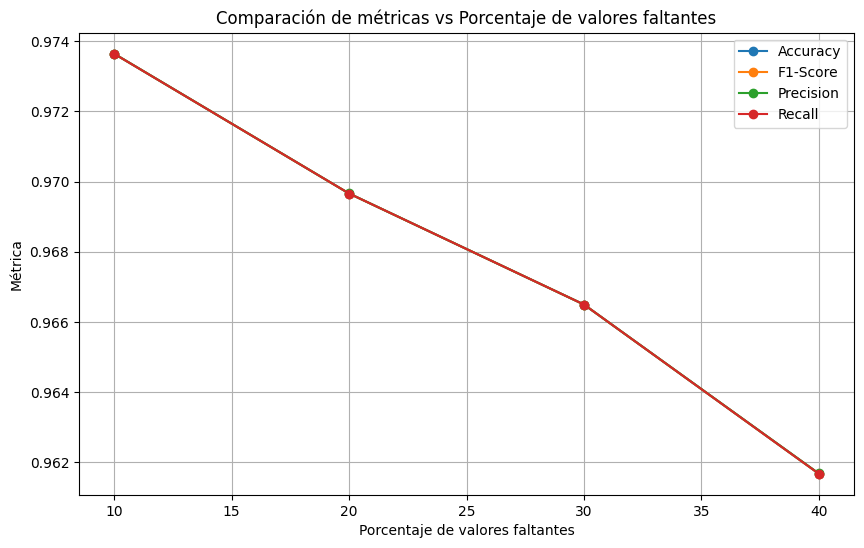

In [59]:
# Graficar las métricas en función del porcentaje de valores faltantes
plot_multiple_metrics(missingness_levels, metrics_dict)
